In [ ]:
!

In [13]:
######################################################
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import os, argparse
import cv2, spacy, numpy as np
from keras.models import model_from_json
from keras.optimizers import SGD
from sklearn.externals import joblib
from keras import backend as K
from keras.utils.vis_utils import plot_model
#K.set_image_data_format('channels_first')

word_embeddings = spacy.load('en_vectors_web_lg')



In [14]:
######################################################

VQA_weights_file_name   = '/home/cudacenter/Desktop/g66/model_vqa_vgg19.h5'
label_encoder_file_name = '/home/cudacenter/Desktop/g66/VQA/files/FULL_labelencoder_trainval.pkl'
#CNN_weights_file_name   = '/home/cudacenter/Desktop/g66/model_vqa_vgg19.h5'
#VQA_model_file_name      = '/content/gdrive/My Drive/Colab Notebooks/VQA_Demo-master/models/VQA/VQA_MODEL.json'

In [12]:
from keras.models import Model  
from keras.layers import *
from keras.applications.resnet50 import ResNet50  
from keras.preprocessing import image
import numpy as np

from keras.applications.inception_resnet_v2 import InceptionResNetV2 
from keras.applications.xception import Xception


model_resnet50 = ResNet50(include_top=True)
#print(model_resnet50.summary())
model_resnet50 = Model(inputs=model_resnet50.input, outputs=model_resnet50.get_layer('avg_pool').output)



Using TensorFlow backend.


In [15]:
model_resnet50.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [2]:
######################################################


def get_image_features_resnet(x):
    x = keras.applications.resnet50.preprocess_input(x)
    features = model_resnet50.predict(x)
    return features

In [3]:
######################################################

def get_image_features_inception(x):
    x = keras.applications.inception_resnet_v2.preprocess_input(x)
    features = model_inception.predict(x)
    return features

In [4]:
######################################################


def get_image_features_xception(x):
    x = keras.applications.xception.preprocess_input(x)
    features = model_xception.predict(x)
    return features

In [5]:

def pre_pro(image_file_name):
    img_path = image_file_name
    img = image.load_img(img_path, target_size=(299, 299))
    img2 = image.load_img(img_path, target_size=(224, 224))

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x1 = image.img_to_array(img2)
    x1 = np.expand_dims(x1, axis=0)
    r = get_image_features_resnet(x1)
    i = get_image_features_inception(x)
    x = get_image_features_xception(x)
    return r,i,x




In [16]:
def get_image_features(image_file_name):
    img_path = image_file_name
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0) 
    x = keras.applications.resnet50.preprocess_input(x)
    features = model_resnet.predict(x)
    return features    

In [17]:
def get_question_features(question):
    
    

    tokens = word_embeddings(question)
    question_tensor = np.zeros((1, 30, 300))
    for j in range(len(tokens)):
        question_tensor[0,j,:] = tokens[j].vector
    return question_tensor

In [18]:
from keras.metrics import top_k_categorical_accuracy
def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)





In [19]:
import keras
from keras.models import Model    
from keras.layers import *
from keras.models import Sequential
from keras.layers.core import Reshape, Activation, Dropout
from keras.layers import LSTM, Dense
from keras.utils.vis_utils import plot_model
def VQA_MODEL():
    

    image_feature_size          = 2048
    word_feature_size           = 300
    number_of_LSTM              = 3
    number_of_hidden_units_LSTM = 512
    max_length_questions        = 30
    number_of_dense_layers      = 3
    number_of_hidden_units      = 1024
    activation_function         = 'tanh'
    dropout_pct                 = 0.5


    # Image model
    model_image = Sequential()
    model_image.add(Reshape((image_feature_size,), input_shape=(image_feature_size,)))
    model_image.add(Dense(1024, activation=activation_function))
    
    
    #caption model
    

    # Language Model


    inputs1 = Input(shape=(max_length_questions, word_feature_size))
    lstm1,h,c = LSTM(number_of_hidden_units_LSTM, return_sequences=True,return_state=True)(inputs1)
    lstm1,h,c = LSTM(number_of_hidden_units_LSTM, return_sequences=True,return_state=True)([lstm1,h,c])
    lstm1,h,c = LSTM(number_of_hidden_units_LSTM, return_sequences=True,return_state=True)([lstm1,h,c])

    lstm1,h,c = LSTM(number_of_hidden_units_LSTM, return_sequences=True,return_state=True)([lstm1,h,c])

    lstm1,h,c = LSTM(number_of_hidden_units_LSTM, return_sequences=False,return_state=True)([lstm1,h,c])
    #y = Lambda(lambda x: tf.keras.backend.concatenate([h,c],0))([lstm1,h,c])
    y = Concatenate()([h,c])
    model_language = Model(inputs=inputs1, outputs=y)
    # combined model
    conc = keras.layers.Multiply()([model_language.output,model_image.output])


    out = Dense(number_of_hidden_units, activation=activation_function)(conc)
    #out = Dropout(0.4)(out)

    out = Dense(number_of_hidden_units, activation=activation_function)(out)
    out = Dropout(0.5)(out)

    out = Dense(number_of_hidden_units, activation=activation_function)(out)
    out = Dropout(0.7)(out)




    out = Dense(1000, activation='softmax')(out)

    model_vqa = Model([model_language.input, model_image.input], out)


    #model_vqa.summary()
    #plot_model(model_vqa, to_file='model_vqa.png')

    return model_vqa

In [20]:
def get_VQA_model():
    
    vqa_model = VQA_MODEL()

    vqa_model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy','top_k_categorical_accuracy',top_3_accuracy])
    return vqa_model

In [21]:
from keras.models import load_model
model_vqa = get_VQA_model()
model_vqa.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 30, 300)      0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 30, 512), (N 1665024     input_2[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 30, 512), (N 2099200     lstm_1[0][0]                     
                                                                 lstm_1[0][1]                     
                                                                 lstm_1[0][2]                     
__________________________________________________________________________________________________
lstm_3 (LS

In [20]:
from sklearn.externals import joblib

label_encoder_file_name = '/home/cudacenter/Desktop/g66/VQA/files/FULL_labelencoder_trainval.pkl'
labelencoder = joblib.load(label_encoder_file_name)

image_file_name = '/home/cudacenter/Desktop/g66/VQA/brown_bear.png'
question = u"Which animal is this?"


In [21]:
image_features = get_image_features(image_file_name)
print('img')
question_features = get_question_features(question)
print('question')
y_output = model_vqa.predict([question_features, image_features])

warnings.filterwarnings("ignore", category=DeprecationWarning)
labelencoder = joblib.load(label_encoder_file_name)
#print(y_output[0])
for label in reversed(np.argsort(y_output)[0,-5:]):
    print (str(round(y_output[0,label]*100,2)).zfill(5), "% ",labelencoder.classes_[label])

img
question
95.11 %  bear
03.43 %  polar bear
00.61 %  bears
000.2 %  cat
00.15 %  elephant


In [6]:
######################################################

import json

   
train = []
test = []
imdir= '/home/cudacenter/Desktop/g66/train2014/COCO_train2014_%012d.jpg'


#print 'Loading annotations and questions...'
train_anno = json.load(open('/home/cudacenter/Desktop/g66/v2_mscoco_train2014_annotations.json', 'r'))


train_ques = json.load(open('/home/cudacenter/Desktop/g66/v2_OpenEnded_mscoco_train2014_questions.json', 'r'))

test_ques = json.load(open('/home/cudacenter/Desktop/g66/v2_OpenEnded_mscoco_test2015_questions.json', 'r'))

#subtype = 'train2014'
for i in range(len(train_anno['annotations'])):
    ans = train_anno['annotations'][i]['multiple_choice_answer']
    question_id = train_anno['annotations'][i]['question_id']
    image_path = imdir%(train_anno['annotations'][i]['image_id'])
    img_id = train_anno['annotations'][i]['image_id']
    question = train_ques['questions'][i]['question']

    train.append({'ques_id': question_id,'img_id':img_id , 'img_path': image_path, 'question': question, 'ans': ans})





#json.dump(train, open('vqa_raw_train.json', 'w'))
#json.dump(test, open('vqa_raw_test.json', 'w'))



   
    

In [7]:
######################################################

train = sorted(train, key = lambda i: (i['ques_id']))
#train = np.asarray(train)
#train = np.squeeze(train)
#np.save('train.npy',train)
test = train[0:80000]
print(len(test))

80000


In [8]:
######################################################
from sklearn.externals import joblib

label_encoder_file_name = '/home/cudacenter/Desktop/g66/VQA/files/FULL_labelencoder_trainval.pkl'
labelencoder = joblib.load(label_encoder_file_name)


#labelencoder.classes_[12]
mapp = {}
mappr = {}

for i in range(len(labelencoder.classes_)):
  #print(labelencoder.classes_[i],i)
  mapp[i] = labelencoder.classes_[i]
  mappr[labelencoder.classes_[i]] = i
  
#mapp[64]
#mappr[]





    


/home/cudacenter/.local/lib/python3.5/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LabelEncoder from version pre-0.18 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/cudacenter/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The file '/home/cudacenter/Desktop/g66/VQA/files/FULL_labelencoder_trainval.pkl' has been generated with a joblib version less than 0.10. Please regenerate this pickle file.
  """


In [9]:
######################################################

import time
import keras



imdir= '/home/cudacenter/Desktop/g66/train2014/COCO_train2014_%012d.jpg'
#word_embeddings = spacy.load('en_vectors_web_lg')




start = time.time()
imgfet_res = []
imgfet_inc = []
imgfet_x = []



for i in range(80000):
    try:
        mappr[train[i]['ans']]
        fet_res,fet_inc,fet_x = pre_pro(imdir%(train[i]['img_id']))
        print('img')
        u = str(train[i]['question'])
        qfet = get_question_features(u)
        print('ques')
        imgfet_res.append(fet_res)
        imgfet_inc.append(fet_inc)
        imgfet_x.append(fet_x)

        quesfet.append(qfet)
        l.append(mappr[train[i]['ans']])
        print(i)
        end = time.time()
        g = (end-start)
        #et = tt-g
        #print('estimated time : ',end)
        print(time.strftime("%H:%M:%S", time.gmtime(g)))

        
        
        
        
        
        
        
    except KeyError:
        continue
        
  
  

    

  
      
        





0
00:00:13
2
00:00:14
3
00:00:14
4
00:00:14
5
00:00:14
6
00:00:14
8
00:00:14
9
00:00:14
10
00:00:15
11
00:00:15
12
00:00:15
13
00:00:15
14
00:00:15
15
00:00:15
16
00:00:15
17
00:00:15
18
00:00:16
19
00:00:16
20
00:00:16
21
00:00:16
22
00:00:16
23
00:00:16
24
00:00:16
25
00:00:17
26
00:00:17
27
00:00:17
28
00:00:17
30
00:00:17
31
00:00:17
32
00:00:17
33
00:00:17
34
00:00:18
35
00:00:18
36
00:00:18
37
00:00:18
38
00:00:18
39
00:00:18
41
00:00:18
42
00:00:19
43
00:00:19
45
00:00:19
46
00:00:19
48
00:00:19
49
00:00:19
50
00:00:19
51
00:00:20
53
00:00:20
54
00:00:20
55
00:00:20
57
00:00:20
58
00:00:20
59
00:00:20
61
00:00:20
62
00:00:21
63
00:00:21
64
00:00:21
65
00:00:21
66
00:00:21
67
00:00:21
68
00:00:21
69
00:00:21
70
00:00:22
71
00:00:22
73
00:00:22
74
00:00:22
75
00:00:22
76
00:00:22
77
00:00:22
78
00:00:22
79
00:00:23
80
00:00:23
81
00:00:23
82
00:00:23
83
00:00:23
84
00:00:23
85
00:00:23
86
00:00:24
87
00:00:24
89
00:00:24
90
00:00:24
91
00:00:24
93
00:00:24
94
00:00:24
96
00:00:25


734
00:01:37
735
00:01:37
736
00:01:37
737
00:01:37
738
00:01:37
739
00:01:37
740
00:01:37
741
00:01:38
742
00:01:38
743
00:01:38
744
00:01:38
745
00:01:38
746
00:01:38
747
00:01:38
748
00:01:38
749
00:01:39
750
00:01:39
751
00:01:39
752
00:01:39
753
00:01:39
754
00:01:39
755
00:01:39
756
00:01:40
757
00:01:40
758
00:01:40
759
00:01:40
760
00:01:40
761
00:01:40
762
00:01:40
763
00:01:41
764
00:01:41
765
00:01:41
766
00:01:41
768
00:01:41
770
00:01:41
771
00:01:41
772
00:01:41
773
00:01:42
774
00:01:42
775
00:01:42
776
00:01:42
777
00:01:42
778
00:01:42
779
00:01:42
780
00:01:42
781
00:01:43
782
00:01:43
783
00:01:43
784
00:01:43
785
00:01:43
787
00:01:43
788
00:01:43
790
00:01:43
791
00:01:44
792
00:01:44
793
00:01:44
795
00:01:44
797
00:01:44
798
00:01:44
799
00:01:44
800
00:01:45
801
00:01:45
802
00:01:45
803
00:01:45
804
00:01:45
805
00:01:45
806
00:01:45
807
00:01:45
808
00:01:46
809
00:01:46
810
00:01:46
811
00:01:46
812
00:01:46
813
00:01:46
814
00:01:46
815
00:01:46
817
00:01:47

1438
00:02:55
1439
00:02:55
1441
00:02:56
1442
00:02:56
1444
00:02:56
1445
00:02:56
1446
00:02:56
1447
00:02:56
1448
00:02:56
1449
00:02:56
1450
00:02:57
1451
00:02:57
1452
00:02:57
1454
00:02:57
1455
00:02:57
1456
00:02:57
1457
00:02:57
1458
00:02:58
1459
00:02:58
1460
00:02:58
1461
00:02:58
1462
00:02:58
1463
00:02:58
1464
00:02:58
1465
00:02:58
1466
00:02:59
1467
00:02:59
1468
00:02:59
1469
00:02:59
1470
00:02:59
1471
00:02:59
1472
00:02:59
1473
00:02:59
1474
00:03:00
1477
00:03:00
1478
00:03:00
1479
00:03:00
1480
00:03:00
1481
00:03:00
1482
00:03:00
1483
00:03:01
1484
00:03:01
1485
00:03:01
1486
00:03:01
1487
00:03:01
1488
00:03:01
1489
00:03:01
1490
00:03:01
1491
00:03:01
1492
00:03:02
1493
00:03:02
1494
00:03:02
1495
00:03:02
1496
00:03:02
1497
00:03:02
1498
00:03:02
1499
00:03:02
1500
00:03:03
1501
00:03:03
1502
00:03:03
1503
00:03:03
1504
00:03:03
1505
00:03:03
1506
00:03:03
1507
00:03:04
1508
00:03:04
1509
00:03:04
1510
00:03:04
1511
00:03:04
1512
00:03:04
1513
00:03:04
1514
0

2108
00:04:13
2109
00:04:13
2110
00:04:14
2111
00:04:14
2113
00:04:14
2114
00:04:14
2115
00:04:14
2116
00:04:14
2117
00:04:14
2118
00:04:15
2119
00:04:15
2120
00:04:15
2122
00:04:15
2123
00:04:15
2124
00:04:15
2126
00:04:15
2127
00:04:15
2128
00:04:16
2129
00:04:16
2130
00:04:16
2131
00:04:16
2132
00:04:16
2133
00:04:16
2134
00:04:16
2135
00:04:16
2136
00:04:17
2137
00:04:17
2138
00:04:17
2139
00:04:17
2140
00:04:17
2142
00:04:17
2143
00:04:17
2144
00:04:17
2145
00:04:18
2146
00:04:18
2147
00:04:18
2148
00:04:18
2149
00:04:18
2150
00:04:18
2151
00:04:18
2152
00:04:19
2153
00:04:19
2154
00:04:19
2156
00:04:19
2158
00:04:19
2159
00:04:19
2160
00:04:19
2161
00:04:19
2162
00:04:20
2163
00:04:20
2164
00:04:20
2165
00:04:20
2166
00:04:20
2167
00:04:20
2168
00:04:20
2169
00:04:20
2170
00:04:21
2171
00:04:21
2172
00:04:21
2173
00:04:21
2174
00:04:21
2175
00:04:21
2177
00:04:21
2178
00:04:21
2179
00:04:22
2180
00:04:22
2181
00:04:22
2182
00:04:22
2184
00:04:22
2185
00:04:22
2186
00:04:22
2187
0

2766
00:05:29
2767
00:05:29
2768
00:05:29
2769
00:05:29
2770
00:05:30
2771
00:05:30
2772
00:05:30
2773
00:05:30
2774
00:05:30
2775
00:05:30
2776
00:05:30
2777
00:05:31
2778
00:05:31
2779
00:05:31
2780
00:05:31
2781
00:05:31
2782
00:05:31
2783
00:05:31
2784
00:05:31
2785
00:05:32
2786
00:05:32
2787
00:05:32
2788
00:05:32
2789
00:05:32
2790
00:05:32
2791
00:05:32
2792
00:05:33
2793
00:05:33
2794
00:05:33
2795
00:05:33
2796
00:05:33
2797
00:05:33
2798
00:05:33
2799
00:05:33
2800
00:05:34
2802
00:05:34
2803
00:05:34
2804
00:05:34
2805
00:05:34
2807
00:05:34
2808
00:05:34
2809
00:05:35
2810
00:05:35
2811
00:05:35
2812
00:05:35
2813
00:05:35
2814
00:05:35
2815
00:05:35
2816
00:05:35
2817
00:05:36
2819
00:05:36
2820
00:05:36
2821
00:05:36
2822
00:05:36
2823
00:05:36
2824
00:05:36
2825
00:05:36
2826
00:05:37
2827
00:05:37
2828
00:05:37
2829
00:05:37
2830
00:05:37
2831
00:05:37
2832
00:05:37
2833
00:05:37
2834
00:05:38
2835
00:05:38
2836
00:05:38
2837
00:05:38
2839
00:05:38
2840
00:05:38
2841
0

3445
00:06:46
3446
00:06:46
3448
00:06:46
3449
00:06:47
3450
00:06:47
3452
00:06:47
3454
00:06:47
3455
00:06:47
3456
00:06:47
3457
00:06:47
3458
00:06:48
3461
00:06:48
3462
00:06:48
3463
00:06:48
3464
00:06:48
3466
00:06:48
3467
00:06:48
3468
00:06:48
3469
00:06:49
3470
00:06:49
3471
00:06:49
3472
00:06:49
3473
00:06:49
3474
00:06:49
3475
00:06:49
3476
00:06:49
3477
00:06:50
3478
00:06:50
3479
00:06:50
3480
00:06:50
3481
00:06:50
3482
00:06:50
3483
00:06:50
3484
00:06:51
3485
00:06:51
3486
00:06:51
3487
00:06:51
3488
00:06:51
3489
00:06:51
3490
00:06:51
3491
00:06:51
3492
00:06:51
3493
00:06:52
3494
00:06:52
3495
00:06:52
3496
00:06:52
3497
00:06:52
3498
00:06:52
3499
00:06:52
3500
00:06:52
3501
00:06:53
3502
00:06:53
3503
00:06:53
3504
00:06:53
3505
00:06:53
3506
00:06:53
3507
00:06:53
3508
00:06:53
3509
00:06:53
3512
00:06:54
3513
00:06:54
3514
00:06:54
3515
00:06:54
3516
00:06:54
3517
00:06:54
3518
00:06:54
3519
00:06:54
3520
00:06:55
3521
00:06:55
3522
00:06:55
3523
00:06:55
3524
0

4113
00:08:03
4114
00:08:03
4115
00:08:03
4117
00:08:03
4118
00:08:04
4119
00:08:04
4120
00:08:04
4121
00:08:04
4122
00:08:04
4123
00:08:04
4124
00:08:04
4125
00:08:05
4126
00:08:05
4127
00:08:05
4128
00:08:05
4129
00:08:05
4131
00:08:05
4132
00:08:05
4133
00:08:05
4134
00:08:06
4135
00:08:06
4136
00:08:06
4137
00:08:06
4138
00:08:06
4139
00:08:06
4141
00:08:06
4142
00:08:07
4143
00:08:07
4144
00:08:07
4145
00:08:07
4147
00:08:07
4148
00:08:07
4149
00:08:07
4151
00:08:07
4152
00:08:08
4154
00:08:08
4157
00:08:08
4160
00:08:08
4161
00:08:08
4162
00:08:08
4163
00:08:08
4164
00:08:09
4165
00:08:09
4166
00:08:09
4167
00:08:09
4168
00:08:09
4169
00:08:09
4170
00:08:09
4172
00:08:10
4173
00:08:10
4175
00:08:10
4176
00:08:10
4177
00:08:10
4178
00:08:10
4179
00:08:10
4180
00:08:10
4181
00:08:11
4182
00:08:11
4183
00:08:11
4184
00:08:11
4185
00:08:11
4187
00:08:11
4188
00:08:11
4189
00:08:12
4190
00:08:12
4191
00:08:12
4193
00:08:12
4194
00:08:12
4195
00:08:12
4196
00:08:12
4197
00:08:12
4198
0

4818
00:09:20
4819
00:09:20
4820
00:09:20
4821
00:09:20
4822
00:09:20
4823
00:09:20
4824
00:09:20
4825
00:09:21
4826
00:09:21
4827
00:09:21
4828
00:09:21
4829
00:09:21
4830
00:09:21
4831
00:09:21
4832
00:09:21
4833
00:09:22
4834
00:09:22
4835
00:09:22
4836
00:09:22
4837
00:09:22
4838
00:09:22
4840
00:09:22
4841
00:09:23
4842
00:09:23
4843
00:09:23
4845
00:09:23
4846
00:09:23
4847
00:09:23
4849
00:09:23
4850
00:09:23
4851
00:09:24
4852
00:09:24
4853
00:09:24
4854
00:09:24
4856
00:09:24
4857
00:09:24
4858
00:09:24
4859
00:09:24
4860
00:09:25
4861
00:09:25
4862
00:09:25
4863
00:09:25
4864
00:09:25
4865
00:09:25
4866
00:09:25
4868
00:09:25
4869
00:09:26
4870
00:09:26
4871
00:09:26
4872
00:09:26
4873
00:09:26
4874
00:09:26
4875
00:09:26
4876
00:09:26
4877
00:09:27
4878
00:09:27
4879
00:09:27
4880
00:09:27
4881
00:09:27
4882
00:09:27
4883
00:09:27
4884
00:09:28
4885
00:09:28
4886
00:09:28
4887
00:09:28
4888
00:09:28
4889
00:09:28
4890
00:09:28
4891
00:09:29
4893
00:09:29
4894
00:09:29
4895
0

5469
00:10:35
5470
00:10:35
5471
00:10:36
5473
00:10:36
5474
00:10:36
5476
00:10:36
5477
00:10:36
5478
00:10:36
5479
00:10:36
5480
00:10:36
5481
00:10:37
5482
00:10:37
5483
00:10:37
5484
00:10:37
5486
00:10:37
5487
00:10:37
5489
00:10:37
5490
00:10:38
5492
00:10:38
5493
00:10:38
5494
00:10:38
5495
00:10:38
5496
00:10:38
5497
00:10:38
5498
00:10:38
5499
00:10:39
5500
00:10:39
5501
00:10:39
5502
00:10:39
5503
00:10:39
5504
00:10:39
5506
00:10:40
5507
00:10:40
5508
00:10:40
5510
00:10:40
5512
00:10:40
5513
00:10:40
5515
00:10:40
5516
00:10:40
5518
00:10:41
5519
00:10:41
5520
00:10:41
5522
00:10:41
5524
00:10:41
5525
00:10:41
5527
00:10:41
5528
00:10:42
5529
00:10:42
5530
00:10:42
5531
00:10:42
5532
00:10:42
5536
00:10:42
5537
00:10:42
5538
00:10:42
5539
00:10:43
5540
00:10:43
5541
00:10:43
5542
00:10:43
5543
00:10:43
5544
00:10:43
5545
00:10:43
5546
00:10:43
5547
00:10:44
5548
00:10:44
5549
00:10:44
5550
00:10:44
5551
00:10:44
5552
00:10:44
5553
00:10:44
5557
00:10:45
5558
00:10:45
5559
0

6151
00:11:52
6152
00:11:52
6153
00:11:52
6154
00:11:53
6155
00:11:53
6156
00:11:53
6157
00:11:53
6158
00:11:53
6159
00:11:53
6160
00:11:53
6161
00:11:53
6162
00:11:53
6163
00:11:54
6164
00:11:54
6165
00:11:54
6166
00:11:54
6167
00:11:54
6168
00:11:54
6169
00:11:54
6170
00:11:54
6172
00:11:55
6173
00:11:55
6174
00:11:55
6176
00:11:55
6177
00:11:55
6178
00:11:55
6179
00:11:55
6180
00:11:55
6181
00:11:56
6182
00:11:56
6183
00:11:56
6184
00:11:56
6185
00:11:56
6186
00:11:56
6188
00:11:56
6189
00:11:56
6190
00:11:57
6191
00:11:57
6192
00:11:57
6193
00:11:57
6194
00:11:57
6195
00:11:57
6196
00:11:57
6197
00:11:57
6198
00:11:57
6199
00:11:58
6200
00:11:58
6201
00:11:58
6203
00:11:58
6204
00:11:58
6206
00:11:58
6207
00:11:58
6208
00:11:59
6209
00:11:59
6210
00:11:59
6212
00:11:59
6214
00:11:59
6215
00:11:59
6216
00:11:59
6217
00:11:59
6218
00:12:00
6219
00:12:00
6220
00:12:00
6221
00:12:00
6222
00:12:00
6223
00:12:00
6224
00:12:00
6226
00:12:00
6227
00:12:01
6228
00:12:01
6229
00:12:01
6230
0

6841
00:13:07
6842
00:13:08
6843
00:13:08
6844
00:13:08
6845
00:13:08
6846
00:13:08
6847
00:13:08
6848
00:13:08
6849
00:13:08
6850
00:13:09
6851
00:13:09
6852
00:13:09
6853
00:13:09
6854
00:13:09
6855
00:13:09
6856
00:13:09
6857
00:13:09
6858
00:13:10
6859
00:13:10
6860
00:13:10
6861
00:13:10
6862
00:13:10
6863
00:13:10
6864
00:13:10
6865
00:13:10
6866
00:13:11
6867
00:13:11
6868
00:13:11
6869
00:13:11
6871
00:13:11
6873
00:13:11
6874
00:13:11
6875
00:13:11
6876
00:13:12
6877
00:13:12
6878
00:13:12
6879
00:13:12
6880
00:13:12
6881
00:13:12
6882
00:13:12
6883
00:13:13
6884
00:13:13
6885
00:13:13
6886
00:13:13
6887
00:13:13
6889
00:13:13
6890
00:13:13
6892
00:13:14
6893
00:13:14
6894
00:13:14
6895
00:13:14
6896
00:13:14
6897
00:13:14
6900
00:13:14
6903
00:13:14
6904
00:13:14
6905
00:13:15
6906
00:13:15
6907
00:13:15
6908
00:13:15
6909
00:13:15
6910
00:13:15
6911
00:13:15
6912
00:13:15
6913
00:13:16
6914
00:13:16
6915
00:13:16
6916
00:13:16
6917
00:13:16
6920
00:13:16
6921
00:13:16
6922
0

7518
00:14:23
7519
00:14:23
7520
00:14:23
7521
00:14:23
7522
00:14:23
7523
00:14:24
7524
00:14:24
7525
00:14:24
7526
00:14:24
7527
00:14:24
7528
00:14:24
7529
00:14:24
7530
00:14:24
7533
00:14:25
7534
00:14:25
7535
00:14:25
7536
00:14:25
7537
00:14:25
7538
00:14:25
7539
00:14:25
7540
00:14:25
7541
00:14:26
7542
00:14:26
7543
00:14:26
7544
00:14:26
7545
00:14:26
7546
00:14:26
7547
00:14:26
7548
00:14:26
7549
00:14:27
7550
00:14:27
7551
00:14:27
7552
00:14:27
7553
00:14:27
7554
00:14:27
7555
00:14:27
7556
00:14:28
7557
00:14:28
7558
00:14:28
7559
00:14:28
7560
00:14:28
7561
00:14:28
7562
00:14:28
7564
00:14:28
7566
00:14:29
7567
00:14:29
7569
00:14:29
7570
00:14:29
7571
00:14:29
7572
00:14:29
7574
00:14:29
7575
00:14:29
7576
00:14:30
7578
00:14:30
7580
00:14:30
7582
00:14:30
7583
00:14:30
7584
00:14:30
7585
00:14:30
7586
00:14:30
7587
00:14:31
7589
00:14:31
7591
00:14:31
7592
00:14:31
7593
00:14:31
7594
00:14:31
7595
00:14:31
7596
00:14:31
7597
00:14:32
7598
00:14:32
7599
00:14:32
7600
0

8171
00:15:37
8172
00:15:37
8176
00:15:37
8177
00:15:37
8178
00:15:37
8179
00:15:37
8180
00:15:38
8181
00:15:38
8182
00:15:38
8183
00:15:38
8184
00:15:38
8185
00:15:38
8186
00:15:38
8187
00:15:39
8188
00:15:39
8189
00:15:39
8190
00:15:39
8191
00:15:39
8192
00:15:39
8193
00:15:39
8194
00:15:39
8195
00:15:40
8196
00:15:40
8197
00:15:40
8198
00:15:40
8199
00:15:40
8200
00:15:40
8201
00:15:40
8202
00:15:40
8203
00:15:41
8204
00:15:41
8205
00:15:41
8206
00:15:41
8207
00:15:41
8209
00:15:41
8210
00:15:41
8211
00:15:41
8212
00:15:41
8213
00:15:42
8216
00:15:42
8217
00:15:42
8218
00:15:42
8219
00:15:42
8220
00:15:42
8221
00:15:42
8222
00:15:43
8223
00:15:43
8225
00:15:43
8226
00:15:43
8227
00:15:43
8228
00:15:43
8229
00:15:43
8230
00:15:43
8232
00:15:44
8233
00:15:44
8234
00:15:44
8235
00:15:44
8236
00:15:44
8237
00:15:44
8238
00:15:44
8239
00:15:44
8241
00:15:45
8242
00:15:45
8243
00:15:45
8244
00:15:45
8245
00:15:45
8246
00:15:45
8247
00:15:45
8248
00:15:45
8249
00:15:46
8250
00:15:46
8252
0

8835
00:16:53
8836
00:16:53
8837
00:16:53
8838
00:16:53
8840
00:16:53
8841
00:16:54
8842
00:16:54
8843
00:16:54
8844
00:16:54
8845
00:16:54
8846
00:16:54
8847
00:16:54
8848
00:16:54
8849
00:16:54
8850
00:16:55
8851
00:16:55
8852
00:16:55
8853
00:16:55
8854
00:16:55
8855
00:16:55
8856
00:16:55
8858
00:16:55
8859
00:16:56
8860
00:16:56
8861
00:16:56
8863
00:16:56
8864
00:16:56
8865
00:16:56
8866
00:16:56
8867
00:16:57
8868
00:16:57
8870
00:16:57
8871
00:16:57
8872
00:16:57
8873
00:16:57
8874
00:16:57
8875
00:16:57
8876
00:16:58
8877
00:16:58
8878
00:16:58
8879
00:16:58
8880
00:16:58
8881
00:16:58
8882
00:16:58
8883
00:16:58
8884
00:16:59
8885
00:16:59
8886
00:16:59
8887
00:16:59
8889
00:16:59
8890
00:16:59
8891
00:16:59
8892
00:16:59
8893
00:17:00
8895
00:17:00
8896
00:17:00
8897
00:17:00
8898
00:17:00
8899
00:17:00
8900
00:17:00
8901
00:17:00
8903
00:17:01
8906
00:17:01
8907
00:17:01
8908
00:17:01
8909
00:17:01
8910
00:17:01
8911
00:17:01
8912
00:17:02
8913
00:17:02
8914
00:17:02
8916
0

9513
00:18:08
9514
00:18:09
9515
00:18:09
9516
00:18:09
9517
00:18:09
9518
00:18:09
9520
00:18:09
9521
00:18:09
9522
00:18:09
9523
00:18:10
9524
00:18:10
9525
00:18:10
9526
00:18:10
9528
00:18:10
9529
00:18:10
9530
00:18:10
9531
00:18:11
9532
00:18:11
9533
00:18:11
9534
00:18:11
9535
00:18:11
9536
00:18:11
9537
00:18:11
9538
00:18:12
9539
00:18:12
9541
00:18:12
9542
00:18:12
9543
00:18:12
9544
00:18:12
9545
00:18:12
9547
00:18:12
9548
00:18:13
9549
00:18:13
9550
00:18:13
9551
00:18:13
9552
00:18:13
9553
00:18:13
9554
00:18:13
9555
00:18:14
9556
00:18:14
9557
00:18:14
9558
00:18:14
9559
00:18:14
9560
00:18:14
9561
00:18:14
9562
00:18:14
9563
00:18:15
9564
00:18:15
9565
00:18:15
9566
00:18:15
9567
00:18:15
9568
00:18:15
9569
00:18:15
9571
00:18:15
9573
00:18:16
9574
00:18:16
9576
00:18:16
9577
00:18:16
9578
00:18:16
9579
00:18:16
9580
00:18:16
9581
00:18:16
9582
00:18:17
9583
00:18:17
9584
00:18:17
9585
00:18:17
9586
00:18:17
9588
00:18:17
9589
00:18:17
9590
00:18:17
9591
00:18:18
9593
0

10173
00:19:24
10174
00:19:24
10175
00:19:24
10176
00:19:24
10177
00:19:24
10178
00:19:24
10180
00:19:24
10181
00:19:24
10182
00:19:25
10184
00:19:25
10185
00:19:25
10186
00:19:25
10187
00:19:25
10189
00:19:25
10190
00:19:25
10191
00:19:26
10192
00:19:26
10193
00:19:26
10194
00:19:26
10195
00:19:26
10196
00:19:26
10199
00:19:26
10200
00:19:26
10201
00:19:27
10202
00:19:27
10203
00:19:27
10204
00:19:27
10205
00:19:27
10206
00:19:27
10207
00:19:27
10208
00:19:27
10209
00:19:28
10210
00:19:28
10212
00:19:28
10213
00:19:28
10214
00:19:28
10215
00:19:28
10216
00:19:28
10217
00:19:28
10218
00:19:29
10219
00:19:29
10220
00:19:29
10221
00:19:29
10222
00:19:29
10223
00:19:29
10224
00:19:29
10225
00:19:30
10226
00:19:30
10227
00:19:30
10228
00:19:30
10229
00:19:30
10230
00:19:30
10231
00:19:30
10232
00:19:30
10234
00:19:31
10235
00:19:31
10236
00:19:31
10237
00:19:31
10239
00:19:31
10240
00:19:31
10241
00:19:31
10243
00:19:31
10244
00:19:32
10245
00:19:32
10246
00:19:32
10247
00:19:32
10248
00:1

10805
00:20:35
10806
00:20:35
10807
00:20:35
10808
00:20:35
10809
00:20:36
10810
00:20:36
10811
00:20:36
10812
00:20:36
10813
00:20:36
10814
00:20:36
10815
00:20:36
10816
00:20:36
10817
00:20:37
10818
00:20:37
10819
00:20:37
10820
00:20:37
10821
00:20:37
10822
00:20:37
10823
00:20:37
10824
00:20:37
10825
00:20:38
10826
00:20:38
10827
00:20:38
10828
00:20:38
10829
00:20:38
10830
00:20:38
10831
00:20:38
10832
00:20:38
10834
00:20:39
10835
00:20:39
10836
00:20:39
10837
00:20:39
10838
00:20:39
10839
00:20:39
10840
00:20:39
10841
00:20:39
10842
00:20:39
10843
00:20:40
10844
00:20:40
10845
00:20:40
10847
00:20:40
10848
00:20:40
10849
00:20:40
10850
00:20:40
10851
00:20:40
10852
00:20:40
10853
00:20:41
10854
00:20:41
10855
00:20:41
10856
00:20:41
10857
00:20:41
10858
00:20:41
10859
00:20:41
10860
00:20:41
10861
00:20:42
10862
00:20:42
10863
00:20:42
10864
00:20:42
10865
00:20:42
10866
00:20:42
10867
00:20:42
10868
00:20:42
10869
00:20:43
10870
00:20:43
10872
00:20:43
10873
00:20:43
10874
00:2

11422
00:21:45
11423
00:21:46
11424
00:21:46
11425
00:21:46
11427
00:21:46
11428
00:21:46
11429
00:21:46
11431
00:21:46
11432
00:21:46
11433
00:21:47
11434
00:21:47
11435
00:21:47
11436
00:21:47
11437
00:21:47
11438
00:21:47
11439
00:21:47
11441
00:21:47
11442
00:21:48
11443
00:21:48
11444
00:21:48
11445
00:21:48
11447
00:21:48
11448
00:21:48
11449
00:21:48
11450
00:21:48
11451
00:21:49
11454
00:21:49
11455
00:21:49
11458
00:21:49
11459
00:21:49
11460
00:21:49
11462
00:21:49
11464
00:21:50
11468
00:21:50
11469
00:21:50
11470
00:21:50
11471
00:21:50
11472
00:21:50
11473
00:21:50
11474
00:21:50
11475
00:21:51
11476
00:21:51
11477
00:21:51
11478
00:21:51
11479
00:21:51
11480
00:21:51
11481
00:21:51
11483
00:21:51
11484
00:21:52
11485
00:21:52
11486
00:21:52
11487
00:21:52
11488
00:21:52
11489
00:21:52
11490
00:21:52
11491
00:21:52
11492
00:21:53
11493
00:21:53
11494
00:21:53
11495
00:21:53
11498
00:21:53
11499
00:21:53
11500
00:21:53
11501
00:21:53
11502
00:21:54
11503
00:21:54
11504
00:2

12049
00:22:56
12050
00:22:56
12051
00:22:56
12052
00:22:57
12053
00:22:57
12054
00:22:57
12055
00:22:57
12056
00:22:57
12057
00:22:57
12058
00:22:57
12059
00:22:58
12060
00:22:58
12061
00:22:58
12062
00:22:58
12063
00:22:58
12064
00:22:58
12065
00:22:58
12066
00:22:58
12067
00:22:59
12068
00:22:59
12069
00:22:59
12070
00:22:59
12071
00:22:59
12072
00:22:59
12073
00:22:59
12074
00:22:59
12075
00:23:00
12076
00:23:00
12077
00:23:00
12078
00:23:00
12079
00:23:00
12080
00:23:00
12081
00:23:00
12082
00:23:01
12084
00:23:01
12085
00:23:01
12086
00:23:01
12088
00:23:01
12089
00:23:01
12090
00:23:01
12092
00:23:01
12093
00:23:02
12096
00:23:02
12097
00:23:02
12098
00:23:02
12099
00:23:02
12100
00:23:02
12101
00:23:02
12102
00:23:03
12103
00:23:03
12105
00:23:03
12106
00:23:03
12107
00:23:03
12108
00:23:03
12109
00:23:03
12110
00:23:03
12111
00:23:04
12114
00:23:04
12115
00:23:04
12116
00:23:04
12117
00:23:04
12118
00:23:04
12119
00:23:04
12120
00:23:04
12121
00:23:05
12122
00:23:05
12123
00:2

12686
00:24:07
12687
00:24:07
12689
00:24:07
12690
00:24:07
12691
00:24:07
12692
00:24:07
12693
00:24:07
12694
00:24:08
12695
00:24:08
12696
00:24:08
12697
00:24:08
12698
00:24:08
12700
00:24:08
12701
00:24:08
12702
00:24:08
12703
00:24:09
12704
00:24:09
12705
00:24:09
12707
00:24:09
12708
00:24:09
12709
00:24:09
12710
00:24:09
12711
00:24:09
12712
00:24:10
12713
00:24:10
12714
00:24:10
12715
00:24:10
12716
00:24:10
12717
00:24:10
12718
00:24:10
12719
00:24:10
12720
00:24:11
12721
00:24:11
12722
00:24:11
12723
00:24:11
12724
00:24:11
12725
00:24:11
12726
00:24:11
12727
00:24:11
12728
00:24:12
12730
00:24:12
12733
00:24:12
12734
00:24:12
12735
00:24:12
12737
00:24:12
12739
00:24:12
12740
00:24:13
12741
00:24:13
12742
00:24:13
12743
00:24:13
12744
00:24:13
12745
00:24:13
12746
00:24:13
12747
00:24:13
12748
00:24:14
12749
00:24:14
12750
00:24:14
12751
00:24:14
12752
00:24:14
12753
00:24:14
12754
00:24:14
12755
00:24:15
12756
00:24:15
12757
00:24:15
12758
00:24:15
12759
00:24:15
12760
00:2

13297
00:25:16
13298
00:25:17
13300
00:25:17
13301
00:25:17
13302
00:25:17
13303
00:25:17
13304
00:25:17
13305
00:25:17
13306
00:25:18
13307
00:25:18
13308
00:25:18
13309
00:25:18
13310
00:25:18
13311
00:25:18
13312
00:25:18
13314
00:25:18
13315
00:25:19
13316
00:25:19
13317
00:25:19
13318
00:25:19
13319
00:25:19
13320
00:25:19
13321
00:25:19
13322
00:25:20
13324
00:25:20
13327
00:25:20
13328
00:25:20
13329
00:25:20
13330
00:25:20
13331
00:25:20
13332
00:25:20
13333
00:25:21
13334
00:25:21
13335
00:25:21
13336
00:25:21
13337
00:25:21
13338
00:25:21
13339
00:25:21
13340
00:25:21
13341
00:25:22
13342
00:25:22
13343
00:25:22
13344
00:25:22
13345
00:25:22
13346
00:25:22
13347
00:25:22
13348
00:25:22
13349
00:25:23
13351
00:25:23
13352
00:25:23
13353
00:25:23
13355
00:25:23
13356
00:25:23
13357
00:25:23
13359
00:25:23
13360
00:25:24
13361
00:25:24
13363
00:25:24
13365
00:25:24
13366
00:25:24
13367
00:25:24
13368
00:25:24
13369
00:25:24
13370
00:25:25
13371
00:25:25
13372
00:25:25
13373
00:2

13911
00:26:28
13912
00:26:28
13914
00:26:28
13917
00:26:28
13918
00:26:28
13919
00:26:28
13920
00:26:29
13921
00:26:29
13922
00:26:29
13923
00:26:29
13924
00:26:29
13925
00:26:29
13926
00:26:29
13928
00:26:29
13929
00:26:30
13930
00:26:30
13931
00:26:30
13932
00:26:30
13934
00:26:30
13935
00:26:30
13936
00:26:30
13937
00:26:30
13938
00:26:31
13939
00:26:31
13940
00:26:31
13941
00:26:31
13942
00:26:31
13943
00:26:31
13944
00:26:31
13945
00:26:31
13946
00:26:32
13947
00:26:32
13948
00:26:32
13950
00:26:32
13952
00:26:32
13954
00:26:32
13955
00:26:32
13956
00:26:32
13957
00:26:33
13958
00:26:33
13959
00:26:33
13960
00:26:33
13961
00:26:33
13962
00:26:33
13963
00:26:33
13964
00:26:33
13965
00:26:34
13966
00:26:34
13967
00:26:34
13968
00:26:34
13969
00:26:34
13970
00:26:34
13972
00:26:34
13973
00:26:34
13975
00:26:35
13976
00:26:35
13977
00:26:35
13978
00:26:35
13979
00:26:35
13980
00:26:35
13981
00:26:35
13983
00:26:35
13984
00:26:36
13985
00:26:36
13986
00:26:36
13987
00:26:36
13988
00:2

14540
00:27:38
14542
00:27:38
14543
00:27:38
14544
00:27:39
14545
00:27:39
14547
00:27:39
14548
00:27:39
14549
00:27:39
14550
00:27:39
14551
00:27:39
14552
00:27:39
14553
00:27:40
14554
00:27:40
14555
00:27:40
14556
00:27:40
14557
00:27:40
14559
00:27:40
14560
00:27:40
14561
00:27:41
14562
00:27:41
14564
00:27:41
14565
00:27:41
14566
00:27:41
14567
00:27:41
14568
00:27:41
14569
00:27:41
14570
00:27:42
14572
00:27:42
14574
00:27:42
14575
00:27:42
14577
00:27:42
14578
00:27:42
14579
00:27:42
14581
00:27:43
14582
00:27:43
14584
00:27:43
14585
00:27:43
14587
00:27:43
14589
00:27:43
14590
00:27:43
14592
00:27:43
14593
00:27:44
14594
00:27:44
14595
00:27:44
14597
00:27:44
14599
00:27:44
14600
00:27:44
14602
00:27:44
14603
00:27:45
14605
00:27:45
14606
00:27:45
14607
00:27:45
14608
00:27:45
14609
00:27:45
14610
00:27:45
14611
00:27:45
14612
00:27:46
14613
00:27:46
14614
00:27:46
14615
00:27:46
14616
00:27:46
14617
00:27:46
14618
00:27:46
14619
00:27:46
14620
00:27:47
14621
00:27:47
14622
00:2

15181
00:28:49
15182
00:28:50
15185
00:28:50
15186
00:28:50
15187
00:28:50
15188
00:28:50
15189
00:28:50
15190
00:28:50
15191
00:28:50
15197
00:28:51
15198
00:28:51
15199
00:28:51
15200
00:28:51
15201
00:28:51
15202
00:28:51
15203
00:28:51
15204
00:28:52
15205
00:28:52
15206
00:28:52
15207
00:28:52
15208
00:28:52
15209
00:28:52
15210
00:28:52
15211
00:28:52
15212
00:28:53
15213
00:28:53
15214
00:28:53
15215
00:28:53
15216
00:28:53
15217
00:28:53
15218
00:28:53
15219
00:28:54
15220
00:28:54
15221
00:28:54
15223
00:28:54
15224
00:28:54
15225
00:28:54
15226
00:28:54
15227
00:28:54
15228
00:28:55
15229
00:28:55
15230
00:28:55
15232
00:28:55
15234
00:28:55
15235
00:28:55
15236
00:28:55
15237
00:28:55
15238
00:28:56
15239
00:28:56
15240
00:28:56
15241
00:28:56
15243
00:28:56
15244
00:28:56
15245
00:28:56
15246
00:28:56
15247
00:28:57
15248
00:28:57
15249
00:28:57
15251
00:28:57
15254
00:28:57
15258
00:28:57
15259
00:28:57
15260
00:28:57
15261
00:28:58
15262
00:28:58
15263
00:28:58
15264
00:2

15822
00:30:00
15823
00:30:00
15824
00:30:00
15825
00:30:00
15826
00:30:00
15827
00:30:00
15828
00:30:00
15829
00:30:01
15830
00:30:01
15831
00:30:01
15832
00:30:01
15833
00:30:01
15834
00:30:01
15835
00:30:01
15836
00:30:01
15837
00:30:02
15838
00:30:02
15839
00:30:02
15840
00:30:02
15841
00:30:02
15843
00:30:02
15845
00:30:02
15846
00:30:02
15847
00:30:03
15848
00:30:03
15849
00:30:03
15850
00:30:03
15851
00:30:03
15852
00:30:03
15854
00:30:03
15855
00:30:04
15856
00:30:04
15857
00:30:04
15858
00:30:04
15859
00:30:04
15860
00:30:04
15861
00:30:04
15862
00:30:04
15864
00:30:05
15865
00:30:05
15866
00:30:05
15867
00:30:05
15869
00:30:05
15870
00:30:05
15871
00:30:05
15872
00:30:05
15873
00:30:06
15874
00:30:06
15875
00:30:06
15877
00:30:06
15878
00:30:06
15879
00:30:06
15880
00:30:06
15881
00:30:06
15882
00:30:07
15883
00:30:07
15884
00:30:07
15885
00:30:07
15886
00:30:07
15887
00:30:07
15888
00:30:07
15889
00:30:08
15890
00:30:08
15891
00:30:08
15892
00:30:08
15893
00:30:08
15895
00:3

16462
00:31:10
16464
00:31:10
16465
00:31:10
16466
00:31:11
16467
00:31:11
16468
00:31:11
16469
00:31:11
16470
00:31:11
16471
00:31:11
16472
00:31:11
16473
00:31:12
16476
00:31:12
16477
00:31:12
16478
00:31:12
16479
00:31:12
16481
00:31:12
16482
00:31:12
16484
00:31:13
16485
00:31:13
16486
00:31:13
16487
00:31:13
16488
00:31:13
16489
00:31:13
16490
00:31:13
16491
00:31:13
16493
00:31:14
16494
00:31:14
16496
00:31:14
16498
00:31:14
16499
00:31:14
16500
00:31:14
16501
00:31:14
16502
00:31:15
16503
00:31:15
16504
00:31:15
16505
00:31:15
16506
00:31:15
16507
00:31:15
16508
00:31:15
16509
00:31:15
16511
00:31:16
16513
00:31:16
16514
00:31:16
16516
00:31:16
16517
00:31:16
16518
00:31:16
16519
00:31:16
16520
00:31:16
16521
00:31:17
16522
00:31:17
16523
00:31:17
16524
00:31:17
16525
00:31:17
16526
00:31:17
16527
00:31:17
16528
00:31:17
16529
00:31:18
16530
00:31:18
16531
00:31:18
16532
00:31:18
16533
00:31:18
16534
00:31:18
16535
00:31:18
16536
00:31:19
16537
00:31:19
16539
00:31:19
16540
00:3

17107
00:32:21
17108
00:32:21
17109
00:32:21
17110
00:32:22
17111
00:32:22
17112
00:32:22
17113
00:32:22
17114
00:32:22
17115
00:32:22
17116
00:32:22
17117
00:32:22
17118
00:32:23
17119
00:32:23
17120
00:32:23
17121
00:32:23
17122
00:32:23
17123
00:32:23
17124
00:32:23
17125
00:32:23
17126
00:32:24
17127
00:32:24
17128
00:32:24
17129
00:32:24
17130
00:32:24
17131
00:32:24
17132
00:32:24
17133
00:32:24
17134
00:32:25
17136
00:32:25
17137
00:32:25
17138
00:32:25
17139
00:32:25
17140
00:32:25
17141
00:32:25
17142
00:32:25
17143
00:32:26
17144
00:32:26
17145
00:32:26
17146
00:32:26
17147
00:32:26
17148
00:32:26
17149
00:32:26
17150
00:32:26
17151
00:32:26
17152
00:32:27
17153
00:32:27
17155
00:32:27
17156
00:32:27
17157
00:32:27
17161
00:32:27
17163
00:32:27
17164
00:32:27
17166
00:32:28
17167
00:32:28
17168
00:32:28
17169
00:32:28
17170
00:32:28
17171
00:32:28
17172
00:32:28
17173
00:32:28
17174
00:32:29
17175
00:32:29
17178
00:32:29
17179
00:32:29
17180
00:32:29
17181
00:32:29
17183
00:3

17740
00:33:31
17741
00:33:31
17743
00:33:31
17744
00:33:32
17746
00:33:32
17747
00:33:32
17748
00:33:32
17749
00:33:32
17750
00:33:32
17751
00:33:32
17752
00:33:32
17753
00:33:33
17754
00:33:33
17755
00:33:33
17756
00:33:33
17758
00:33:33
17759
00:33:33
17760
00:33:33
17761
00:33:34
17762
00:33:34
17764
00:33:34
17765
00:33:34
17766
00:33:34
17768
00:33:34
17769
00:33:34
17770
00:33:34
17772
00:33:35
17774
00:33:35
17775
00:33:35
17776
00:33:35
17777
00:33:35
17778
00:33:35
17779
00:33:35
17780
00:33:35
17781
00:33:36
17782
00:33:36
17783
00:33:36
17784
00:33:36
17786
00:33:36
17787
00:33:36
17789
00:33:36
17790
00:33:37
17791
00:33:37
17792
00:33:37
17793
00:33:37
17794
00:33:37
17795
00:33:37
17797
00:33:37
17798
00:33:37
17799
00:33:38
17800
00:33:38
17801
00:33:38
17803
00:33:38
17804
00:33:38
17805
00:33:38
17806
00:33:38
17807
00:33:38
17808
00:33:39
17809
00:33:39
17811
00:33:39
17813
00:33:39
17814
00:33:39
17815
00:33:39
17816
00:33:39
17817
00:33:40
17818
00:33:40
17820
00:3

18367
00:34:42
18369
00:34:42
18371
00:34:42
18373
00:34:42
18374
00:34:42
18375
00:34:43
18376
00:34:43
18377
00:34:43
18378
00:34:43
18379
00:34:43
18380
00:34:43
18381
00:34:43
18382
00:34:44
18383
00:34:44
18384
00:34:44
18385
00:34:44
18386
00:34:44
18387
00:34:44
18388
00:34:44
18390
00:34:44
18391
00:34:45
18392
00:34:45
18393
00:34:45
18394
00:34:45
18395
00:34:45
18396
00:34:45
18397
00:34:45
18398
00:34:45
18399
00:34:45
18400
00:34:46
18401
00:34:46
18402
00:34:46
18403
00:34:46
18404
00:34:46
18405
00:34:46
18406
00:34:46
18407
00:34:46
18408
00:34:47
18409
00:34:47
18411
00:34:47
18413
00:34:47
18414
00:34:47
18416
00:34:47
18417
00:34:47
18418
00:34:47
18419
00:34:48
18420
00:34:48
18421
00:34:48
18423
00:34:48
18424
00:34:48
18426
00:34:48
18427
00:34:48
18428
00:34:49
18429
00:34:49
18430
00:34:49
18431
00:34:49
18432
00:34:49
18433
00:34:49
18434
00:34:49
18435
00:34:49
18437
00:34:50
18438
00:34:50
18439
00:34:50
18440
00:34:50
18441
00:34:50
18442
00:34:50
18443
00:3

18984
00:35:53
18985
00:35:53
18986
00:35:53
18987
00:35:53
18989
00:35:54
18990
00:35:54
18991
00:35:54
18992
00:35:54
18993
00:35:54
18994
00:35:54
18995
00:35:54
18996
00:35:55
18997
00:35:55
18998
00:35:55
18999
00:35:55
19001
00:35:55
19002
00:35:55
19003
00:35:55
19004
00:35:55
19006
00:35:56
19007
00:35:56
19008
00:35:56
19009
00:35:56
19010
00:35:56
19011
00:35:56
19013
00:35:56
19014
00:35:56
19015
00:35:57
19017
00:35:57
19018
00:35:57
19019
00:35:57
19020
00:35:57
19021
00:35:57
19022
00:35:57
19024
00:35:58
19026
00:35:58
19027
00:35:58
19028
00:35:58
19030
00:35:58
19032
00:35:58
19033
00:35:58
19034
00:35:59
19035
00:35:59
19036
00:35:59
19037
00:35:59
19038
00:35:59
19039
00:35:59
19040
00:35:59
19041
00:35:59
19042
00:36:00
19044
00:36:00
19045
00:36:00
19046
00:36:00
19047
00:36:00
19048
00:36:00
19049
00:36:00
19050
00:36:01
19051
00:36:01
19052
00:36:01
19053
00:36:01
19054
00:36:01
19055
00:36:01
19056
00:36:01
19059
00:36:01
19061
00:36:02
19062
00:36:02
19063
00:3

19600
00:37:03
19601
00:37:03
19602
00:37:03
19604
00:37:03
19605
00:37:04
19606
00:37:04
19607
00:37:04
19608
00:37:04
19609
00:37:04
19610
00:37:04
19611
00:37:04
19612
00:37:04
19613
00:37:05
19614
00:37:05
19615
00:37:05
19616
00:37:05
19617
00:37:05
19618
00:37:05
19619
00:37:05
19620
00:37:06
19621
00:37:06
19622
00:37:06
19623
00:37:06
19625
00:37:06
19626
00:37:06
19627
00:37:06
19628
00:37:06
19629
00:37:07
19630
00:37:07
19631
00:37:07
19632
00:37:07
19633
00:37:07
19634
00:37:07
19635
00:37:07
19637
00:37:07
19638
00:37:08
19639
00:37:08
19640
00:37:08
19641
00:37:08
19643
00:37:08
19644
00:37:08
19645
00:37:08
19646
00:37:08
19647
00:37:09
19648
00:37:09
19649
00:37:09
19650
00:37:09
19651
00:37:09
19652
00:37:09
19653
00:37:09
19655
00:37:09
19656
00:37:10
19657
00:37:10
19658
00:37:10
19660
00:37:10
19661
00:37:10
19662
00:37:10
19663
00:37:10
19664
00:37:10
19665
00:37:11
19666
00:37:11
19667
00:37:11
19668
00:37:11
19669
00:37:11
19670
00:37:11
19671
00:37:11
19672
00:3

20221
00:38:14
20222
00:38:14
20223
00:38:14
20224
00:38:14
20225
00:38:14
20226
00:38:15
20227
00:38:15
20228
00:38:15
20229
00:38:15
20230
00:38:15
20231
00:38:15
20232
00:38:15
20233
00:38:16
20234
00:38:16
20235
00:38:16
20238
00:38:16
20239
00:38:16
20240
00:38:16
20241
00:38:16
20242
00:38:16
20243
00:38:17
20244
00:38:17
20245
00:38:17
20246
00:38:17
20249
00:38:17
20250
00:38:17
20251
00:38:17
20252
00:38:17
20253
00:38:18
20254
00:38:18
20255
00:38:18
20256
00:38:18
20257
00:38:18
20258
00:38:18
20259
00:38:18
20260
00:38:19
20261
00:38:19
20262
00:38:19
20263
00:38:19
20264
00:38:19
20265
00:38:19
20268
00:38:19
20269
00:38:19
20271
00:38:20
20272
00:38:20
20273
00:38:20
20274
00:38:20
20275
00:38:20
20276
00:38:20
20277
00:38:20
20278
00:38:20
20279
00:38:21
20280
00:38:21
20281
00:38:21
20282
00:38:21
20283
00:38:21
20285
00:38:21
20286
00:38:21
20287
00:38:22
20288
00:38:22
20289
00:38:22
20290
00:38:22
20291
00:38:22
20292
00:38:22
20293
00:38:22
20294
00:38:22
20295
00:3

20842
00:39:24
20843
00:39:24
20844
00:39:24
20845
00:39:24
20846
00:39:25
20847
00:39:25
20850
00:39:25
20851
00:39:25
20852
00:39:25
20853
00:39:25
20855
00:39:25
20856
00:39:26
20857
00:39:26
20858
00:39:26
20859
00:39:26
20860
00:39:26
20861
00:39:26
20862
00:39:26
20863
00:39:27
20865
00:39:27
20866
00:39:27
20867
00:39:27
20869
00:39:27
20870
00:39:27
20871
00:39:27
20872
00:39:27
20873
00:39:28
20874
00:39:28
20875
00:39:28
20876
00:39:28
20877
00:39:28
20878
00:39:28
20879
00:39:28
20880
00:39:28
20881
00:39:29
20882
00:39:29
20884
00:39:29
20885
00:39:29
20886
00:39:29
20887
00:39:29
20888
00:39:29
20890
00:39:29
20891
00:39:30
20892
00:39:30
20893
00:39:30
20894
00:39:30
20895
00:39:30
20896
00:39:30
20897
00:39:30
20899
00:39:30
20900
00:39:31
20901
00:39:31
20902
00:39:31
20903
00:39:31
20904
00:39:31
20905
00:39:31
20906
00:39:31
20907
00:39:32
20908
00:39:32
20909
00:39:32
20910
00:39:32
20911
00:39:32
20912
00:39:32
20913
00:39:32
20914
00:39:32
20915
00:39:33
20916
00:3

21467
00:40:36
21468
00:40:36
21469
00:40:36
21470
00:40:36
21471
00:40:37
21473
00:40:37
21474
00:40:37
21475
00:40:37
21476
00:40:37
21477
00:40:37
21478
00:40:37
21479
00:40:37
21480
00:40:38
21482
00:40:38
21483
00:40:38
21484
00:40:38
21485
00:40:38
21486
00:40:38
21487
00:40:38
21488
00:40:39
21489
00:40:39
21490
00:40:39
21491
00:40:39
21492
00:40:39
21493
00:40:39
21494
00:40:39
21495
00:40:40
21496
00:40:40
21498
00:40:40
21501
00:40:40
21502
00:40:40
21503
00:40:40
21504
00:40:40
21505
00:40:41
21506
00:40:41
21508
00:40:41
21509
00:40:41
21510
00:40:41
21511
00:40:41
21512
00:40:41
21513
00:40:41
21514
00:40:42
21516
00:40:42
21517
00:40:42
21518
00:40:42
21519
00:40:42
21520
00:40:42
21521
00:40:43
21522
00:40:43
21523
00:40:43
21524
00:40:43
21525
00:40:43
21526
00:40:43
21527
00:40:43
21529
00:40:43
21531
00:40:44
21532
00:40:44
21533
00:40:44
21534
00:40:44
21535
00:40:44
21536
00:40:44
21537
00:40:44
21539
00:40:45
21540
00:40:45
21541
00:40:45
21542
00:40:45
21543
00:4

22096
00:41:48
22097
00:41:48
22098
00:41:48
22099
00:41:48
22101
00:41:48
22102
00:41:49
22103
00:41:49
22104
00:41:49
22105
00:41:49
22106
00:41:49
22107
00:41:49
22108
00:41:49
22109
00:41:50
22110
00:41:50
22111
00:41:50
22112
00:41:50
22113
00:41:50
22114
00:41:50
22115
00:41:50
22116
00:41:50
22117
00:41:50
22118
00:41:51
22119
00:41:51
22121
00:41:51
22122
00:41:51
22123
00:41:51
22124
00:41:51
22126
00:41:51
22127
00:41:52
22128
00:41:52
22130
00:41:52
22132
00:41:52
22133
00:41:52
22134
00:41:52
22135
00:41:52
22136
00:41:53
22139
00:41:53
22140
00:41:53
22141
00:41:53
22142
00:41:53
22143
00:41:53
22144
00:41:53
22145
00:41:53
22146
00:41:54
22147
00:41:54
22148
00:41:54
22149
00:41:54
22150
00:41:54
22151
00:41:54
22152
00:41:54
22153
00:41:54
22154
00:41:55
22156
00:41:55
22157
00:41:55
22158
00:41:55
22159
00:41:55
22160
00:41:55
22161
00:41:55
22162
00:41:55
22164
00:41:56
22165
00:41:56
22166
00:41:56
22167
00:41:56
22168
00:41:56
22169
00:41:56
22170
00:41:56
22171
00:4

22743
00:42:58
22746
00:42:58
22747
00:42:59
22748
00:42:59
22749
00:42:59
22750
00:42:59
22751
00:42:59
22752
00:42:59
22753
00:42:59
22754
00:42:59
22755
00:43:00
22756
00:43:00
22757
00:43:00
22759
00:43:00
22761
00:43:00
22762
00:43:00
22763
00:43:00
22765
00:43:00
22766
00:43:01
22767
00:43:01
22768
00:43:01
22769
00:43:01
22770
00:43:01
22771
00:43:01
22772
00:43:01
22773
00:43:02
22774
00:43:02
22775
00:43:02
22776
00:43:02
22777
00:43:02
22778
00:43:02
22780
00:43:02
22781
00:43:03
22783
00:43:03
22784
00:43:03
22785
00:43:03
22786
00:43:03
22788
00:43:03
22789
00:43:03
22790
00:43:03
22791
00:43:04
22794
00:43:04
22795
00:43:04
22796
00:43:04
22797
00:43:04
22798
00:43:04
22799
00:43:04
22800
00:43:05
22801
00:43:05
22802
00:43:05
22803
00:43:05
22806
00:43:05
22808
00:43:05
22809
00:43:05
22811
00:43:06
22812
00:43:06
22813
00:43:06
22814
00:43:06
22816
00:43:06
22817
00:43:06
22818
00:43:06
22819
00:43:06
22820
00:43:07
22821
00:43:07
22822
00:43:07
22823
00:43:07
22825
00:4

23399
00:44:08
23400
00:44:08
23401
00:44:08
23403
00:44:08
23404
00:44:09
23406
00:44:09
23407
00:44:09
23408
00:44:09
23409
00:44:09
23410
00:44:09
23411
00:44:09
23412
00:44:09
23413
00:44:10
23414
00:44:10
23415
00:44:10
23416
00:44:10
23417
00:44:10
23418
00:44:10
23419
00:44:10
23422
00:44:11
23425
00:44:11
23426
00:44:11
23427
00:44:11
23428
00:44:11
23429
00:44:11
23430
00:44:11
23431
00:44:11
23432
00:44:12
23433
00:44:12
23434
00:44:12
23435
00:44:12
23436
00:44:12
23437
00:44:12
23438
00:44:12
23439
00:44:12
23440
00:44:13
23441
00:44:13
23442
00:44:13
23443
00:44:13
23445
00:44:13
23446
00:44:13
23447
00:44:13
23448
00:44:13
23449
00:44:14
23450
00:44:14
23451
00:44:14
23452
00:44:14
23453
00:44:14
23454
00:44:14
23455
00:44:14
23456
00:44:15
23457
00:44:15
23458
00:44:15
23459
00:44:15
23461
00:44:15
23462
00:44:15
23463
00:44:15
23464
00:44:15
23465
00:44:16
23467
00:44:16
23468
00:44:16
23470
00:44:16
23472
00:44:16
23474
00:44:16
23475
00:44:16
23476
00:44:17
23477
00:4

24034
00:45:19
24035
00:45:19
24036
00:45:19
24037
00:45:19
24038
00:45:19
24039
00:45:19
24040
00:45:19
24041
00:45:20
24042
00:45:20
24043
00:45:20
24044
00:45:20
24045
00:45:20
24046
00:45:20
24047
00:45:20
24048
00:45:20
24049
00:45:21
24050
00:45:21
24051
00:45:21
24052
00:45:21
24053
00:45:21
24054
00:45:21
24055
00:45:21
24056
00:45:21
24057
00:45:22
24058
00:45:22
24059
00:45:22
24060
00:45:22
24061
00:45:22
24062
00:45:22
24063
00:45:22
24065
00:45:22
24066
00:45:23
24067
00:45:23
24068
00:45:23
24069
00:45:23
24070
00:45:23
24071
00:45:23
24072
00:45:23
24073
00:45:23
24074
00:45:23
24075
00:45:24
24076
00:45:24
24077
00:45:24
24078
00:45:24
24079
00:45:24
24080
00:45:24
24081
00:45:24
24083
00:45:24
24084
00:45:25
24085
00:45:25
24086
00:45:25
24087
00:45:25
24088
00:45:25
24089
00:45:25
24090
00:45:25
24091
00:45:25
24092
00:45:26
24093
00:45:26
24094
00:45:26
24095
00:45:26
24096
00:45:26
24097
00:45:26
24098
00:45:26
24099
00:45:26
24100
00:45:27
24101
00:45:27
24102
00:4

24672
00:46:29
24673
00:46:29
24674
00:46:29
24675
00:46:29
24676
00:46:29
24677
00:46:29
24679
00:46:30
24680
00:46:30
24681
00:46:30
24682
00:46:30
24686
00:46:30
24687
00:46:30
24688
00:46:30
24689
00:46:30
24690
00:46:31
24691
00:46:31
24693
00:46:31
24694
00:46:31
24695
00:46:31
24696
00:46:31
24697
00:46:31
24698
00:46:32
24699
00:46:32
24700
00:46:32
24701
00:46:32
24702
00:46:32
24703
00:46:32
24704
00:46:32
24705
00:46:32
24706
00:46:33
24707
00:46:33
24708
00:46:33
24709
00:46:33
24710
00:46:33
24711
00:46:33
24712
00:46:33
24713
00:46:34
24714
00:46:34
24715
00:46:34
24716
00:46:34
24718
00:46:34
24719
00:46:34
24720
00:46:34
24721
00:46:34
24722
00:46:34
24723
00:46:35
24724
00:46:35
24725
00:46:35
24726
00:46:35
24727
00:46:35
24728
00:46:35
24729
00:46:35
24730
00:46:35
24731
00:46:36
24732
00:46:36
24733
00:46:36
24734
00:46:36
24735
00:46:36
24736
00:46:36
24737
00:46:36
24738
00:46:36
24739
00:46:37
24740
00:46:37
24741
00:46:37
24742
00:46:37
24743
00:46:37
24745
00:4

25308
00:47:39
25309
00:47:39
25310
00:47:40
25311
00:47:40
25312
00:47:40
25313
00:47:40
25316
00:47:40
25317
00:47:40
25318
00:47:40
25319
00:47:40
25320
00:47:41
25321
00:47:41
25322
00:47:41
25323
00:47:41
25325
00:47:41
25326
00:47:41
25327
00:47:41
25328
00:47:41
25329
00:47:41
25330
00:47:42
25331
00:47:42
25332
00:47:42
25333
00:47:42
25334
00:47:42
25335
00:47:42
25336
00:47:42
25337
00:47:42
25338
00:47:42
25339
00:47:43
25340
00:47:43
25342
00:47:43
25343
00:47:43
25344
00:47:43
25345
00:47:43
25347
00:47:43
25348
00:47:43
25349
00:47:44
25351
00:47:44
25354
00:47:44
25355
00:47:44
25357
00:47:44
25359
00:47:44
25360
00:47:44
25361
00:47:44
25362
00:47:45
25363
00:47:45
25364
00:47:45
25366
00:47:45
25367
00:47:45
25368
00:47:45
25369
00:47:45
25370
00:47:46
25371
00:47:46
25372
00:47:46
25373
00:47:46
25375
00:47:46
25376
00:47:46
25377
00:47:46
25378
00:47:46
25379
00:47:47
25381
00:47:47
25383
00:47:47
25384
00:47:47
25385
00:47:47
25386
00:47:47
25387
00:47:47
25388
00:4

25931
00:48:50
25932
00:48:50
25933
00:48:50
25934
00:48:51
25935
00:48:51
25936
00:48:51
25938
00:48:51
25939
00:48:51
25940
00:48:51
25941
00:48:51
25942
00:48:51
25943
00:48:52
25944
00:48:52
25945
00:48:52
25946
00:48:52
25947
00:48:52
25948
00:48:52
25949
00:48:52
25950
00:48:52
25951
00:48:53
25952
00:48:53
25953
00:48:53
25954
00:48:53
25956
00:48:53
25957
00:48:53
25958
00:48:53
25959
00:48:54
25960
00:48:54
25961
00:48:54
25962
00:48:54
25963
00:48:54
25964
00:48:54
25965
00:48:54
25967
00:48:54
25968
00:48:55
25969
00:48:55
25970
00:48:55
25971
00:48:55
25972
00:48:55
25973
00:48:55
25974
00:48:55
25975
00:48:56
25976
00:48:56
25977
00:48:56
25978
00:48:56
25979
00:48:56
25980
00:48:56
25981
00:48:56
25982
00:48:57
25983
00:48:57
25984
00:48:57
25985
00:48:57
25986
00:48:57
25987
00:48:57
25988
00:48:57
25990
00:48:57
25991
00:48:58
25992
00:48:58
25993
00:48:58
25994
00:48:58
25995
00:48:58
25997
00:48:58
25999
00:48:58
26000
00:48:59
26001
00:48:59
26004
00:48:59
26005
00:4

26543
00:50:01
26544
00:50:01
26545
00:50:01
26546
00:50:02
26547
00:50:02
26548
00:50:02
26549
00:50:02
26550
00:50:02
26551
00:50:02
26552
00:50:02
26554
00:50:03
26555
00:50:03
26556
00:50:03
26557
00:50:03
26559
00:50:03
26560
00:50:03
26562
00:50:03
26563
00:50:03
26564
00:50:04
26565
00:50:04
26567
00:50:04
26568
00:50:04
26569
00:50:04
26570
00:50:04
26571
00:50:04
26572
00:50:04
26573
00:50:05
26574
00:50:05
26575
00:50:05
26576
00:50:05
26578
00:50:05
26579
00:50:05
26581
00:50:05
26582
00:50:06
26584
00:50:06
26585
00:50:06
26586
00:50:06
26587
00:50:06
26588
00:50:06
26590
00:50:06
26592
00:50:06
26593
00:50:07
26594
00:50:07
26595
00:50:07
26596
00:50:07
26597
00:50:07
26598
00:50:07
26599
00:50:07
26600
00:50:07
26601
00:50:08
26602
00:50:08
26603
00:50:08
26604
00:50:08
26607
00:50:08
26608
00:50:08
26609
00:50:08
26610
00:50:09
26611
00:50:09
26612
00:50:09
26613
00:50:09
26614
00:50:09
26615
00:50:09
26616
00:50:09
26617
00:50:09
26618
00:50:09
26620
00:50:10
26622
00:5

27168
00:51:12
27169
00:51:12
27170
00:51:12
27172
00:51:13
27173
00:51:13
27174
00:51:13
27175
00:51:13
27176
00:51:13
27177
00:51:13
27178
00:51:13
27179
00:51:13
27180
00:51:14
27181
00:51:14
27182
00:51:14
27183
00:51:14
27184
00:51:14
27185
00:51:14
27186
00:51:14
27188
00:51:15
27189
00:51:15
27190
00:51:15
27191
00:51:15
27192
00:51:15
27193
00:51:15
27194
00:51:15
27195
00:51:15
27197
00:51:16
27198
00:51:16
27199
00:51:16
27201
00:51:16
27202
00:51:16
27203
00:51:16
27204
00:51:16
27205
00:51:16
27206
00:51:17
27207
00:51:17
27208
00:51:17
27209
00:51:17
27211
00:51:17
27212
00:51:17
27213
00:51:17
27214
00:51:17
27215
00:51:18
27216
00:51:18
27217
00:51:18
27218
00:51:18
27219
00:51:18
27220
00:51:18
27221
00:51:18
27222
00:51:18
27223
00:51:19
27224
00:51:19
27225
00:51:19
27226
00:51:19
27227
00:51:19
27228
00:51:19
27229
00:51:19
27230
00:51:19
27231
00:51:20
27232
00:51:20
27233
00:51:20
27234
00:51:20
27235
00:51:20
27236
00:51:20
27237
00:51:20
27238
00:51:20
27239
00:5

27792
00:52:23
27793
00:52:23
27794
00:52:23
27795
00:52:23
27796
00:52:23
27797
00:52:23
27798
00:52:24
27799
00:52:24
27800
00:52:24
27801
00:52:24
27803
00:52:24
27804
00:52:24
27805
00:52:24
27807
00:52:25
27808
00:52:25
27810
00:52:25
27812
00:52:25
27813
00:52:25
27814
00:52:25
27815
00:52:25
27816
00:52:25
27817
00:52:26
27818
00:52:26
27819
00:52:26
27820
00:52:26
27821
00:52:26
27822
00:52:26
27823
00:52:26
27824
00:52:27
27825
00:52:27
27826
00:52:27
27827
00:52:27
27828
00:52:27
27829
00:52:27
27830
00:52:27
27831
00:52:27
27832
00:52:28
27833
00:52:28
27834
00:52:28
27835
00:52:28
27836
00:52:28
27838
00:52:28
27839
00:52:28
27840
00:52:29
27841
00:52:29
27843
00:52:29
27844
00:52:29
27845
00:52:29
27846
00:52:29
27847
00:52:29
27848
00:52:29
27849
00:52:30
27850
00:52:30
27851
00:52:30
27852
00:52:30
27856
00:52:30
27857
00:52:30
27858
00:52:30
27859
00:52:31
27860
00:52:31
27862
00:52:31
27863
00:52:31
27865
00:52:31
27866
00:52:31
27867
00:52:31
27868
00:52:31
27869
00:5

28420
00:53:34
28421
00:53:34
28422
00:53:34
28423
00:53:34
28424
00:53:34
28425
00:53:35
28426
00:53:35
28427
00:53:35
28428
00:53:35
28429
00:53:35
28430
00:53:35
28433
00:53:35
28434
00:53:35
28435
00:53:36
28436
00:53:36
28437
00:53:36
28438
00:53:36
28439
00:53:36
28440
00:53:36
28441
00:53:36
28442
00:53:36
28443
00:53:36
28444
00:53:37
28445
00:53:37
28446
00:53:37
28447
00:53:37
28448
00:53:37
28449
00:53:37
28450
00:53:37
28451
00:53:37
28452
00:53:38
28453
00:53:38
28454
00:53:38
28455
00:53:38
28456
00:53:38
28457
00:53:38
28458
00:53:38
28459
00:53:39
28461
00:53:39
28462
00:53:39
28463
00:53:39
28464
00:53:39
28465
00:53:39
28466
00:53:39
28467
00:53:39
28468
00:53:39
28469
00:53:40
28470
00:53:40
28471
00:53:40
28472
00:53:40
28473
00:53:40
28475
00:53:40
28476
00:53:40
28477
00:53:40
28478
00:53:41
28479
00:53:41
28480
00:53:41
28481
00:53:41
28482
00:53:41
28483
00:53:41
28484
00:53:41
28485
00:53:41
28486
00:53:42
28487
00:53:42
28488
00:53:42
28489
00:53:42
28490
00:5

29045
00:54:46
29047
00:54:46
29048
00:54:46
29049
00:54:46
29050
00:54:46
29051
00:54:46
29052
00:54:46
29053
00:54:46
29054
00:54:47
29055
00:54:47
29056
00:54:47
29057
00:54:47
29058
00:54:47
29059
00:54:47
29060
00:54:47
29061
00:54:47
29062
00:54:48
29064
00:54:48
29065
00:54:48
29066
00:54:48
29067
00:54:48
29068
00:54:48
29069
00:54:48
29070
00:54:48
29071
00:54:49
29072
00:54:49
29073
00:54:49
29074
00:54:49
29075
00:54:49
29076
00:54:49
29077
00:54:49
29078
00:54:49
29079
00:54:50
29080
00:54:50
29081
00:54:50
29082
00:54:50
29083
00:54:50
29084
00:54:50
29085
00:54:50
29086
00:54:51
29087
00:54:51
29088
00:54:51
29089
00:54:51
29090
00:54:51
29091
00:54:51
29092
00:54:51
29093
00:54:51
29094
00:54:52
29095
00:54:52
29096
00:54:52
29097
00:54:52
29098
00:54:52
29099
00:54:52
29100
00:54:52
29101
00:54:53
29102
00:54:53
29104
00:54:53
29105
00:54:53
29106
00:54:53
29107
00:54:53
29108
00:54:53
29109
00:54:54
29110
00:54:54
29111
00:54:54
29112
00:54:54
29113
00:54:54
29114
00:5

29653
00:55:56
29654
00:55:56
29655
00:55:57
29656
00:55:57
29657
00:55:57
29658
00:55:57
29659
00:55:57
29660
00:55:57
29661
00:55:57
29662
00:55:57
29663
00:55:58
29664
00:55:58
29665
00:55:58
29666
00:55:58
29667
00:55:58
29669
00:55:58
29670
00:55:58
29671
00:55:58
29672
00:55:59
29673
00:55:59
29674
00:55:59
29675
00:55:59
29676
00:55:59
29677
00:55:59
29678
00:55:59
29679
00:55:59
29680
00:56:00
29681
00:56:00
29682
00:56:00
29683
00:56:00
29684
00:56:00
29685
00:56:00
29686
00:56:00
29687
00:56:00
29688
00:56:01
29689
00:56:01
29690
00:56:01
29691
00:56:01
29692
00:56:01
29693
00:56:01
29694
00:56:01
29695
00:56:01
29696
00:56:01
29697
00:56:02
29698
00:56:02
29699
00:56:02
29700
00:56:02
29701
00:56:02
29702
00:56:02
29703
00:56:02
29704
00:56:03
29705
00:56:03
29706
00:56:03
29707
00:56:03
29709
00:56:03
29710
00:56:03
29711
00:56:03
29712
00:56:03
29713
00:56:04
29714
00:56:04
29715
00:56:04
29716
00:56:04
29717
00:56:04
29718
00:56:04
29719
00:56:04
29720
00:56:04
29721
00:5

30284
00:57:07
30286
00:57:07
30287
00:57:07
30288
00:57:07
30289
00:57:07
30290
00:57:07
30291
00:57:08
30292
00:57:08
30294
00:57:08
30296
00:57:08
30297
00:57:08
30298
00:57:08
30302
00:57:08
30303
00:57:09
30304
00:57:09
30305
00:57:09
30306
00:57:09
30307
00:57:09
30309
00:57:09
30310
00:57:09
30311
00:57:09
30312
00:57:10
30314
00:57:10
30315
00:57:10
30316
00:57:10
30317
00:57:10
30318
00:57:10
30319
00:57:10
30320
00:57:11
30321
00:57:11
30322
00:57:11
30323
00:57:11
30324
00:57:11
30325
00:57:11
30326
00:57:11
30327
00:57:11
30328
00:57:12
30329
00:57:12
30330
00:57:12
30331
00:57:12
30332
00:57:12
30333
00:57:12
30334
00:57:12
30335
00:57:12
30336
00:57:13
30337
00:57:13
30338
00:57:13
30339
00:57:13
30340
00:57:13
30341
00:57:13
30342
00:57:13
30343
00:57:13
30344
00:57:14
30345
00:57:14
30346
00:57:14
30347
00:57:14
30348
00:57:14
30349
00:57:14
30350
00:57:14
30351
00:57:14
30352
00:57:15
30353
00:57:15
30354
00:57:15
30355
00:57:15
30356
00:57:15
30357
00:57:15
30358
00:5

30894
00:58:18
30895
00:58:18
30896
00:58:18
30897
00:58:18
30900
00:58:18
30901
00:58:18
30902
00:58:18
30903
00:58:19
30904
00:58:19
30906
00:58:19
30907
00:58:19
30908
00:58:19
30909
00:58:19
30911
00:58:19
30912
00:58:19
30913
00:58:20
30914
00:58:20
30915
00:58:20
30916
00:58:20
30917
00:58:20
30918
00:58:20
30919
00:58:20
30920
00:58:21
30921
00:58:21
30922
00:58:21
30924
00:58:21
30926
00:58:21
30928
00:58:21
30929
00:58:21
30930
00:58:21
30932
00:58:22
30933
00:58:22
30934
00:58:22
30935
00:58:22
30936
00:58:22
30937
00:58:22
30938
00:58:22
30939
00:58:23
30940
00:58:23
30941
00:58:23
30942
00:58:23
30943
00:58:23
30944
00:58:23
30945
00:58:23
30946
00:58:23
30947
00:58:24
30948
00:58:24
30950
00:58:24
30951
00:58:24
30952
00:58:24
30953
00:58:24
30954
00:58:24
30955
00:58:25
30956
00:58:25
30957
00:58:25
30958
00:58:25
30959
00:58:25
30960
00:58:25
30961
00:58:25
30962
00:58:26
30963
00:58:26
30964
00:58:26
30965
00:58:26
30966
00:58:26
30967
00:58:26
30968
00:58:26
30969
00:5

31527
00:59:28
31528
00:59:29
31529
00:59:29
31530
00:59:29
31531
00:59:29
31532
00:59:29
31533
00:59:29
31534
00:59:29
31535
00:59:30
31536
00:59:30
31538
00:59:30
31539
00:59:30
31542
00:59:30
31543
00:59:30
31544
00:59:30
31545
00:59:30
31546
00:59:31
31547
00:59:31
31548
00:59:31
31549
00:59:31
31550
00:59:31
31551
00:59:31
31552
00:59:31
31553
00:59:32
31554
00:59:32
31555
00:59:32
31556
00:59:32
31557
00:59:32
31558
00:59:32
31559
00:59:32
31560
00:59:32
31561
00:59:33
31562
00:59:33
31563
00:59:33
31564
00:59:33
31565
00:59:33
31566
00:59:33
31568
00:59:33
31569
00:59:34
31571
00:59:34
31572
00:59:34
31573
00:59:34
31574
00:59:34
31575
00:59:34
31576
00:59:34
31577
00:59:35
31579
00:59:35
31581
00:59:35
31582
00:59:35
31583
00:59:35
31584
00:59:35
31586
00:59:35
31587
00:59:35
31588
00:59:36
31589
00:59:36
31590
00:59:36
31591
00:59:36
31593
00:59:36
31594
00:59:36
31595
00:59:36
31596
00:59:36
31598
00:59:37
31599
00:59:37
31600
00:59:37
31601
00:59:37
31602
00:59:37
31603
00:5

32153
01:00:39
32154
01:00:39
32155
01:00:39
32156
01:00:39
32159
01:00:39
32161
01:00:40
32162
01:00:40
32164
01:00:40
32165
01:00:40
32166
01:00:40
32167
01:00:40
32168
01:00:40
32169
01:00:40
32170
01:00:41
32171
01:00:41
32172
01:00:41
32173
01:00:41
32174
01:00:41
32175
01:00:41
32176
01:00:41
32177
01:00:41
32178
01:00:42
32179
01:00:42
32180
01:00:42
32181
01:00:42
32182
01:00:42
32183
01:00:42
32184
01:00:42
32185
01:00:43
32187
01:00:43
32188
01:00:43
32189
01:00:43
32190
01:00:43
32192
01:00:43
32193
01:00:43
32194
01:00:43
32195
01:00:43
32196
01:00:44
32198
01:00:44
32199
01:00:44
32200
01:00:44
32202
01:00:44
32203
01:00:44
32204
01:00:44
32205
01:00:45
32206
01:00:45
32207
01:00:45
32208
01:00:45
32209
01:00:45
32211
01:00:45
32212
01:00:45
32214
01:00:46
32215
01:00:46
32216
01:00:46
32217
01:00:46
32219
01:00:46
32220
01:00:46
32222
01:00:46
32223
01:00:46
32224
01:00:47
32225
01:00:47
32226
01:00:47
32227
01:00:47
32228
01:00:47
32229
01:00:47
32230
01:00:47
32231
01:0

32779
01:01:49
32780
01:01:49
32781
01:01:49
32782
01:01:49
32783
01:01:49
32785
01:01:50
32787
01:01:50
32790
01:01:50
32791
01:01:50
32792
01:01:50
32793
01:01:50
32794
01:01:50
32795
01:01:51
32796
01:01:51
32797
01:01:51
32798
01:01:51
32799
01:01:51
32800
01:01:51
32801
01:01:51
32802
01:01:51
32803
01:01:52
32804
01:01:52
32805
01:01:52
32806
01:01:52
32807
01:01:52
32808
01:01:52
32809
01:01:52
32810
01:01:52
32811
01:01:52
32812
01:01:53
32813
01:01:53
32814
01:01:53
32815
01:01:53
32816
01:01:53
32817
01:01:53
32818
01:01:53
32819
01:01:53
32820
01:01:53
32822
01:01:53
32823
01:01:54
32824
01:01:54
32825
01:01:54
32826
01:01:54
32827
01:01:54
32828
01:01:54
32829
01:01:54
32830
01:01:54
32831
01:01:54
32832
01:01:55
32833
01:01:55
32835
01:01:55
32836
01:01:55
32837
01:01:55
32838
01:01:55
32839
01:01:55
32840
01:01:55
32841
01:01:55
32842
01:01:56
32843
01:01:56
32844
01:01:56
32845
01:01:56
32847
01:01:56
32848
01:01:56
32850
01:01:56
32851
01:01:57
32852
01:01:57
32853
01:0

33412
01:02:59
33413
01:03:00
33414
01:03:00
33416
01:03:00
33417
01:03:00
33418
01:03:00
33419
01:03:00
33420
01:03:00
33421
01:03:01
33422
01:03:01
33424
01:03:01
33427
01:03:01
33428
01:03:01
33429
01:03:01
33430
01:03:01
33431
01:03:01
33432
01:03:02
33434
01:03:02
33435
01:03:02
33436
01:03:02
33438
01:03:02
33439
01:03:02
33440
01:03:02
33442
01:03:02
33444
01:03:03
33445
01:03:03
33446
01:03:03
33447
01:03:03
33448
01:03:03
33449
01:03:03
33450
01:03:03
33451
01:03:03
33452
01:03:03
33453
01:03:04
33454
01:03:04
33455
01:03:04
33456
01:03:04
33457
01:03:04
33458
01:03:04
33459
01:03:04
33462
01:03:05
33463
01:03:05
33464
01:03:05
33465
01:03:05
33466
01:03:05
33467
01:03:05
33469
01:03:05
33470
01:03:05
33471
01:03:06
33472
01:03:06
33473
01:03:06
33474
01:03:06
33476
01:03:06
33477
01:03:06
33478
01:03:06
33479
01:03:06
33480
01:03:07
33481
01:03:07
33482
01:03:07
33484
01:03:07
33485
01:03:07
33486
01:03:07
33487
01:03:07
33490
01:03:08
33491
01:03:08
33492
01:03:08
33493
01:0

34045
01:04:10
34046
01:04:10
34047
01:04:11
34048
01:04:11
34049
01:04:11
34050
01:04:11
34051
01:04:11
34052
01:04:11
34053
01:04:11
34054
01:04:11
34055
01:04:12
34056
01:04:12
34058
01:04:12
34059
01:04:12
34060
01:04:12
34062
01:04:12
34063
01:04:12
34064
01:04:12
34065
01:04:13
34066
01:04:13
34067
01:04:13
34068
01:04:13
34069
01:04:13
34070
01:04:13
34071
01:04:13
34072
01:04:13
34073
01:04:14
34074
01:04:14
34075
01:04:14
34076
01:04:14
34077
01:04:14
34078
01:04:14
34079
01:04:14
34080
01:04:15
34081
01:04:15
34082
01:04:15
34083
01:04:15
34084
01:04:15
34085
01:04:15
34086
01:04:15
34088
01:04:16
34089
01:04:16
34090
01:04:16
34091
01:04:16
34093
01:04:16
34094
01:04:16
34096
01:04:16
34097
01:04:16
34098
01:04:17
34099
01:04:17
34100
01:04:17
34102
01:04:17
34103
01:04:17
34104
01:04:17
34105
01:04:17
34107
01:04:18
34109
01:04:18
34110
01:04:18
34111
01:04:18
34112
01:04:18
34113
01:04:18
34114
01:04:18
34116
01:04:18
34117
01:04:19
34118
01:04:19
34119
01:04:19
34120
01:0

34675
01:05:22
34676
01:05:22
34677
01:05:22
34678
01:05:22
34679
01:05:22
34680
01:05:22
34681
01:05:22
34682
01:05:23
34683
01:05:23
34684
01:05:23
34685
01:05:23
34686
01:05:23
34687
01:05:23
34688
01:05:23
34690
01:05:23
34691
01:05:24
34692
01:05:24
34693
01:05:24
34694
01:05:24
34697
01:05:24
34698
01:05:24
34699
01:05:24
34700
01:05:24
34701
01:05:25
34702
01:05:25
34703
01:05:25
34704
01:05:25
34705
01:05:25
34706
01:05:25
34707
01:05:25
34708
01:05:25
34709
01:05:26
34710
01:05:26
34711
01:05:26
34712
01:05:26
34713
01:05:26
34714
01:05:26
34715
01:05:26
34716
01:05:27
34718
01:05:27
34719
01:05:27
34720
01:05:27
34721
01:05:27
34722
01:05:27
34723
01:05:27
34724
01:05:28
34725
01:05:28
34726
01:05:28
34727
01:05:28
34728
01:05:28
34729
01:05:28
34730
01:05:28
34731
01:05:28
34732
01:05:29
34733
01:05:29
34734
01:05:29
34735
01:05:29
34737
01:05:29
34738
01:05:29
34739
01:05:29
34740
01:05:30
34741
01:05:30
34742
01:05:30
34743
01:05:30
34744
01:05:30
34745
01:05:30
34746
01:0

35288
01:06:33
35289
01:06:33
35290
01:06:33
35291
01:06:33
35292
01:06:33
35293
01:06:33
35294
01:06:34
35295
01:06:34
35296
01:06:34
35297
01:06:34
35298
01:06:34
35299
01:06:34
35300
01:06:34
35301
01:06:35
35302
01:06:35
35303
01:06:35
35304
01:06:35
35305
01:06:35
35306
01:06:35
35307
01:06:35
35309
01:06:36
35310
01:06:36
35311
01:06:36
35312
01:06:36
35313
01:06:36
35314
01:06:36
35315
01:06:36
35317
01:06:36
35318
01:06:37
35319
01:06:37
35320
01:06:37
35322
01:06:37
35323
01:06:37
35324
01:06:37
35325
01:06:37
35327
01:06:37
35329
01:06:38
35330
01:06:38
35331
01:06:38
35332
01:06:38
35333
01:06:38
35334
01:06:38
35335
01:06:38
35336
01:06:38
35337
01:06:39
35338
01:06:39
35339
01:06:39
35340
01:06:39
35341
01:06:39
35342
01:06:39
35343
01:06:39
35344
01:06:39
35345
01:06:40
35348
01:06:40
35349
01:06:40
35350
01:06:40
35351
01:06:40
35352
01:06:40
35356
01:06:40
35357
01:06:40
35358
01:06:41
35359
01:06:41
35360
01:06:41
35361
01:06:41
35362
01:06:41
35363
01:06:41
35364
01:0

35932
01:07:43
35933
01:07:43
35934
01:07:43
35935
01:07:43
35936
01:07:43
35937
01:07:43
35938
01:07:44
35939
01:07:44
35940
01:07:44
35941
01:07:44
35942
01:07:44
35943
01:07:44
35945
01:07:44
35946
01:07:44
35947
01:07:45
35948
01:07:45
35949
01:07:45
35950
01:07:45
35951
01:07:45
35952
01:07:45
35953
01:07:45
35955
01:07:46
35956
01:07:46
35958
01:07:46
35959
01:07:46
35962
01:07:46
35963
01:07:46
35964
01:07:46
35965
01:07:46
35966
01:07:47
35967
01:07:47
35968
01:07:47
35969
01:07:47
35970
01:07:47
35971
01:07:47
35972
01:07:47
35973
01:07:47
35974
01:07:48
35976
01:07:48
35977
01:07:48
35978
01:07:48
35981
01:07:48
35982
01:07:48
35983
01:07:48
35984
01:07:48
35985
01:07:49
35986
01:07:49
35987
01:07:49
35988
01:07:49
35989
01:07:49
35991
01:07:49
35992
01:07:49
35993
01:07:50
35994
01:07:50
35995
01:07:50
35996
01:07:50
35997
01:07:50
35998
01:07:50
35999
01:07:50
36000
01:07:50
36001
01:07:51
36003
01:07:51
36004
01:07:51
36005
01:07:51
36006
01:07:51
36007
01:07:51
36008
01:0

36551
01:08:54
36552
01:08:54
36554
01:08:54
36555
01:08:55
36556
01:08:55
36557
01:08:55
36558
01:08:55
36559
01:08:55
36560
01:08:55
36561
01:08:55
36562
01:08:55
36564
01:08:56
36565
01:08:56
36566
01:08:56
36567
01:08:56
36568
01:08:56
36569
01:08:56
36570
01:08:56
36571
01:08:57
36573
01:08:57
36575
01:08:57
36576
01:08:57
36579
01:08:57
36582
01:08:57
36584
01:08:57
36585
01:08:57
36586
01:08:58
36587
01:08:58
36588
01:08:58
36589
01:08:58
36590
01:08:58
36591
01:08:58
36592
01:08:58
36593
01:08:58
36594
01:08:59
36595
01:08:59
36596
01:08:59
36597
01:08:59
36598
01:08:59
36600
01:08:59
36601
01:08:59
36602
01:08:59
36603
01:09:00
36604
01:09:00
36605
01:09:00
36606
01:09:00
36607
01:09:00
36608
01:09:00
36609
01:09:00
36610
01:09:00
36611
01:09:01
36612
01:09:01
36613
01:09:01
36614
01:09:01
36615
01:09:01
36616
01:09:01
36617
01:09:01
36618
01:09:01
36619
01:09:02
36620
01:09:02
36621
01:09:02
36622
01:09:02
36623
01:09:02
36624
01:09:02
36625
01:09:02
36626
01:09:02
36627
01:0

37171
01:10:04
37172
01:10:05
37173
01:10:05
37174
01:10:05
37175
01:10:05
37176
01:10:05
37177
01:10:05
37178
01:10:05
37179
01:10:05
37180
01:10:06
37181
01:10:06
37183
01:10:06
37184
01:10:06
37185
01:10:06
37186
01:10:06
37187
01:10:06
37188
01:10:06
37189
01:10:07
37190
01:10:07
37191
01:10:07
37192
01:10:07
37193
01:10:07
37194
01:10:07
37195
01:10:07
37196
01:10:08
37197
01:10:08
37198
01:10:08
37199
01:10:08
37200
01:10:08
37201
01:10:08
37202
01:10:08
37203
01:10:08
37204
01:10:09
37206
01:10:09
37207
01:10:09
37208
01:10:09
37209
01:10:09
37210
01:10:09
37211
01:10:09
37212
01:10:09
37213
01:10:10
37214
01:10:10
37215
01:10:10
37216
01:10:10
37217
01:10:10
37218
01:10:10
37219
01:10:10
37221
01:10:10
37224
01:10:11
37225
01:10:11
37226
01:10:11
37228
01:10:11
37229
01:10:11
37230
01:10:11
37231
01:10:11
37233
01:10:11
37235
01:10:12
37236
01:10:12
37237
01:10:12
37239
01:10:12
37240
01:10:12
37241
01:10:12
37242
01:10:12
37243
01:10:13
37244
01:10:13
37245
01:10:13
37246
01:1

37785
01:11:15
37786
01:11:15
37787
01:11:15
37788
01:11:15
37789
01:11:15
37790
01:11:15
37792
01:11:15
37793
01:11:15
37794
01:11:16
37795
01:11:16
37797
01:11:16
37798
01:11:16
37799
01:11:16
37800
01:11:16
37801
01:11:16
37802
01:11:16
37803
01:11:17
37804
01:11:17
37805
01:11:17
37806
01:11:17
37807
01:11:17
37808
01:11:17
37809
01:11:17
37810
01:11:17
37811
01:11:18
37812
01:11:18
37813
01:11:18
37815
01:11:18
37816
01:11:18
37817
01:11:18
37818
01:11:18
37819
01:11:18
37820
01:11:19
37821
01:11:19
37822
01:11:19
37823
01:11:19
37824
01:11:19
37825
01:11:19
37826
01:11:19
37829
01:11:19
37830
01:11:20
37831
01:11:20
37832
01:11:20
37833
01:11:20
37834
01:11:20
37835
01:11:20
37836
01:11:20
37837
01:11:20
37838
01:11:21
37839
01:11:21
37840
01:11:21
37841
01:11:21
37842
01:11:21
37845
01:11:21
37846
01:11:21
37848
01:11:21
37849
01:11:22
37850
01:11:22
37851
01:11:22
37852
01:11:22
37853
01:11:22
37855
01:11:22
37856
01:11:22
37857
01:11:22
37858
01:11:23
37859
01:11:23
37861
01:1

38428
01:12:25
38430
01:12:25
38431
01:12:26
38432
01:12:26
38434
01:12:26
38435
01:12:26
38436
01:12:26
38437
01:12:26
38438
01:12:26
38439
01:12:27
38440
01:12:27
38441
01:12:27
38442
01:12:27
38443
01:12:27
38444
01:12:27
38445
01:12:27
38446
01:12:27
38447
01:12:27
38448
01:12:28
38449
01:12:28
38450
01:12:28
38451
01:12:28
38452
01:12:28
38454
01:12:28
38456
01:12:28
38457
01:12:29
38458
01:12:29
38459
01:12:29
38460
01:12:29
38461
01:12:29
38463
01:12:29
38464
01:12:29
38465
01:12:29
38466
01:12:30
38467
01:12:30
38468
01:12:30
38470
01:12:30
38471
01:12:30
38472
01:12:30
38473
01:12:30
38475
01:12:31
38476
01:12:31
38477
01:12:31
38478
01:12:31
38479
01:12:31
38481
01:12:31
38482
01:12:31
38483
01:12:32
38484
01:12:32
38485
01:12:32
38486
01:12:32
38487
01:12:32
38488
01:12:32
38489
01:12:32
38490
01:12:32
38491
01:12:33
38492
01:12:33
38493
01:12:33
38494
01:12:33
38495
01:12:33
38496
01:12:33
38497
01:12:33
38498
01:12:34
38499
01:12:34
38500
01:12:34
38501
01:12:34
38502
01:1

39053
01:13:35
39054
01:13:35
39055
01:13:35
39056
01:13:36
39057
01:13:36
39058
01:13:36
39059
01:13:36
39060
01:13:36
39061
01:13:36
39062
01:13:36
39063
01:13:36
39064
01:13:37
39065
01:13:37
39066
01:13:37
39067
01:13:37
39068
01:13:37
39069
01:13:37
39070
01:13:37
39071
01:13:37
39072
01:13:38
39073
01:13:38
39074
01:13:38
39075
01:13:38
39076
01:13:38
39077
01:13:38
39078
01:13:38
39079
01:13:39
39080
01:13:39
39082
01:13:39
39083
01:13:39
39084
01:13:39
39085
01:13:39
39086
01:13:39
39087
01:13:39
39088
01:13:40
39089
01:13:40
39091
01:13:40
39092
01:13:40
39093
01:13:40
39094
01:13:40
39095
01:13:40
39096
01:13:40
39100
01:13:41
39102
01:13:41
39103
01:13:41
39104
01:13:41
39105
01:13:41
39106
01:13:41
39107
01:13:41
39108
01:13:41
39109
01:13:42
39111
01:13:42
39112
01:13:42
39114
01:13:42
39115
01:13:42
39116
01:13:42
39117
01:13:42
39118
01:13:42
39119
01:13:42
39120
01:13:43
39121
01:13:43
39123
01:13:43
39125
01:13:43
39126
01:13:43
39127
01:13:43
39128
01:13:43
39129
01:1

39671
01:14:46
39672
01:14:46
39673
01:14:46
39674
01:14:46
39675
01:14:46
39677
01:14:47
39679
01:14:47
39680
01:14:47
39681
01:14:47
39682
01:14:47
39684
01:14:47
39685
01:14:47
39686
01:14:47
39687
01:14:47
39688
01:14:48
39689
01:14:48
39690
01:14:48
39691
01:14:48
39692
01:14:48
39693
01:14:48
39694
01:14:48
39695
01:14:48
39696
01:14:49
39697
01:14:49
39698
01:14:49
39700
01:14:49
39701
01:14:49
39703
01:14:49
39704
01:14:49
39705
01:14:49
39706
01:14:50
39707
01:14:50
39708
01:14:50
39709
01:14:50
39710
01:14:50
39711
01:14:50
39712
01:14:50
39714
01:14:50
39715
01:14:51
39716
01:14:51
39717
01:14:51
39719
01:14:51
39721
01:14:51
39722
01:14:51
39724
01:14:51
39725
01:14:52
39726
01:14:52
39729
01:14:52
39731
01:14:52
39732
01:14:52
39733
01:14:52
39734
01:14:52
39735
01:14:52
39736
01:14:53
39737
01:14:53
39738
01:14:53
39739
01:14:53
39740
01:14:53
39741
01:14:53
39742
01:14:53
39743
01:14:53
39744
01:14:53
39745
01:14:54
39747
01:14:54
39748
01:14:54
39749
01:14:54
39750
01:1

40283
01:15:57
40284
01:15:57
40286
01:15:57
40287
01:15:57
40288
01:15:57
40289
01:15:57
40290
01:15:57
40292
01:15:57
40293
01:15:58
40294
01:15:58
40295
01:15:58
40296
01:15:58
40297
01:15:58
40298
01:15:58
40299
01:15:58
40300
01:15:58
40301
01:15:59
40302
01:15:59
40303
01:15:59
40304
01:15:59
40305
01:15:59
40306
01:15:59
40307
01:15:59
40308
01:16:00
40309
01:16:00
40310
01:16:00
40311
01:16:00
40312
01:16:00
40313
01:16:00
40314
01:16:00
40315
01:16:01
40317
01:16:01
40318
01:16:01
40319
01:16:01
40321
01:16:01
40322
01:16:01
40323
01:16:01
40324
01:16:01
40325
01:16:02
40326
01:16:02
40327
01:16:02
40328
01:16:02
40329
01:16:02
40330
01:16:02
40331
01:16:02
40332
01:16:02
40333
01:16:03
40334
01:16:03
40335
01:16:03
40336
01:16:03
40337
01:16:03
40338
01:16:03
40339
01:16:03
40340
01:16:03
40341
01:16:04
40342
01:16:04
40343
01:16:04
40344
01:16:04
40345
01:16:04
40346
01:16:04
40347
01:16:04
40349
01:16:04
40351
01:16:05
40352
01:16:05
40353
01:16:05
40354
01:16:05
40357
01:1

40904
01:17:26
40906
01:17:27
40907
01:17:27
40908
01:17:27
40909
01:17:28
40910
01:17:28
40911
01:17:28
40912
01:17:28
40913
01:17:29
40914
01:17:29
40915
01:17:29
40916
01:17:29
40917
01:17:30
40918
01:17:30
40919
01:17:30
40921
01:17:30
40922
01:17:31
40923
01:17:31
40924
01:17:31
40926
01:17:31
40929
01:17:32
40930
01:17:32
40931
01:17:32
40932
01:17:32
40933
01:17:33
40934
01:17:33
40935
01:17:33
40936
01:17:33
40937
01:17:34
40938
01:17:34
40940
01:17:34
40941
01:17:34
40942
01:17:35
40943
01:17:35
40944
01:17:35
40945
01:17:35
40946
01:17:36
40947
01:17:36
40948
01:17:36
40949
01:17:36
40950
01:17:36
40951
01:17:36
40952
01:17:37
40953
01:17:37
40954
01:17:37
40955
01:17:37
40956
01:17:38
40958
01:17:38
40960
01:17:38
40962
01:17:38
40963
01:17:39
40964
01:17:39
40965
01:17:39
40966
01:17:39
40968
01:17:40
40970
01:17:40
40971
01:17:40
40972
01:17:40
40973
01:17:41
40974
01:17:41
40975
01:17:41
40976
01:17:41
40977
01:17:42
40978
01:17:42
40979
01:17:42
40980
01:17:42
40981
01:1

41529
01:19:42
41530
01:19:42
41531
01:19:42
41532
01:19:43
41533
01:19:43
41534
01:19:43
41535
01:19:44
41536
01:19:44
41537
01:19:44
41538
01:19:44
41539
01:19:45
41540
01:19:45
41541
01:19:45
41542
01:19:46
41543
01:19:46
41545
01:19:46
41547
01:19:46
41549
01:19:47
41551
01:19:47
41552
01:19:47
41553
01:19:47
41554
01:19:48
41555
01:19:48
41556
01:19:48
41557
01:19:48
41558
01:19:48
41559
01:19:49
41560
01:19:49
41561
01:19:49
41562
01:19:50
41563
01:19:50
41564
01:19:50
41565
01:19:50
41566
01:19:51
41567
01:19:51
41570
01:19:51
41571
01:19:52
41572
01:19:52
41574
01:19:52
41576
01:19:52
41577
01:19:53
41578
01:19:53
41580
01:19:53
41581
01:19:53
41582
01:19:54
41583
01:19:54
41585
01:19:54
41586
01:19:54
41587
01:19:55
41589
01:19:55
41591
01:19:55
41592
01:19:55
41593
01:19:55
41594
01:19:56
41595
01:19:56
41596
01:19:56
41597
01:19:56
41598
01:19:57
41599
01:19:57
41600
01:19:57
41601
01:19:57
41602
01:19:57
41603
01:19:58
41604
01:19:58
41605
01:19:58
41606
01:19:59
41607
01:1

42153
01:21:58
42154
01:21:59
42155
01:21:59
42156
01:21:59
42157
01:21:59
42158
01:22:00
42161
01:22:00
42163
01:22:00
42164
01:22:00
42165
01:22:01
42166
01:22:01
42167
01:22:01
42170
01:22:01
42171
01:22:02
42172
01:22:02
42173
01:22:02
42174
01:22:02
42175
01:22:03
42177
01:22:03
42179
01:22:03
42180
01:22:04
42181
01:22:04
42183
01:22:04
42184
01:22:04
42185
01:22:04
42186
01:22:05
42187
01:22:05
42188
01:22:05
42189
01:22:05
42190
01:22:06
42191
01:22:06
42192
01:22:06
42193
01:22:06
42194
01:22:07
42195
01:22:07
42196
01:22:07
42197
01:22:07
42198
01:22:07
42200
01:22:08
42201
01:22:08
42202
01:22:08
42203
01:22:08
42204
01:22:09
42206
01:22:09
42207
01:22:09
42208
01:22:09
42209
01:22:10
42210
01:22:10
42212
01:22:10
42213
01:22:10
42214
01:22:11
42215
01:22:11
42216
01:22:11
42217
01:22:11
42218
01:22:12
42219
01:22:12
42220
01:22:12
42221
01:22:12
42222
01:22:13
42224
01:22:13
42225
01:22:13
42226
01:22:13
42227
01:22:14
42228
01:22:14
42229
01:22:14
42230
01:22:14
42232
01:2

42780
01:24:16
42782
01:24:17
42783
01:24:17
42784
01:24:17
42785
01:24:17
42786
01:24:18
42787
01:24:18
42788
01:24:18
42789
01:24:18
42790
01:24:19
42791
01:24:19
42792
01:24:19
42793
01:24:19
42795
01:24:20
42796
01:24:20
42797
01:24:20
42798
01:24:20
42799
01:24:21
42800
01:24:21
42801
01:24:21
42802
01:24:21
42803
01:24:22
42804
01:24:22
42805
01:24:22
42806
01:24:22
42807
01:24:23
42809
01:24:23
42810
01:24:23
42811
01:24:23
42812
01:24:24
42813
01:24:24
42815
01:24:24
42816
01:24:24
42817
01:24:25
42818
01:24:25
42819
01:24:25
42820
01:24:25
42821
01:24:26
42822
01:24:26
42823
01:24:26
42824
01:24:26
42825
01:24:27
42826
01:24:27
42827
01:24:27
42828
01:24:27
42829
01:24:28
42830
01:24:28
42831
01:24:28
42832
01:24:28
42834
01:24:29
42835
01:24:29
42836
01:24:29
42837
01:24:29
42838
01:24:30
42839
01:24:30
42840
01:24:30
42841
01:24:30
42842
01:24:31
42843
01:24:31
42844
01:24:31
42845
01:24:31
42847
01:24:31
42849
01:24:32
42850
01:24:32
42852
01:24:32
42853
01:24:32
42855
01:2

43419
01:26:32
43420
01:26:32
43422
01:26:32
43423
01:26:32
43425
01:26:33
43428
01:26:33
43429
01:26:33
43430
01:26:33
43431
01:26:33
43432
01:26:34
43433
01:26:34
43434
01:26:34
43435
01:26:34
43436
01:26:35
43437
01:26:35
43438
01:26:35
43439
01:26:35
43440
01:26:36
43441
01:26:36
43442
01:26:36
43443
01:26:36
43444
01:26:36
43445
01:26:37
43446
01:26:37
43447
01:26:37
43448
01:26:37
43449
01:26:37
43450
01:26:38
43451
01:26:38
43452
01:26:38
43453
01:26:38
43454
01:26:39
43455
01:26:39
43456
01:26:39
43457
01:26:39
43458
01:26:39
43459
01:26:40
43460
01:26:40
43461
01:26:40
43462
01:26:40
43463
01:26:41
43464
01:26:41
43468
01:26:41
43469
01:26:41
43470
01:26:42
43471
01:26:42
43473
01:26:42
43474
01:26:42
43475
01:26:43
43476
01:26:43
43477
01:26:43
43478
01:26:43
43479
01:26:44
43480
01:26:44
43481
01:26:44
43482
01:26:44
43483
01:26:44
43484
01:26:45
43485
01:26:45
43486
01:26:45
43487
01:26:45
43488
01:26:45
43489
01:26:45
43490
01:26:46
43491
01:26:46
43493
01:26:46
43494
01:2

44048
01:28:39
44049
01:28:39
44050
01:28:40
44051
01:28:40
44053
01:28:40
44054
01:28:40
44055
01:28:41
44056
01:28:41
44057
01:28:41
44058
01:28:42
44059
01:28:42
44061
01:28:42
44062
01:28:42
44063
01:28:43
44064
01:28:43
44065
01:28:43
44067
01:28:43
44068
01:28:44
44069
01:28:44
44071
01:28:44
44072
01:28:44
44073
01:28:45
44074
01:28:45
44075
01:28:45
44076
01:28:45
44077
01:28:46
44079
01:28:46
44080
01:28:46
44082
01:28:46
44083
01:28:47
44084
01:28:47
44086
01:28:47
44087
01:28:47
44088
01:28:47
44089
01:28:48
44090
01:28:48
44091
01:28:48
44092
01:28:48
44093
01:28:49
44094
01:28:49
44095
01:28:49
44096
01:28:49
44097
01:28:50
44098
01:28:50
44099
01:28:50
44100
01:28:51
44101
01:28:51
44102
01:28:51
44104
01:28:51
44107
01:28:52
44108
01:28:52
44109
01:28:52
44110
01:28:52
44111
01:28:53
44112
01:28:53
44113
01:28:53
44114
01:28:53
44115
01:28:54
44116
01:28:54
44117
01:28:54
44118
01:28:54
44119
01:28:55
44120
01:28:55
44121
01:28:55
44122
01:28:55
44123
01:28:55
44124
01:2

44692
01:30:54
44693
01:30:54
44694
01:30:54
44695
01:30:55
44697
01:30:55
44698
01:30:55
44699
01:30:55
44700
01:30:55
44701
01:30:56
44702
01:30:56
44703
01:30:56
44704
01:30:56
44706
01:30:57
44707
01:30:57
44708
01:30:57
44709
01:30:57
44711
01:30:58
44712
01:30:58
44713
01:30:58
44714
01:30:58
44715
01:30:59
44716
01:30:59
44718
01:30:59
44720
01:30:59
44721
01:31:00
44724
01:31:00
44725
01:31:00
44727
01:31:00
44728
01:31:01
44730
01:31:01
44732
01:31:01
44733
01:31:01
44734
01:31:02
44735
01:31:02
44736
01:31:02
44737
01:31:03
44738
01:31:03
44739
01:31:03
44740
01:31:03
44741
01:31:04
44743
01:31:04
44744
01:31:04
44745
01:31:04
44747
01:31:04
44748
01:31:05
44749
01:31:05
44750
01:31:05
44751
01:31:05
44752
01:31:06
44753
01:31:06
44754
01:31:06
44755
01:31:06
44757
01:31:07
44758
01:31:07
44759
01:31:07
44761
01:31:07
44762
01:31:08
44763
01:31:08
44764
01:31:08
44765
01:31:08
44766
01:31:08
44767
01:31:09
44768
01:31:09
44769
01:31:09
44770
01:31:09
44771
01:31:10
44772
01:3

45330
01:33:07
45331
01:33:07
45332
01:33:07
45333
01:33:07
45334
01:33:08
45335
01:33:08
45336
01:33:08
45337
01:33:08
45339
01:33:09
45340
01:33:09
45341
01:33:09
45342
01:33:09
45343
01:33:09
45344
01:33:10
45345
01:33:10
45346
01:33:10
45348
01:33:10
45350
01:33:11
45351
01:33:11
45352
01:33:11
45353
01:33:11
45354
01:33:12
45355
01:33:12
45356
01:33:12
45358
01:33:12
45359
01:33:13
45360
01:33:13
45362
01:33:13
45363
01:33:13
45364
01:33:14
45365
01:33:14
45366
01:33:14
45367
01:33:14
45368
01:33:15
45369
01:33:15
45370
01:33:15
45371
01:33:15
45372
01:33:16
45373
01:33:16
45374
01:33:16
45376
01:33:16
45377
01:33:17
45378
01:33:17
45379
01:33:17
45380
01:33:18
45381
01:33:18
45383
01:33:18
45384
01:33:18
45385
01:33:19
45386
01:33:19
45387
01:33:19
45388
01:33:19
45391
01:33:20
45392
01:33:20
45393
01:33:20
45394
01:33:20
45395
01:33:20
45396
01:33:21
45397
01:33:21
45399
01:33:21
45400
01:33:21
45402
01:33:22
45403
01:33:22
45404
01:33:22
45405
01:33:22
45407
01:33:23
45408
01:3

45945
01:35:23
45946
01:35:23
45948
01:35:24
45949
01:35:24
45950
01:35:24
45951
01:35:25
45952
01:35:25
45953
01:35:25
45954
01:35:25
45955
01:35:26
45956
01:35:26
45957
01:35:26
45958
01:35:26
45959
01:35:27
45960
01:35:27
45961
01:35:27
45962
01:35:27
45963
01:35:28
45964
01:35:28
45965
01:35:28
45966
01:35:28
45967
01:35:28
45968
01:35:29
45969
01:35:29
45970
01:35:29
45971
01:35:29
45972
01:35:30
45973
01:35:30
45974
01:35:30
45975
01:35:30
45977
01:35:30
45978
01:35:31
45979
01:35:31
45981
01:35:31
45982
01:35:32
45983
01:35:32
45984
01:35:32
45986
01:35:32
45988
01:35:33
45989
01:35:33
45990
01:35:33
45991
01:35:33
45993
01:35:34
45994
01:35:34
45995
01:35:34
45996
01:35:34
45999
01:35:35
46000
01:35:35
46002
01:35:35
46003
01:35:35
46004
01:35:36
46006
01:35:36
46007
01:35:36
46008
01:35:37
46009
01:35:37
46010
01:35:37
46011
01:35:37
46012
01:35:37
46013
01:35:38
46014
01:35:38
46015
01:35:38
46016
01:35:38
46017
01:35:39
46018
01:35:39
46019
01:35:39
46020
01:35:39
46021
01:3

46568
01:37:37
46570
01:37:37
46572
01:37:38
46574
01:37:38
46575
01:37:38
46576
01:37:38
46577
01:37:39
46578
01:37:39
46579
01:37:39
46580
01:37:39
46581
01:37:40
46582
01:37:40
46583
01:37:40
46584
01:37:40
46585
01:37:41
46586
01:37:41
46587
01:37:41
46590
01:37:41
46591
01:37:42
46592
01:37:42
46593
01:37:42
46594
01:37:42
46596
01:37:43
46597
01:37:43
46598
01:37:43
46601
01:37:43
46602
01:37:44
46603
01:37:44
46605
01:37:44
46606
01:37:44
46607
01:37:45
46608
01:37:45
46609
01:37:45
46610
01:37:45
46611
01:37:46
46612
01:37:46
46613
01:37:46
46614
01:37:46
46615
01:37:47
46616
01:37:47
46617
01:37:47
46618
01:37:48
46621
01:37:48
46622
01:37:48
46623
01:37:48
46624
01:37:49
46625
01:37:49
46626
01:37:49
46629
01:37:50
46630
01:37:50
46631
01:37:50
46632
01:37:50
46633
01:37:51
46635
01:37:51
46636
01:37:51
46637
01:37:51
46638
01:37:52
46639
01:37:52
46640
01:37:52
46641
01:37:52
46642
01:37:52
46643
01:37:53
46644
01:37:53
46645
01:37:53
46646
01:37:53
46648
01:37:54
46649
01:3

47190
01:39:46
47191
01:39:46
47192
01:39:46
47193
01:39:46
47194
01:39:47
47196
01:39:47
47197
01:39:47
47198
01:39:47
47199
01:39:48
47200
01:39:48
47201
01:39:48
47202
01:39:48
47203
01:39:48
47204
01:39:49
47205
01:39:49
47206
01:39:49
47207
01:39:49
47208
01:39:50
47209
01:39:50
47210
01:39:50
47211
01:39:50
47212
01:39:51
47215
01:39:51
47216
01:39:51
47217
01:39:51
47219
01:39:52
47220
01:39:52
47223
01:39:52
47224
01:39:53
47225
01:39:53
47226
01:39:53
47228
01:39:53
47229
01:39:54
47230
01:39:54
47231
01:39:54
47232
01:39:54
47233
01:39:55
47234
01:39:55
47235
01:39:55
47236
01:39:55
47237
01:39:56
47238
01:39:56
47240
01:39:56
47242
01:39:56
47243
01:39:57
47244
01:39:57
47245
01:39:57
47246
01:39:57
47247
01:39:57
47248
01:39:58
47249
01:39:58
47250
01:39:58
47251
01:39:58
47252
01:39:59
47253
01:39:59
47254
01:39:59
47255
01:39:59
47256
01:40:00
47257
01:40:00
47258
01:40:00
47259
01:40:00
47260
01:40:01
47261
01:40:01
47262
01:40:01
47263
01:40:01
47264
01:40:01
47265
01:4

47828
01:42:00
47831
01:42:00
47832
01:42:00
47833
01:42:01
47834
01:42:01
47835
01:42:01
47836
01:42:01
47837
01:42:02
47838
01:42:02
47839
01:42:02
47841
01:42:02
47842
01:42:03
47843
01:42:03
47845
01:42:03
47846
01:42:03
47847
01:42:04
47848
01:42:04
47849
01:42:04
47850
01:42:04
47851
01:42:05
47852
01:42:05
47853
01:42:05
47854
01:42:05
47857
01:42:06
47858
01:42:06
47859
01:42:06
47860
01:42:07
47861
01:42:07
47862
01:42:07
47864
01:42:07
47865
01:42:08
47866
01:42:08
47867
01:42:08
47868
01:42:08
47870
01:42:09
47871
01:42:09
47872
01:42:09
47875
01:42:09
47876
01:42:10
47877
01:42:10
47878
01:42:10
47879
01:42:10
47881
01:42:11
47882
01:42:11
47883
01:42:11
47885
01:42:11
47887
01:42:12
47888
01:42:12
47889
01:42:12
47890
01:42:12
47891
01:42:12
47892
01:42:13
47893
01:42:13
47894
01:42:13
47895
01:42:13
47896
01:42:14
47897
01:42:14
47898
01:42:14
47899
01:42:14
47900
01:42:15
47901
01:42:15
47902
01:42:15
47904
01:42:15
47905
01:42:16
47906
01:42:16
47907
01:42:16
47908
01:4

48457
01:44:14
48458
01:44:14
48459
01:44:15
48460
01:44:15
48461
01:44:15
48462
01:44:15
48463
01:44:16
48464
01:44:16
48465
01:44:16
48466
01:44:16
48467
01:44:17
48468
01:44:17
48469
01:44:17
48470
01:44:17
48471
01:44:18
48472
01:44:18
48473
01:44:18
48474
01:44:18
48478
01:44:19
48479
01:44:19
48480
01:44:19
48481
01:44:19
48484
01:44:20
48485
01:44:20
48486
01:44:20
48487
01:44:21
48488
01:44:21
48491
01:44:21
48492
01:44:21
48493
01:44:21
48494
01:44:22
48495
01:44:22
48497
01:44:22
48498
01:44:22
48499
01:44:23
48500
01:44:23
48501
01:44:23
48502
01:44:23
48503
01:44:24
48504
01:44:24
48506
01:44:24
48507
01:44:24
48508
01:44:25
48509
01:44:25
48510
01:44:25
48511
01:44:25
48512
01:44:26
48513
01:44:26
48514
01:44:26
48515
01:44:26
48516
01:44:26
48517
01:44:27
48519
01:44:27
48520
01:44:27
48522
01:44:27
48524
01:44:28
48525
01:44:28
48526
01:44:28
48527
01:44:28
48528
01:44:29
48529
01:44:29
48530
01:44:29
48532
01:44:29
48534
01:44:30
48535
01:44:30
48537
01:44:30
48538
01:4

49101
01:46:27
49104
01:46:27
49107
01:46:27
49108
01:46:28
49109
01:46:28
49110
01:46:28
49111
01:46:28
49112
01:46:29
49113
01:46:29
49114
01:46:29
49115
01:46:29
49116
01:46:29
49117
01:46:30
49118
01:46:30
49119
01:46:30
49122
01:46:30
49123
01:46:31
49124
01:46:31
49126
01:46:31
49127
01:46:31
49128
01:46:32
49129
01:46:32
49130
01:46:32
49131
01:46:32
49132
01:46:33
49133
01:46:33
49134
01:46:33
49135
01:46:33
49136
01:46:34
49137
01:46:34
49138
01:46:34
49140
01:46:34
49141
01:46:35
49142
01:46:35
49143
01:46:35
49144
01:46:35
49145
01:46:36
49146
01:46:36
49147
01:46:36
49148
01:46:36
49149
01:46:37
49150
01:46:37
49151
01:46:37
49152
01:46:38
49153
01:46:38
49156
01:46:38
49157
01:46:38
49158
01:46:38
49160
01:46:39
49161
01:46:39
49162
01:46:39
49163
01:46:39
49165
01:46:40
49166
01:46:40
49167
01:46:40
49169
01:46:40
49170
01:46:41
49171
01:46:41
49172
01:46:41
49173
01:46:41
49174
01:46:42
49175
01:46:42
49176
01:46:42
49177
01:46:42
49178
01:46:43
49179
01:46:43
49180
01:4

49736
01:48:41
49737
01:48:41
49738
01:48:41
49739
01:48:41
49740
01:48:42
49741
01:48:42
49742
01:48:42
49743
01:48:42
49744
01:48:43
49745
01:48:43
49746
01:48:43
49747
01:48:43
49748
01:48:43
49749
01:48:44
49750
01:48:44
49751
01:48:44
49752
01:48:44
49753
01:48:45
49754
01:48:45
49755
01:48:45
49756
01:48:45
49757
01:48:46
49758
01:48:46
49759
01:48:46
49760
01:48:46
49761
01:48:46
49762
01:48:47
49763
01:48:47
49764
01:48:47
49765
01:48:47
49766
01:48:48
49767
01:48:48
49768
01:48:48
49769
01:48:48
49770
01:48:49
49771
01:48:49
49772
01:48:49
49773
01:48:49
49774
01:48:50
49775
01:48:50
49776
01:48:50
49779
01:48:50
49780
01:48:50
49781
01:48:51
49782
01:48:51
49783
01:48:51
49784
01:48:51
49785
01:48:52
49786
01:48:52
49787
01:48:52
49788
01:48:52
49789
01:48:53
49790
01:48:53
49791
01:48:53
49792
01:48:53
49793
01:48:54
49794
01:48:54
49795
01:48:54
49796
01:48:54
49797
01:48:55
49798
01:48:55
49799
01:48:55
49800
01:48:55
49803
01:48:56
49804
01:48:56
49805
01:48:56
49807
01:4

50370
01:50:57
50371
01:50:57
50373
01:50:57
50374
01:50:57
50375
01:50:58
50376
01:50:58
50377
01:50:58
50378
01:50:58
50379
01:50:59
50380
01:50:59
50381
01:50:59
50382
01:50:59
50383
01:51:00
50384
01:51:00
50385
01:51:00
50387
01:51:00
50388
01:51:01
50389
01:51:01
50390
01:51:01
50391
01:51:01
50392
01:51:02
50393
01:51:02
50394
01:51:02
50396
01:51:02
50397
01:51:03
50398
01:51:03
50399
01:51:03
50400
01:51:04
50401
01:51:04
50402
01:51:04
50403
01:51:04
50405
01:51:04
50406
01:51:05
50407
01:51:05
50408
01:51:05
50409
01:51:06
50410
01:51:06
50411
01:51:06
50412
01:51:06
50413
01:51:07
50414
01:51:07
50415
01:51:07
50417
01:51:07
50418
01:51:08
50419
01:51:08
50420
01:51:08
50421
01:51:09
50422
01:51:09
50423
01:51:09
50424
01:51:09
50425
01:51:10
50426
01:51:10
50427
01:51:10
50428
01:51:11
50429
01:51:11
50430
01:51:11
50431
01:51:12
50432
01:51:12
50433
01:51:12
50434
01:51:12
50435
01:51:13
50436
01:51:13
50437
01:51:13
50438
01:51:14
50439
01:51:14
50440
01:51:14
50441
01:5

51009
01:53:11
51010
01:53:11
51011
01:53:11
51012
01:53:11
51013
01:53:12
51014
01:53:12
51015
01:53:12
51016
01:53:12
51017
01:53:13
51018
01:53:13
51020
01:53:13
51021
01:53:13
51022
01:53:13
51023
01:53:14
51024
01:53:14
51025
01:53:14
51026
01:53:14
51027
01:53:15
51028
01:53:15
51029
01:53:15
51030
01:53:15
51031
01:53:16
51032
01:53:16
51035
01:53:16
51037
01:53:16
51038
01:53:17
51039
01:53:17
51040
01:53:17
51041
01:53:17
51042
01:53:18
51044
01:53:18
51045
01:53:18
51046
01:53:18
51047
01:53:19
51048
01:53:19
51049
01:53:19
51050
01:53:19
51051
01:53:20
51052
01:53:20
51053
01:53:20
51054
01:53:20
51055
01:53:21
51056
01:53:21
51057
01:53:21
51058
01:53:22
51059
01:53:22
51060
01:53:22
51062
01:53:22
51063
01:53:23
51064
01:53:23
51065
01:53:23
51067
01:53:23
51068
01:53:24
51070
01:53:24
51071
01:53:24
51072
01:53:24
51073
01:53:25
51075
01:53:25
51076
01:53:25
51078
01:53:25
51079
01:53:26
51080
01:53:26
51081
01:53:26
51083
01:53:26
51084
01:53:27
51085
01:53:27
51086
01:5

51644
01:55:26
51645
01:55:26
51646
01:55:27
51647
01:55:27
51648
01:55:27
51649
01:55:27
51650
01:55:28
51651
01:55:28
51652
01:55:28
51653
01:55:28
51655
01:55:29
51656
01:55:29
51657
01:55:29
51658
01:55:29
51659
01:55:30
51660
01:55:30
51661
01:55:30
51662
01:55:30
51663
01:55:31
51664
01:55:31
51665
01:55:31
51666
01:55:31
51668
01:55:32
51670
01:55:32
51671
01:55:32
51674
01:55:32
51675
01:55:33
51676
01:55:33
51677
01:55:33
51678
01:55:33
51679
01:55:34
51680
01:55:34
51681
01:55:34
51682
01:55:34
51683
01:55:35
51684
01:55:35
51685
01:55:35
51687
01:55:35
51688
01:55:35
51689
01:55:36
51690
01:55:36
51691
01:55:36
51692
01:55:36
51693
01:55:37
51694
01:55:37
51696
01:55:37
51697
01:55:37
51698
01:55:38
51700
01:55:38
51701
01:55:38
51702
01:55:38
51703
01:55:39
51704
01:55:39
51706
01:55:39
51707
01:55:39
51708
01:55:39
51709
01:55:40
51710
01:55:40
51711
01:55:40
51714
01:55:40
51715
01:55:41
51717
01:55:41
51718
01:55:41
51719
01:55:41
51720
01:55:42
51721
01:55:42
51722
01:5

52263
01:57:39
52264
01:57:39
52265
01:57:40
52266
01:57:40
52267
01:57:40
52268
01:57:40
52269
01:57:41
52270
01:57:41
52271
01:57:41
52272
01:57:41
52273
01:57:42
52274
01:57:42
52275
01:57:42
52276
01:57:43
52277
01:57:43
52279
01:57:43
52280
01:57:43
52281
01:57:44
52283
01:57:44
52284
01:57:44
52287
01:57:44
52288
01:57:45
52290
01:57:45
52293
01:57:45
52294
01:57:45
52295
01:57:46
52296
01:57:46
52297
01:57:46
52299
01:57:46
52300
01:57:47
52301
01:57:47
52302
01:57:47
52304
01:57:47
52305
01:57:48
52306
01:57:48
52307
01:57:48
52309
01:57:48
52311
01:57:49
52312
01:57:49
52313
01:57:49
52314
01:57:49
52316
01:57:50
52317
01:57:50
52318
01:57:50
52319
01:57:50
52320
01:57:50
52321
01:57:51
52322
01:57:51
52324
01:57:51
52325
01:57:51
52326
01:57:52
52327
01:57:52
52329
01:57:52
52331
01:57:52
52332
01:57:53
52333
01:57:53
52334
01:57:53
52335
01:57:53
52336
01:57:53
52337
01:57:54
52338
01:57:54
52339
01:57:54
52341
01:57:55
52343
01:57:55
52344
01:57:55
52345
01:57:55
52346
01:5

52888
01:59:52
52889
01:59:52
52890
01:59:52
52891
01:59:53
52892
01:59:53
52893
01:59:53
52894
01:59:53
52895
01:59:54
52896
01:59:54
52897
01:59:54
52898
01:59:54
52899
01:59:54
52900
01:59:55
52901
01:59:55
52902
01:59:55
52904
01:59:55
52905
01:59:56
52907
01:59:56
52908
01:59:56
52909
01:59:56
52910
01:59:57
52911
01:59:57
52912
01:59:57
52913
01:59:57
52914
01:59:58
52915
01:59:58
52916
01:59:58
52918
01:59:58
52919
01:59:59
52920
01:59:59
52921
01:59:59
52922
01:59:59
52923
02:00:00
52924
02:00:00
52925
02:00:00
52926
02:00:00
52927
02:00:01
52928
02:00:01
52929
02:00:01
52930
02:00:01
52931
02:00:02
52932
02:00:02
52933
02:00:02
52935
02:00:02
52936
02:00:03
52937
02:00:03
52938
02:00:03
52939
02:00:03
52940
02:00:04
52941
02:00:04
52942
02:00:04
52943
02:00:04
52944
02:00:05
52945
02:00:05
52946
02:00:05
52947
02:00:05
52948
02:00:05
52950
02:00:06
52951
02:00:06
52952
02:00:06
52953
02:00:06
52954
02:00:07
52955
02:00:07
52956
02:00:07
52957
02:00:07
52958
02:00:08
52959
02:0

53488
02:02:05
53489
02:02:05
53490
02:02:05
53491
02:02:06
53492
02:02:06
53493
02:02:06
53494
02:02:06
53495
02:02:07
53496
02:02:07
53498
02:02:07
53500
02:02:07
53501
02:02:08
53502
02:02:08
53503
02:02:08
53504
02:02:08
53505
02:02:09
53506
02:02:09
53507
02:02:09
53508
02:02:09
53509
02:02:10
53511
02:02:10
53512
02:02:10
53513
02:02:11
53514
02:02:11
53515
02:02:11
53516
02:02:11
53518
02:02:12
53519
02:02:12
53520
02:02:12
53521
02:02:12
53522
02:02:13
53523
02:02:13
53524
02:02:13
53525
02:02:13
53527
02:02:14
53530
02:02:14
53532
02:02:14
53533
02:02:14
53534
02:02:15
53535
02:02:15
53536
02:02:15
53537
02:02:15
53538
02:02:16
53539
02:02:16
53540
02:02:16
53541
02:02:16
53542
02:02:17
53544
02:02:17
53546
02:02:17
53547
02:02:17
53549
02:02:18
53550
02:02:18
53552
02:02:18
53553
02:02:18
53554
02:02:19
53555
02:02:19
53556
02:02:19
53557
02:02:19
53558
02:02:20
53559
02:02:20
53560
02:02:20
53561
02:02:20
53562
02:02:21
53563
02:02:21
53565
02:02:21
53566
02:02:21
53567
02:0

54101
02:04:22
54102
02:04:22
54103
02:04:23
54104
02:04:23
54105
02:04:23
54106
02:04:23
54107
02:04:24
54108
02:04:24
54109
02:04:24
54110
02:04:24
54111
02:04:25
54112
02:04:25
54114
02:04:25
54115
02:04:25
54116
02:04:26
54117
02:04:26
54118
02:04:26
54119
02:04:26
54120
02:04:26
54121
02:04:27
54122
02:04:27
54123
02:04:27
54124
02:04:28
54126
02:04:28
54127
02:04:28
54128
02:04:28
54129
02:04:29
54130
02:04:29
54131
02:04:29
54132
02:04:29
54133
02:04:30
54134
02:04:30
54135
02:04:30
54136
02:04:30
54137
02:04:31
54138
02:04:31
54140
02:04:31
54141
02:04:31
54142
02:04:32
54143
02:04:32
54144
02:04:32
54145
02:04:32
54146
02:04:33
54147
02:04:33
54148
02:04:33
54149
02:04:33
54151
02:04:34
54152
02:04:34
54153
02:04:34
54154
02:04:34
54155
02:04:35
54156
02:04:35
54157
02:04:35
54158
02:04:35
54159
02:04:35
54160
02:04:36
54161
02:04:36
54162
02:04:36
54163
02:04:36
54164
02:04:37
54165
02:04:37
54166
02:04:37
54167
02:04:37
54169
02:04:38
54170
02:04:38
54171
02:04:38
54172
02:0

54728
02:06:40
54729
02:06:40
54730
02:06:40
54732
02:06:40
54733
02:06:41
54734
02:06:41
54735
02:06:41
54736
02:06:41
54738
02:06:42
54739
02:06:42
54740
02:06:42
54741
02:06:42
54742
02:06:43
54743
02:06:43
54744
02:06:43
54745
02:06:43
54746
02:06:44
54747
02:06:44
54748
02:06:44
54749
02:06:44
54750
02:06:44
54752
02:06:45
54753
02:06:45
54754
02:06:45
54755
02:06:45
54756
02:06:46
54757
02:06:46
54758
02:06:46
54759
02:06:46
54760
02:06:46
54761
02:06:47
54762
02:06:47
54763
02:06:47
54764
02:06:47
54765
02:06:48
54766
02:06:48
54767
02:06:48
54768
02:06:48
54769
02:06:49
54771
02:06:49
54772
02:06:49
54773
02:06:49
54774
02:06:50
54775
02:06:50
54776
02:06:50
54777
02:06:51
54778
02:06:51
54779
02:06:51
54780
02:06:51
54781
02:06:51
54782
02:06:52
54783
02:06:52
54784
02:06:52
54785
02:06:52
54786
02:06:53
54787
02:06:53
54789
02:06:53
54790
02:06:53
54791
02:06:53
54792
02:06:54
54793
02:06:54
54794
02:06:54
54795
02:06:54
54796
02:06:54
54797
02:06:55
54798
02:06:55
54799
02:0

55328
02:08:52
55329
02:08:52
55330
02:08:52
55331
02:08:53
55332
02:08:53
55333
02:08:53
55334
02:08:53
55336
02:08:54
55337
02:08:54
55338
02:08:54
55339
02:08:54
55340
02:08:55
55341
02:08:55
55342
02:08:55
55343
02:08:55
55344
02:08:55
55345
02:08:56
55346
02:08:56
55347
02:08:56
55348
02:08:56
55349
02:08:57
55350
02:08:57
55351
02:08:57
55352
02:08:57
55353
02:08:58
55354
02:08:58
55357
02:08:58
55358
02:08:58
55359
02:08:59
55360
02:08:59
55361
02:08:59
55362
02:08:59
55363
02:09:00
55364
02:09:00
55365
02:09:00
55366
02:09:00
55367
02:09:01
55368
02:09:01
55369
02:09:01
55370
02:09:01
55372
02:09:02
55374
02:09:02
55375
02:09:02
55377
02:09:02
55378
02:09:03
55379
02:09:03
55380
02:09:03
55381
02:09:03
55382
02:09:04
55384
02:09:04
55385
02:09:04
55386
02:09:04
55387
02:09:05
55388
02:09:05
55390
02:09:05
55391
02:09:05
55392
02:09:06
55393
02:09:06
55394
02:09:06
55395
02:09:06
55397
02:09:07
55398
02:09:07
55399
02:09:07
55400
02:09:07
55401
02:09:08
55402
02:09:08
55403
02:0

55950
02:11:06
55951
02:11:07
55952
02:11:07
55953
02:11:07
55954
02:11:07
55955
02:11:07
55956
02:11:08
55957
02:11:08
55958
02:11:08
55959
02:11:08
55960
02:11:09
55961
02:11:09
55962
02:11:09
55963
02:11:09
55964
02:11:09
55965
02:11:10
55966
02:11:10
55968
02:11:10
55969
02:11:10
55970
02:11:11
55971
02:11:11
55972
02:11:11
55973
02:11:11
55974
02:11:12
55976
02:11:12
55977
02:11:12
55978
02:11:12
55979
02:11:13
55981
02:11:13
55982
02:11:13
55984
02:11:13
55985
02:11:13
55986
02:11:14
55987
02:11:14
55988
02:11:14
55989
02:11:14
55990
02:11:14
55991
02:11:15
55992
02:11:15
55993
02:11:15
55994
02:11:15
55995
02:11:16
55996
02:11:16
55997
02:11:16
55998
02:11:16
55999
02:11:17
56000
02:11:17
56002
02:11:17
56003
02:11:17
56004
02:11:17
56005
02:11:18
56007
02:11:18
56009
02:11:18
56010
02:11:18
56011
02:11:19
56012
02:11:19
56013
02:11:19
56014
02:11:19
56015
02:11:19
56017
02:11:20
56018
02:11:20
56019
02:11:20
56022
02:11:20
56023
02:11:21
56024
02:11:21
56025
02:11:21
56026
02:1

56571
02:13:18
56572
02:13:18
56574
02:13:18
56575
02:13:19
56576
02:13:19
56578
02:13:19
56579
02:13:19
56580
02:13:20
56581
02:13:20
56582
02:13:20
56583
02:13:20
56585
02:13:21
56586
02:13:21
56587
02:13:21
56588
02:13:21
56589
02:13:21
56590
02:13:22
56591
02:13:22
56592
02:13:22
56593
02:13:22
56595
02:13:23
56596
02:13:23
56597
02:13:23
56598
02:13:23
56599
02:13:23
56600
02:13:24
56601
02:13:24
56602
02:13:24
56603
02:13:24
56604
02:13:24
56605
02:13:25
56606
02:13:25
56607
02:13:25
56608
02:13:25
56609
02:13:26
56610
02:13:26
56611
02:13:26
56613
02:13:26
56614
02:13:27
56615
02:13:27
56617
02:13:27
56618
02:13:27
56621
02:13:28
56622
02:13:28
56623
02:13:28
56624
02:13:28
56625
02:13:29
56626
02:13:29
56627
02:13:29
56628
02:13:30
56629
02:13:30
56630
02:13:30
56631
02:13:30
56632
02:13:31
56633
02:13:31
56634
02:13:31
56635
02:13:31
56636
02:13:32
56637
02:13:32
56638
02:13:32
56639
02:13:32
56641
02:13:33
56642
02:13:33
56644
02:13:33
56645
02:13:33
56646
02:13:34
56647
02:1

57185
02:15:32
57186
02:15:33
57187
02:15:33
57188
02:15:33
57189
02:15:33
57191
02:15:33
57192
02:15:34
57193
02:15:34
57194
02:15:34
57195
02:15:34
57196
02:15:34
57197
02:15:35
57198
02:15:35
57199
02:15:35
57200
02:15:35
57201
02:15:35
57202
02:15:36
57203
02:15:36
57204
02:15:36
57205
02:15:36
57206
02:15:36
57207
02:15:37
57208
02:15:37
57209
02:15:37
57210
02:15:37
57211
02:15:38
57212
02:15:38
57213
02:15:38
57214
02:15:38
57215
02:15:39
57216
02:15:39
57217
02:15:39
57218
02:15:40
57219
02:15:40
57220
02:15:40
57221
02:15:40
57222
02:15:41
57223
02:15:41
57224
02:15:41
57225
02:15:41
57226
02:15:42
57227
02:15:42
57228
02:15:42
57229
02:15:43
57230
02:15:43
57231
02:15:43
57232
02:15:43
57233
02:15:43
57234
02:15:44
57235
02:15:44
57236
02:15:44
57237
02:15:45
57238
02:15:45
57239
02:15:45
57240
02:15:45
57241
02:15:46
57242
02:15:46
57243
02:15:46
57246
02:15:46
57247
02:15:46
57248
02:15:47
57250
02:15:47
57251
02:15:47
57256
02:15:47
57257
02:15:48
57259
02:15:48
57260
02:1

57817
02:17:45
57818
02:17:45
57819
02:17:45
57820
02:17:46
57821
02:17:46
57822
02:17:46
57823
02:17:46
57824
02:17:47
57825
02:17:47
57826
02:17:47
57827
02:17:47
57828
02:17:48
57829
02:17:48
57830
02:17:48
57831
02:17:48
57832
02:17:48
57833
02:17:49
57834
02:17:49
57835
02:17:49
57836
02:17:49
57838
02:17:50
57839
02:17:50
57840
02:17:50
57841
02:17:50
57842
02:17:51
57843
02:17:51
57844
02:17:51
57846
02:17:51
57848
02:17:52
57849
02:17:52
57850
02:17:52
57851
02:17:52
57852
02:17:53
57853
02:17:53
57854
02:17:53
57855
02:17:54
57856
02:17:54
57857
02:17:54
57858
02:17:54
57859
02:17:55
57860
02:17:55
57861
02:17:55
57862
02:17:55
57863
02:17:56
57864
02:17:56
57865
02:17:56
57867
02:17:56
57868
02:17:56
57869
02:17:57
57870
02:17:57
57871
02:17:57
57872
02:17:57
57874
02:17:57
57875
02:17:58
57876
02:17:58
57877
02:17:58
57878
02:17:58
57879
02:17:59
57880
02:17:59
57881
02:17:59
57882
02:17:59
57883
02:18:00
57884
02:18:00
57885
02:18:00
57886
02:18:00
57887
02:18:01
57888
02:1

58437
02:20:00
58438
02:20:01
58439
02:20:01
58440
02:20:01
58441
02:20:01
58442
02:20:02
58444
02:20:02
58445
02:20:02
58446
02:20:02
58447
02:20:03
58448
02:20:03
58450
02:20:03
58451
02:20:03
58453
02:20:04
58454
02:20:04
58456
02:20:04
58457
02:20:04
58458
02:20:04
58459
02:20:05
58460
02:20:05
58461
02:20:05
58462
02:20:05
58463
02:20:06
58464
02:20:06
58466
02:20:06
58468
02:20:06
58469
02:20:07
58470
02:20:07
58471
02:20:07
58472
02:20:07
58473
02:20:08
58475
02:20:08
58476
02:20:08
58477
02:20:09
58478
02:20:09
58479
02:20:09
58480
02:20:09
58481
02:20:10
58482
02:20:10
58484
02:20:10
58486
02:20:10
58487
02:20:11
58489
02:20:11
58491
02:20:11
58492
02:20:11
58493
02:20:11
58494
02:20:12
58495
02:20:12
58496
02:20:12
58497
02:20:12
58498
02:20:13
58499
02:20:13
58500
02:20:13
58501
02:20:13
58502
02:20:14
58503
02:20:14
58504
02:20:14
58506
02:20:14
58507
02:20:15
58508
02:20:15
58509
02:20:15
58510
02:20:15
58512
02:20:16
58513
02:20:16
58515
02:20:16
58516
02:20:16
58517
02:2

59063
02:22:15
59064
02:22:15
59065
02:22:16
59066
02:22:16
59067
02:22:16
59068
02:22:16
59069
02:22:17
59070
02:22:17
59071
02:22:17
59072
02:22:17
59073
02:22:17
59074
02:22:18
59075
02:22:18
59076
02:22:18
59077
02:22:18
59078
02:22:19
59079
02:22:19
59080
02:22:19
59081
02:22:19
59082
02:22:19
59083
02:22:20
59085
02:22:20
59086
02:22:20
59088
02:22:20
59089
02:22:21
59090
02:22:21
59091
02:22:21
59093
02:22:21
59095
02:22:22
59096
02:22:22
59097
02:22:22
59098
02:22:22
59099
02:22:23
59100
02:22:23
59101
02:22:23
59102
02:22:23
59103
02:22:24
59104
02:22:24
59105
02:22:24
59106
02:22:24
59107
02:22:25
59108
02:22:25
59109
02:22:25
59110
02:22:25
59111
02:22:26
59112
02:22:26
59113
02:22:26
59114
02:22:26
59115
02:22:27
59116
02:22:27
59117
02:22:27
59118
02:22:27
59119
02:22:28
59120
02:22:28
59121
02:22:28
59122
02:22:28
59123
02:22:29
59124
02:22:29
59125
02:22:29
59126
02:22:29
59130
02:22:30
59131
02:22:30
59132
02:22:30
59133
02:22:30
59134
02:22:31
59135
02:22:31
59136
02:2

59687
02:24:26
59688
02:24:27
59689
02:24:27
59690
02:24:27
59691
02:24:27
59692
02:24:28
59694
02:24:28
59696
02:24:28
59697
02:24:28
59698
02:24:29
59699
02:24:29
59701
02:24:29
59705
02:24:29
59706
02:24:30
59707
02:24:30
59709
02:24:30
59710
02:24:30
59711
02:24:30
59714
02:24:31
59716
02:24:31
59717
02:24:31
59719
02:24:32
59724
02:24:32
59725
02:24:32
59726
02:24:32
59728
02:24:32
59729
02:24:33
59730
02:24:33
59731
02:24:33
59732
02:24:33
59733
02:24:34
59734
02:24:34
59735
02:24:34
59736
02:24:35
59737
02:24:35
59738
02:24:35
59739
02:24:35
59740
02:24:36
59741
02:24:36
59742
02:24:36
59744
02:24:36
59745
02:24:37
59746
02:24:37
59747
02:24:37
59748
02:24:37
59749
02:24:38
59750
02:24:38
59751
02:24:38
59752
02:24:38
59753
02:24:38
59754
02:24:39
59756
02:24:39
59757
02:24:39
59758
02:24:40
59759
02:24:40
59760
02:24:40
59761
02:24:40
59762
02:24:40
59763
02:24:41
59764
02:24:41
59765
02:24:41
59766
02:24:41
59767
02:24:42
59768
02:24:42
59770
02:24:42
59772
02:24:42
59773
02:2

60317
02:26:38
60318
02:26:38
60319
02:26:39
60320
02:26:39
60321
02:26:39
60322
02:26:39
60323
02:26:40
60324
02:26:40
60325
02:26:40
60326
02:26:40
60328
02:26:41
60329
02:26:41
60330
02:26:41
60331
02:26:41
60332
02:26:42
60333
02:26:42
60334
02:26:42
60335
02:26:42
60336
02:26:43
60337
02:26:43
60338
02:26:43
60339
02:26:43
60340
02:26:44
60341
02:26:44
60343
02:26:44
60344
02:26:44
60345
02:26:45
60346
02:26:45
60347
02:26:45
60348
02:26:45
60349
02:26:46
60350
02:26:46
60351
02:26:46
60352
02:26:46
60353
02:26:47
60354
02:26:47
60355
02:26:47
60356
02:26:47
60357
02:26:48
60358
02:26:48
60359
02:26:48
60360
02:26:48
60361
02:26:49
60362
02:26:49
60363
02:26:49
60364
02:26:49
60365
02:26:50
60366
02:26:50
60367
02:26:50
60368
02:26:50
60369
02:26:51
60370
02:26:51
60371
02:26:51
60372
02:26:51
60373
02:26:52
60374
02:26:52
60375
02:26:52
60376
02:26:52
60377
02:26:53
60378
02:26:53
60379
02:26:53
60380
02:26:53
60381
02:26:54
60382
02:26:54
60383
02:26:54
60384
02:26:54
60385
02:2

60958
02:28:53
60959
02:28:53
60960
02:28:53
60963
02:28:54
60964
02:28:54
60966
02:28:54
60967
02:28:54
60968
02:28:55
60969
02:28:55
60970
02:28:55
60971
02:28:55
60972
02:28:56
60974
02:28:56
60975
02:28:56
60976
02:28:56
60977
02:28:57
60979
02:28:57
60980
02:28:57
60981
02:28:57
60982
02:28:58
60983
02:28:58
60984
02:28:58
60985
02:28:59
60986
02:28:59
60987
02:28:59
60989
02:28:59
60990
02:29:00
60991
02:29:00
60992
02:29:00
60993
02:29:00
60994
02:29:01
60995
02:29:01
60996
02:29:01
60997
02:29:01
60998
02:29:02
60999
02:29:02
61000
02:29:02
61001
02:29:02
61003
02:29:03
61004
02:29:03
61005
02:29:03
61006
02:29:03
61007
02:29:04
61008
02:29:04
61009
02:29:04
61010
02:29:04
61011
02:29:04
61012
02:29:05
61013
02:29:05
61014
02:29:05
61015
02:29:05
61016
02:29:06
61018
02:29:06
61020
02:29:06
61021
02:29:06
61022
02:29:06
61023
02:29:07
61024
02:29:07
61025
02:29:07
61026
02:29:07
61027
02:29:08
61029
02:29:08
61030
02:29:08
61031
02:29:08
61032
02:29:09
61033
02:29:09
61034
02:2

61590
02:31:10
61591
02:31:10
61593
02:31:10
61594
02:31:10
61595
02:31:11
61596
02:31:11
61597
02:31:11
61599
02:31:11
61600
02:31:12
61601
02:31:12
61602
02:31:12
61603
02:31:12
61604
02:31:13
61605
02:31:13
61606
02:31:13
61607
02:31:13
61608
02:31:14
61609
02:31:14
61610
02:31:14
61611
02:31:15
61612
02:31:15
61613
02:31:15
61614
02:31:15
61615
02:31:16
61616
02:31:16
61617
02:31:16
61618
02:31:16
61619
02:31:16
61620
02:31:17
61623
02:31:17
61624
02:31:17
61625
02:31:18
61626
02:31:18
61628
02:31:18
61629
02:31:18
61630
02:31:18
61631
02:31:19
61632
02:31:19
61633
02:31:19
61634
02:31:19
61635
02:31:20
61636
02:31:20
61637
02:31:20
61638
02:31:20
61639
02:31:21
61640
02:31:21
61641
02:31:21
61642
02:31:21
61643
02:31:22
61644
02:31:22
61645
02:31:22
61646
02:31:22
61647
02:31:22
61650
02:31:23
61651
02:31:23
61652
02:31:23
61653
02:31:23
61654
02:31:24
61655
02:31:24
61656
02:31:24
61657
02:31:25
61658
02:31:25
61659
02:31:25
61660
02:31:25
61661
02:31:26
61662
02:31:26
61664
02:3

62209
02:33:27
62210
02:33:27
62211
02:33:27
62212
02:33:28
62213
02:33:28
62214
02:33:28
62215
02:33:28
62216
02:33:29
62217
02:33:29
62218
02:33:29
62219
02:33:29
62220
02:33:30
62221
02:33:30
62222
02:33:30
62223
02:33:31
62224
02:33:31
62225
02:33:31
62226
02:33:31
62227
02:33:32
62229
02:33:32
62231
02:33:32
62232
02:33:32
62233
02:33:33
62234
02:33:33
62235
02:33:33
62236
02:33:33
62237
02:33:34
62239
02:33:34
62240
02:33:34
62241
02:33:34
62242
02:33:35
62243
02:33:35
62244
02:33:35
62245
02:33:35
62246
02:33:36
62247
02:33:36
62248
02:33:36
62249
02:33:36
62250
02:33:36
62251
02:33:37
62252
02:33:37
62253
02:33:37
62254
02:33:37
62255
02:33:38
62256
02:33:38
62257
02:33:38
62258
02:33:39
62259
02:33:39
62260
02:33:39
62261
02:33:39
62262
02:33:40
62263
02:33:40
62264
02:33:40
62265
02:33:40
62266
02:33:41
62267
02:33:41
62268
02:33:41
62269
02:33:41
62270
02:33:42
62272
02:33:42
62273
02:33:42
62274
02:33:42
62275
02:33:43
62276
02:33:43
62277
02:33:43
62278
02:33:43
62279
02:3

62823
02:35:44
62824
02:35:44
62825
02:35:44
62826
02:35:45
62827
02:35:45
62828
02:35:45
62829
02:35:45
62830
02:35:46
62831
02:35:46
62832
02:35:46
62833
02:35:46
62834
02:35:46
62835
02:35:47
62836
02:35:47
62837
02:35:47
62838
02:35:47
62839
02:35:48
62840
02:35:48
62841
02:35:48
62842
02:35:48
62843
02:35:49
62844
02:35:49
62845
02:35:49
62846
02:35:49
62847
02:35:50
62848
02:35:50
62849
02:35:50
62851
02:35:50
62852
02:35:51
62853
02:35:51
62854
02:35:51
62855
02:35:51
62857
02:35:52
62858
02:35:52
62859
02:35:52
62860
02:35:52
62861
02:35:52
62862
02:35:53
62863
02:35:53
62864
02:35:53
62865
02:35:53
62866
02:35:54
62867
02:35:54
62868
02:35:54
62869
02:35:54
62870
02:35:55
62871
02:35:55
62873
02:35:55
62874
02:35:55
62875
02:35:56
62876
02:35:56
62879
02:35:56
62880
02:35:56
62881
02:35:57
62882
02:35:57
62883
02:35:57
62885
02:35:57
62886
02:35:58
62887
02:35:58
62889
02:35:58
62890
02:35:58
62891
02:35:59
62892
02:35:59
62893
02:35:59
62895
02:35:59
62896
02:36:00
62897
02:3

63457
02:37:57
63458
02:37:57
63459
02:37:57
63460
02:37:57
63461
02:37:58
63462
02:37:58
63463
02:37:58
63464
02:37:58
63465
02:37:59
63467
02:37:59
63468
02:37:59
63469
02:37:59
63470
02:37:59
63472
02:38:00
63473
02:38:00
63474
02:38:00
63475
02:38:00
63476
02:38:01
63477
02:38:01
63478
02:38:01
63479
02:38:01
63480
02:38:02
63481
02:38:02
63482
02:38:02
63483
02:38:02
63484
02:38:03
63487
02:38:03
63488
02:38:03
63489
02:38:03
63490
02:38:04
63491
02:38:04
63493
02:38:04
63494
02:38:04
63495
02:38:05
63497
02:38:05
63498
02:38:05
63499
02:38:05
63500
02:38:06
63502
02:38:06
63504
02:38:06
63505
02:38:06
63506
02:38:07
63507
02:38:07
63509
02:38:07
63510
02:38:07
63512
02:38:08
63513
02:38:08
63514
02:38:08
63515
02:38:08
63516
02:38:09
63517
02:38:09
63518
02:38:09
63519
02:38:09
63521
02:38:09
63522
02:38:10
63523
02:38:10
63524
02:38:10
63525
02:38:10
63527
02:38:11
63528
02:38:11
63529
02:38:11
63530
02:38:11
63531
02:38:12
63532
02:38:12
63533
02:38:12
63534
02:38:12
63535
02:3

64091
02:40:14
64092
02:40:14
64095
02:40:14
64096
02:40:14
64098
02:40:14
64099
02:40:15
64100
02:40:15
64101
02:40:15
64104
02:40:16
64105
02:40:16
64106
02:40:16
64107
02:40:16
64108
02:40:17
64109
02:40:17
64111
02:40:17
64112
02:40:17
64113
02:40:18
64114
02:40:18
64115
02:40:18
64116
02:40:18
64117
02:40:19
64118
02:40:19
64119
02:40:19
64120
02:40:19
64121
02:40:20
64122
02:40:20
64123
02:40:20
64124
02:40:20
64126
02:40:20
64127
02:40:21
64128
02:40:21
64129
02:40:21
64130
02:40:21
64131
02:40:22
64132
02:40:22
64133
02:40:22
64134
02:40:22
64135
02:40:23
64136
02:40:23
64137
02:40:23
64138
02:40:24
64139
02:40:24
64140
02:40:24
64141
02:40:24
64142
02:40:25
64143
02:40:25
64144
02:40:25
64147
02:40:25
64148
02:40:26
64149
02:40:26
64150
02:40:26
64152
02:40:27
64153
02:40:27
64155
02:40:27
64157
02:40:27
64158
02:40:28
64159
02:40:28
64160
02:40:28
64161
02:40:28
64163
02:40:29
64164
02:40:29
64165
02:40:29
64167
02:40:30
64168
02:40:30
64169
02:40:30
64170
02:40:30
64172
02:4

64717
02:42:28
64718
02:42:29
64719
02:42:29
64720
02:42:29
64721
02:42:29
64722
02:42:30
64723
02:42:30
64724
02:42:30
64725
02:42:30
64726
02:42:31
64727
02:42:31
64729
02:42:31
64730
02:42:32
64731
02:42:32
64732
02:42:32
64733
02:42:32
64734
02:42:32
64735
02:42:33
64736
02:42:33
64737
02:42:33
64739
02:42:33
64740
02:42:34
64742
02:42:34
64743
02:42:34
64744
02:42:34
64745
02:42:35
64746
02:42:35
64747
02:42:35
64748
02:42:35
64749
02:42:35
64750
02:42:36
64751
02:42:36
64752
02:42:36
64753
02:42:36
64755
02:42:37
64756
02:42:37
64757
02:42:37
64758
02:42:37
64759
02:42:38
64760
02:42:38
64761
02:42:38
64762
02:42:38
64763
02:42:39
64764
02:42:39
64765
02:42:39
64766
02:42:39
64769
02:42:40
64770
02:42:40
64771
02:42:40
64772
02:42:40
64773
02:42:41
64774
02:42:41
64775
02:42:41
64776
02:42:41
64777
02:42:41
64778
02:42:42
64779
02:42:42
64780
02:42:42
64781
02:42:42
64782
02:42:43
64783
02:42:43
64784
02:42:43
64786
02:42:43
64787
02:42:44
64788
02:42:44
64789
02:42:44
64790
02:4

65349
02:44:46
65350
02:44:46
65351
02:44:46
65352
02:44:47
65353
02:44:47
65354
02:44:47
65355
02:44:47
65356
02:44:48
65357
02:44:48
65359
02:44:48
65360
02:44:48
65361
02:44:49
65363
02:44:49
65364
02:44:49
65365
02:44:49
65366
02:44:49
65367
02:44:50
65369
02:44:50
65370
02:44:50
65371
02:44:50
65372
02:44:51
65373
02:44:51
65374
02:44:51
65375
02:44:51
65376
02:44:51
65377
02:44:52
65378
02:44:52
65379
02:44:52
65380
02:44:53
65383
02:44:53
65384
02:44:53
65385
02:44:53
65387
02:44:54
65388
02:44:54
65389
02:44:54
65390
02:44:54
65391
02:44:55
65392
02:44:55
65393
02:44:55
65394
02:44:55
65395
02:44:56
65396
02:44:56
65397
02:44:56
65398
02:44:56
65399
02:44:56
65400
02:44:57
65401
02:44:57
65402
02:44:57
65403
02:44:57
65404
02:44:58
65405
02:44:58
65406
02:44:58
65407
02:44:58
65408
02:44:58
65409
02:44:59
65410
02:44:59
65412
02:44:59
65413
02:44:59
65414
02:45:00
65415
02:45:00
65416
02:45:00
65417
02:45:01
65418
02:45:01
65419
02:45:01
65420
02:45:01
65421
02:45:02
65422
02:4

65967
02:47:01
65968
02:47:01
65969
02:47:02
65971
02:47:02
65972
02:47:02
65973
02:47:02
65974
02:47:02
65975
02:47:03
65976
02:47:03
65977
02:47:03
65978
02:47:03
65979
02:47:04
65980
02:47:04
65982
02:47:04
65984
02:47:04
65985
02:47:05
65986
02:47:05
65987
02:47:05
65988
02:47:05
65989
02:47:06
65990
02:47:06
65991
02:47:06
65992
02:47:06
65993
02:47:07
65995
02:47:07
65996
02:47:07
65997
02:47:07
65998
02:47:08
65999
02:47:08
66000
02:47:08
66001
02:47:08
66003
02:47:09
66005
02:47:09
66006
02:47:09
66007
02:47:09
66008
02:47:10
66009
02:47:10
66010
02:47:10
66011
02:47:10
66012
02:47:11
66013
02:47:11
66014
02:47:11
66015
02:47:11
66016
02:47:12
66018
02:47:12
66019
02:47:12
66020
02:47:12
66021
02:47:13
66022
02:47:13
66025
02:47:13
66026
02:47:14
66027
02:47:14
66028
02:47:14
66030
02:47:14
66031
02:47:15
66032
02:47:15
66033
02:47:15
66034
02:47:15
66036
02:47:16
66037
02:47:16
66038
02:47:16
66039
02:47:16
66040
02:47:16
66041
02:47:17
66042
02:47:17
66043
02:47:17
66044
02:4

66583
02:49:19
66584
02:49:19
66585
02:49:20
66586
02:49:20
66587
02:49:20
66588
02:49:20
66589
02:49:21
66590
02:49:21
66591
02:49:21
66592
02:49:21
66593
02:49:22
66594
02:49:22
66596
02:49:22
66597
02:49:22
66598
02:49:23
66599
02:49:23
66601
02:49:23
66602
02:49:23
66604
02:49:24
66605
02:49:24
66606
02:49:24
66607
02:49:24
66608
02:49:25
66609
02:49:25
66610
02:49:25
66613
02:49:25
66614
02:49:26
66615
02:49:26
66616
02:49:26
66617
02:49:26
66618
02:49:27
66619
02:49:27
66621
02:49:27
66622
02:49:27
66623
02:49:28
66625
02:49:28
66626
02:49:28
66627
02:49:28
66628
02:49:29
66631
02:49:29
66632
02:49:29
66633
02:49:29
66634
02:49:29
66636
02:49:30
66637
02:49:30
66638
02:49:30
66639
02:49:30
66640
02:49:31
66641
02:49:31
66642
02:49:31
66644
02:49:31
66646
02:49:32
66649
02:49:32
66650
02:49:32
66651
02:49:32
66652
02:49:33
66653
02:49:33
66654
02:49:33
66656
02:49:33
66657
02:49:34
66658
02:49:34
66659
02:49:34
66660
02:49:34
66661
02:49:35
66662
02:49:35
66663
02:49:35
66664
02:4

67215
02:51:36
67217
02:51:36
67219
02:51:36
67220
02:51:37
67221
02:51:37
67222
02:51:37
67223
02:51:37
67225
02:51:38
67226
02:51:38
67227
02:51:38
67228
02:51:38
67229
02:51:38
67230
02:51:39
67231
02:51:39
67232
02:51:39
67233
02:51:39
67234
02:51:40
67235
02:51:40
67236
02:51:40
67238
02:51:40
67239
02:51:41
67241
02:51:41
67242
02:51:41
67243
02:51:41
67244
02:51:42
67245
02:51:42
67246
02:51:42
67247
02:51:43
67248
02:51:43
67249
02:51:43
67250
02:51:43
67252
02:51:44
67253
02:51:44
67254
02:51:44
67256
02:51:44
67257
02:51:44
67258
02:51:45
67259
02:51:45
67260
02:51:45
67261
02:51:45
67262
02:51:46
67263
02:51:46
67264
02:51:46
67266
02:51:46
67267
02:51:47
67268
02:51:47
67269
02:51:47
67270
02:51:47
67272
02:51:48
67273
02:51:48
67274
02:51:48
67275
02:51:48
67276
02:51:49
67277
02:51:49
67278
02:51:49
67279
02:51:49
67280
02:51:49
67282
02:51:50
67283
02:51:50
67285
02:51:50
67288
02:51:51
67289
02:51:51
67290
02:51:51
67291
02:51:51
67293
02:51:51
67294
02:51:52
67295
02:5

67849
02:53:53
67851
02:53:53
67852
02:53:53
67853
02:53:54
67854
02:53:54
67855
02:53:54
67856
02:53:54
67857
02:53:55
67858
02:53:55
67859
02:53:55
67860
02:53:56
67861
02:53:56
67862
02:53:56
67863
02:53:56
67864
02:53:56
67865
02:53:57
67866
02:53:57
67867
02:53:57
67869
02:53:58
67870
02:53:58
67871
02:53:58
67874
02:53:58
67875
02:53:58
67876
02:53:59
67877
02:53:59
67878
02:53:59
67879
02:54:00
67882
02:54:00
67883
02:54:00
67884
02:54:00
67885
02:54:01
67886
02:54:01
67887
02:54:01
67888
02:54:01
67889
02:54:02
67890
02:54:02
67891
02:54:02
67892
02:54:02
67893
02:54:03
67894
02:54:03
67895
02:54:03
67896
02:54:03
67897
02:54:04
67898
02:54:04
67899
02:54:04
67900
02:54:04
67901
02:54:05
67903
02:54:05
67904
02:54:05
67906
02:54:05
67908
02:54:06
67909
02:54:06
67910
02:54:06
67911
02:54:07
67912
02:54:07
67913
02:54:07
67914
02:54:07
67915
02:54:08
67917
02:54:08
67918
02:54:08
67919
02:54:09
67920
02:54:09
67921
02:54:09
67922
02:54:09
67925
02:54:10
67926
02:54:10
67927
02:5

68448
02:56:11
68449
02:56:11
68450
02:56:11
68451
02:56:12
68452
02:56:12
68453
02:56:12
68454
02:56:12
68455
02:56:12
68456
02:56:13
68457
02:56:13
68458
02:56:13
68459
02:56:14
68460
02:56:14
68461
02:56:14
68462
02:56:14
68463
02:56:14
68464
02:56:15
68465
02:56:15
68467
02:56:15
68469
02:56:16
68470
02:56:16
68473
02:56:16
68474
02:56:17
68475
02:56:17
68476
02:56:17
68478
02:56:17
68481
02:56:18
68482
02:56:18
68483
02:56:18
68484
02:56:19
68485
02:56:19
68486
02:56:19
68487
02:56:19
68488
02:56:20
68490
02:56:20
68491
02:56:20
68492
02:56:20
68493
02:56:21
68494
02:56:21
68495
02:56:21
68496
02:56:21
68497
02:56:21
68499
02:56:22
68500
02:56:22
68501
02:56:22
68502
02:56:22
68503
02:56:23
68504
02:56:23
68505
02:56:23
68506
02:56:23
68507
02:56:24
68509
02:56:24
68510
02:56:24
68511
02:56:24
68512
02:56:24
68513
02:56:25
68514
02:56:25
68515
02:56:25
68517
02:56:26
68518
02:56:26
68519
02:56:26
68520
02:56:26
68521
02:56:27
68522
02:56:27
68523
02:56:27
68524
02:56:27
68525
02:5

69060
02:58:26
69061
02:58:26
69062
02:58:26
69063
02:58:26
69064
02:58:27
69065
02:58:27
69066
02:58:27
69067
02:58:27
69068
02:58:28
69069
02:58:28
69070
02:58:28
69071
02:58:28
69072
02:58:29
69074
02:58:29
69075
02:58:29
69076
02:58:29
69077
02:58:30
69079
02:58:30
69080
02:58:30
69081
02:58:30
69083
02:58:31
69084
02:58:31
69085
02:58:31
69086
02:58:31
69087
02:58:32
69088
02:58:32
69089
02:58:32
69090
02:58:32
69091
02:58:33
69092
02:58:33
69093
02:58:33
69094
02:58:33
69095
02:58:34
69096
02:58:34
69097
02:58:34
69098
02:58:34
69099
02:58:35
69101
02:58:35
69102
02:58:35
69103
02:58:35
69105
02:58:35
69106
02:58:36
69107
02:58:36
69108
02:58:36
69109
02:58:36
69110
02:58:37
69111
02:58:37
69113
02:58:37
69114
02:58:37
69115
02:58:37
69116
02:58:38
69117
02:58:38
69118
02:58:38
69119
02:58:38
69120
02:58:39
69122
02:58:39
69124
02:58:39
69126
02:58:39
69129
02:58:40
69131
02:58:40
69132
02:58:40
69133
02:58:40
69134
02:58:41
69135
02:58:41
69136
02:58:41
69137
02:58:41
69138
02:5

69673
03:00:44
69675
03:00:44
69676
03:00:44
69677
03:00:44
69679
03:00:45
69680
03:00:45
69681
03:00:45
69682
03:00:45
69683
03:00:46
69684
03:00:46
69685
03:00:46
69686
03:00:47
69687
03:00:47
69688
03:00:47
69689
03:00:47
69690
03:00:48
69691
03:00:48
69693
03:00:48
69694
03:00:48
69695
03:00:49
69696
03:00:49
69697
03:00:49
69698
03:00:49
69699
03:00:50
69700
03:00:50
69701
03:00:50
69702
03:00:51
69703
03:00:51
69704
03:00:51
69706
03:00:51
69707
03:00:52
69708
03:00:52
69709
03:00:52
69710
03:00:52
69711
03:00:53
69712
03:00:53
69713
03:00:53
69714
03:00:53
69715
03:00:54
69716
03:00:54
69717
03:00:54
69718
03:00:54
69719
03:00:54
69721
03:00:55
69722
03:00:55
69724
03:00:55
69725
03:00:55
69727
03:00:56
69728
03:00:56
69729
03:00:56
69730
03:00:56
69731
03:00:57
69732
03:00:57
69735
03:00:57
69736
03:00:57
69737
03:00:58
69738
03:00:58
69739
03:00:58
69740
03:00:59
69741
03:00:59
69742
03:00:59
69743
03:00:59
69744
03:01:00
69745
03:01:00
69746
03:01:00
69747
03:01:00
69748
03:0

70315
03:03:02
70316
03:03:03
70317
03:03:03
70318
03:03:03
70319
03:03:04
70321
03:03:04
70322
03:03:04
70323
03:03:04
70324
03:03:04
70326
03:03:05
70327
03:03:05
70328
03:03:05
70329
03:03:06
70330
03:03:06
70331
03:03:06
70332
03:03:06
70334
03:03:07
70335
03:03:07
70336
03:03:07
70337
03:03:07
70338
03:03:08
70339
03:03:08
70340
03:03:08
70341
03:03:09
70342
03:03:09
70344
03:03:09
70346
03:03:09
70347
03:03:10
70349
03:03:10
70351
03:03:10
70352
03:03:10
70353
03:03:11
70354
03:03:11
70355
03:03:11
70356
03:03:11
70357
03:03:12
70358
03:03:12
70359
03:03:12
70360
03:03:12
70361
03:03:13
70362
03:03:13
70364
03:03:13
70365
03:03:13
70366
03:03:14
70367
03:03:14
70368
03:03:14
70369
03:03:15
70371
03:03:15
70373
03:03:15
70374
03:03:15
70375
03:03:16
70376
03:03:16
70377
03:03:16
70379
03:03:16
70380
03:03:16
70381
03:03:17
70382
03:03:17
70383
03:03:17
70384
03:03:18
70385
03:03:18
70386
03:03:18
70387
03:03:18
70388
03:03:19
70389
03:03:19
70390
03:03:19
70393
03:03:19
70394
03:0

70935
03:05:21
70936
03:05:21
70937
03:05:21
70938
03:05:22
70939
03:05:22
70940
03:05:22
70941
03:05:22
70942
03:05:23
70943
03:05:23
70944
03:05:23
70945
03:05:23
70946
03:05:23
70947
03:05:24
70948
03:05:24
70949
03:05:24
70951
03:05:25
70953
03:05:25
70954
03:05:25
70955
03:05:25
70956
03:05:25
70957
03:05:26
70958
03:05:26
70959
03:05:26
70960
03:05:27
70961
03:05:27
70962
03:05:27
70963
03:05:27
70964
03:05:28
70965
03:05:28
70968
03:05:28
70969
03:05:28
70970
03:05:29
70971
03:05:29
70973
03:05:29
70974
03:05:30
70975
03:05:30
70976
03:05:30
70977
03:05:30
70979
03:05:31
70980
03:05:31
70981
03:05:31
70982
03:05:31
70983
03:05:32
70985
03:05:32
70986
03:05:32
70987
03:05:32
70988
03:05:32
70989
03:05:33
70990
03:05:33
70991
03:05:33
70992
03:05:33
70993
03:05:34
70994
03:05:34
70995
03:05:34
70996
03:05:34
70997
03:05:35
70999
03:05:35
71001
03:05:35
71003
03:05:35
71004
03:05:36
71005
03:05:36
71006
03:05:36
71007
03:05:36
71008
03:05:37
71010
03:05:37
71011
03:05:37
71012
03:0

71566
03:07:38
71567
03:07:38
71568
03:07:38
71569
03:07:39
71570
03:07:39
71571
03:07:39
71572
03:07:39
71573
03:07:40
71574
03:07:40
71575
03:07:40
71576
03:07:40
71578
03:07:41
71579
03:07:41
71580
03:07:41
71583
03:07:42
71585
03:07:42
71586
03:07:42
71587
03:07:42
71588
03:07:43
71591
03:07:43
71592
03:07:43
71593
03:07:43
71594
03:07:44
71595
03:07:44
71596
03:07:44
71597
03:07:44
71598
03:07:44
71599
03:07:45
71600
03:07:45
71601
03:07:45
71602
03:07:45
71603
03:07:46
71604
03:07:46
71605
03:07:46
71606
03:07:47
71607
03:07:47
71608
03:07:47
71609
03:07:47
71611
03:07:48
71612
03:07:48
71613
03:07:48
71614
03:07:48
71615
03:07:49
71616
03:07:49
71617
03:07:49
71618
03:07:49
71620
03:07:50
71621
03:07:50
71622
03:07:50
71623
03:07:50
71624
03:07:51
71625
03:07:51
71626
03:07:51
71627
03:07:51
71630
03:07:52
71631
03:07:52
71632
03:07:52
71633
03:07:53
71634
03:07:53
71635
03:07:53
71636
03:07:53
71637
03:07:54
71638
03:07:54
71639
03:07:54
71641
03:07:54
71643
03:07:55
71644
03:0

72212
03:09:55
72213
03:09:55
72214
03:09:55
72215
03:09:56
72216
03:09:56
72218
03:09:56
72219
03:09:56
72220
03:09:57
72224
03:09:57
72226
03:09:57
72227
03:09:57
72228
03:09:57
72229
03:09:58
72230
03:09:58
72231
03:09:58
72232
03:09:58
72233
03:09:59
72234
03:09:59
72235
03:09:59
72236
03:09:59
72237
03:10:00
72238
03:10:00
72239
03:10:00
72240
03:10:00
72241
03:10:01
72242
03:10:01
72243
03:10:01
72244
03:10:01
72245
03:10:01
72246
03:10:02
72247
03:10:02
72248
03:10:02
72249
03:10:02
72250
03:10:03
72251
03:10:03
72252
03:10:03
72253
03:10:03
72254
03:10:04
72255
03:10:04
72256
03:10:04
72257
03:10:05
72258
03:10:05
72259
03:10:05
72260
03:10:05
72262
03:10:06
72263
03:10:06
72265
03:10:06
72267
03:10:06
72268
03:10:07
72269
03:10:07
72270
03:10:07
72272
03:10:08
72273
03:10:08
72274
03:10:08
72275
03:10:08
72277
03:10:09
72278
03:10:09
72279
03:10:09
72280
03:10:09
72281
03:10:10
72282
03:10:10
72283
03:10:10
72285
03:10:10
72286
03:10:10
72287
03:10:11
72288
03:10:11
72290
03:1

72859
03:12:12
72860
03:12:12
72861
03:12:12
72863
03:12:13
72864
03:12:13
72865
03:12:13
72866
03:12:13
72867
03:12:14
72868
03:12:14
72869
03:12:14
72870
03:12:14
72871
03:12:15
72872
03:12:15
72873
03:12:15
72874
03:12:15
72875
03:12:16
72876
03:12:16
72877
03:12:16
72878
03:12:16
72879
03:12:17
72880
03:12:17
72881
03:12:17
72882
03:12:17
72883
03:12:18
72884
03:12:18
72885
03:12:18
72886
03:12:18
72887
03:12:19
72888
03:12:19
72889
03:12:19
72890
03:12:19
72891
03:12:20
72893
03:12:20
72894
03:12:20
72895
03:12:20
72896
03:12:21
72897
03:12:21
72898
03:12:21
72899
03:12:22
72901
03:12:22
72902
03:12:22
72904
03:12:22
72906
03:12:23
72907
03:12:23
72908
03:12:23
72909
03:12:23
72910
03:12:24
72911
03:12:24
72912
03:12:24
72913
03:12:24
72914
03:12:25
72915
03:12:25
72916
03:12:25
72921
03:12:25
72923
03:12:26
72925
03:12:26
72928
03:12:26
72929
03:12:26
72930
03:12:26
72931
03:12:27
72932
03:12:27
72933
03:12:27
72934
03:12:27
72935
03:12:27
72936
03:12:28
72937
03:12:28
72938
03:1

73501
03:14:27
73502
03:14:27
73503
03:14:27
73504
03:14:28
73505
03:14:28
73506
03:14:28
73507
03:14:28
73508
03:14:29
73510
03:14:29
73511
03:14:29
73512
03:14:29
73513
03:14:30
73514
03:14:30
73515
03:14:30
73516
03:14:30
73518
03:14:31
73519
03:14:31
73520
03:14:31
73521
03:14:31
73522
03:14:32
73523
03:14:32
73524
03:14:32
73525
03:14:32
73526
03:14:33
73527
03:14:33
73528
03:14:33
73529
03:14:34
73530
03:14:34
73531
03:14:34
73532
03:14:34
73533
03:14:35
73534
03:14:35
73535
03:14:35
73536
03:14:35
73537
03:14:36
73538
03:14:36
73539
03:14:36
73540
03:14:37
73541
03:14:37
73542
03:14:37
73543
03:14:37
73544
03:14:38
73545
03:14:38
73546
03:14:38
73547
03:14:38
73549
03:14:39
73550
03:14:39
73551
03:14:39
73552
03:14:40
73553
03:14:40
73554
03:14:40
73555
03:14:40
73556
03:14:41
73557
03:14:41
73558
03:14:41
73559
03:14:41
73560
03:14:42
73561
03:14:42
73562
03:14:42
73563
03:14:42
73564
03:14:43
73565
03:14:43
73566
03:14:43
73567
03:14:43
73568
03:14:44
73569
03:14:44
73570
03:1

74107
03:16:43
74108
03:16:43
74109
03:16:44
74110
03:16:44
74111
03:16:44
74112
03:16:44
74113
03:16:45
74115
03:16:45
74116
03:16:45
74118
03:16:45
74119
03:16:46
74120
03:16:46
74121
03:16:46
74122
03:16:46
74125
03:16:47
74126
03:16:47
74127
03:16:47
74129
03:16:47
74130
03:16:48
74132
03:16:48
74133
03:16:48
74136
03:16:48
74137
03:16:49
74138
03:16:49
74139
03:16:49
74141
03:16:49
74145
03:16:50
74146
03:16:50
74147
03:16:50
74150
03:16:50
74152
03:16:51
74153
03:16:51
74154
03:16:51
74155
03:16:51
74157
03:16:51
74159
03:16:52
74160
03:16:52
74161
03:16:52
74162
03:16:52
74163
03:16:53
74164
03:16:53
74165
03:16:53
74166
03:16:54
74167
03:16:54
74168
03:16:54
74169
03:16:54
74170
03:16:55
74171
03:16:55
74176
03:16:55
74177
03:16:55
74178
03:16:56
74179
03:16:56
74180
03:16:56
74181
03:16:56
74182
03:16:57
74183
03:16:57
74184
03:16:57
74185
03:16:57
74186
03:16:58
74187
03:16:58
74188
03:16:58
74189
03:16:58
74190
03:16:59
74191
03:16:59
74192
03:16:59
74193
03:16:59
74194
03:1

74747
03:19:00
74748
03:19:01
74749
03:19:01
74750
03:19:01
74751
03:19:01
74752
03:19:02
74753
03:19:02
74755
03:19:02
74756
03:19:02
74757
03:19:03
74758
03:19:03
74760
03:19:03
74761
03:19:03
74762
03:19:04
74763
03:19:04
74764
03:19:04
74765
03:19:04
74766
03:19:04
74767
03:19:05
74769
03:19:05
74770
03:19:05
74771
03:19:05
74772
03:19:06
74773
03:19:06
74774
03:19:06
74775
03:19:06
74776
03:19:07
74777
03:19:07
74779
03:19:07
74780
03:19:07
74782
03:19:08
74783
03:19:08
74784
03:19:08
74785
03:19:08
74786
03:19:09
74787
03:19:09
74789
03:19:09
74790
03:19:09
74791
03:19:10
74792
03:19:10
74794
03:19:10
74795
03:19:10
74796
03:19:11
74797
03:19:11
74798
03:19:11
74799
03:19:11
74800
03:19:12
74801
03:19:12
74802
03:19:12
74803
03:19:13
74805
03:19:13
74808
03:19:13
74809
03:19:13
74810
03:19:14
74811
03:19:14
74814
03:19:14
74816
03:19:14
74817
03:19:15
74818
03:19:15
74819
03:19:15
74820
03:19:15
74821
03:19:16
74822
03:19:16
74823
03:19:16
74824
03:19:17
74825
03:19:17
74826
03:1

75370
03:21:16
75371
03:21:16
75372
03:21:17
75373
03:21:17
75374
03:21:17
75375
03:21:17
75376
03:21:18
75377
03:21:18
75378
03:21:18
75380
03:21:19
75381
03:21:19
75382
03:21:19
75383
03:21:19
75385
03:21:20
75386
03:21:20
75387
03:21:20
75388
03:21:20
75389
03:21:21
75390
03:21:21
75391
03:21:21
75392
03:21:21
75393
03:21:22
75394
03:21:22
75395
03:21:22
75396
03:21:22
75397
03:21:23
75398
03:21:23
75400
03:21:23
75401
03:21:23
75403
03:21:24
75404
03:21:24
75406
03:21:24
75407
03:21:25
75409
03:21:25
75410
03:21:25
75411
03:21:25
75412
03:21:26
75413
03:21:26
75414
03:21:26
75416
03:21:27
75417
03:21:27
75418
03:21:27
75419
03:21:27
75420
03:21:28
75421
03:21:28
75422
03:21:28
75423
03:21:28
75424
03:21:29
75425
03:21:29
75426
03:21:29
75427
03:21:29
75429
03:21:30
75430
03:21:30
75431
03:21:30
75432
03:21:30
75433
03:21:31
75434
03:21:31
75435
03:21:31
75436
03:21:31
75439
03:21:31
75440
03:21:32
75441
03:21:32
75442
03:21:32
75443
03:21:32
75444
03:21:33
75445
03:21:33
75446
03:2

75999
03:23:33
76000
03:23:33
76001
03:23:33
76002
03:23:33
76003
03:23:34
76004
03:23:34
76005
03:23:34
76006
03:23:34
76007
03:23:35
76008
03:23:35
76009
03:23:35
76010
03:23:36
76011
03:23:36
76012
03:23:36
76013
03:23:36
76014
03:23:37
76015
03:23:37
76016
03:23:37
76017
03:23:37
76018
03:23:38
76019
03:23:38
76020
03:23:38
76021
03:23:38
76022
03:23:39
76023
03:23:39
76024
03:23:39
76025
03:23:39
76026
03:23:40
76028
03:23:40
76029
03:23:40
76030
03:23:40
76031
03:23:41
76032
03:23:41
76033
03:23:41
76034
03:23:41
76035
03:23:42
76036
03:23:42
76037
03:23:42
76038
03:23:42
76040
03:23:43
76041
03:23:43
76042
03:23:43
76044
03:23:44
76045
03:23:44
76046
03:23:44
76047
03:23:44
76048
03:23:45
76049
03:23:45
76050
03:23:45
76052
03:23:45
76053
03:23:46
76054
03:23:46
76055
03:23:46
76057
03:23:46
76058
03:23:47
76059
03:23:47
76060
03:23:47
76061
03:23:47
76062
03:23:48
76063
03:23:48
76064
03:23:48
76066
03:23:49
76067
03:23:49
76068
03:23:49
76069
03:23:49
76070
03:23:50
76071
03:2

76618
03:25:52
76619
03:25:52
76620
03:25:52
76621
03:25:53
76622
03:25:53
76623
03:25:53
76624
03:25:53
76625
03:25:54
76626
03:25:54
76627
03:25:54
76628
03:25:54
76629
03:25:55
76630
03:25:55
76631
03:25:55
76632
03:25:55
76633
03:25:56
76634
03:25:56
76635
03:25:56
76636
03:25:56
76637
03:25:57
76638
03:25:57
76640
03:25:57
76641
03:25:57
76643
03:25:58
76644
03:25:58
76645
03:25:58
76646
03:25:58
76647
03:25:59
76648
03:25:59
76649
03:25:59
76650
03:25:59
76651
03:26:00
76652
03:26:00
76653
03:26:00
76654
03:26:00
76657
03:26:01
76658
03:26:01
76660
03:26:01
76661
03:26:01
76662
03:26:02
76663
03:26:02
76664
03:26:02
76665
03:26:02
76666
03:26:02
76667
03:26:03
76668
03:26:03
76669
03:26:03
76671
03:26:04
76672
03:26:04
76673
03:26:04
76674
03:26:04
76675
03:26:04
76676
03:26:05
76677
03:26:05
76678
03:26:05
76679
03:26:06
76680
03:26:06
76681
03:26:06
76682
03:26:06
76683
03:26:07
76684
03:26:07
76685
03:26:07
76686
03:26:07
76687
03:26:08
76688
03:26:08
76689
03:26:08
76690
03:2

77240
03:28:08
77241
03:28:09
77242
03:28:09
77243
03:28:09
77244
03:28:09
77246
03:28:10
77247
03:28:10
77248
03:28:10
77249
03:28:11
77250
03:28:11
77251
03:28:11
77252
03:28:11
77253
03:28:12
77254
03:28:12
77255
03:28:12
77256
03:28:12
77257
03:28:13
77258
03:28:13
77259
03:28:13
77260
03:28:13
77261
03:28:14
77262
03:28:14
77263
03:28:14
77264
03:28:14
77265
03:28:15
77267
03:28:15
77270
03:28:15
77271
03:28:15
77272
03:28:16
77273
03:28:16
77274
03:28:16
77275
03:28:16
77277
03:28:17
77279
03:28:17
77280
03:28:17
77282
03:28:17
77283
03:28:18
77284
03:28:18
77285
03:28:18
77286
03:28:19
77287
03:28:19
77288
03:28:19
77289
03:28:19
77290
03:28:19
77291
03:28:20
77292
03:28:20
77293
03:28:20
77294
03:28:20
77295
03:28:21
77296
03:28:21
77297
03:28:21
77298
03:28:22
77299
03:28:22
77300
03:28:22
77301
03:28:22
77302
03:28:23
77303
03:28:23
77304
03:28:23
77305
03:28:23
77307
03:28:24
77308
03:28:24
77309
03:28:24
77310
03:28:24
77311
03:28:24
77312
03:28:25
77313
03:28:25
77314
03:2

77877
03:30:26
77878
03:30:27
77886
03:30:27
77889
03:30:27
77892
03:30:27
77897
03:30:28
77898
03:30:28
77900
03:30:28
77902
03:30:28
77903
03:30:29
77904
03:30:29
77905
03:30:29
77906
03:30:30
77907
03:30:30
77909
03:30:30
77911
03:30:30
77912
03:30:30
77913
03:30:31
77914
03:30:31
77915
03:30:31
77916
03:30:31
77917
03:30:31
77918
03:30:32
77919
03:30:32
77920
03:30:32
77921
03:30:32
77922
03:30:32
77923
03:30:33
77925
03:30:33
77926
03:30:33
77927
03:30:33
77929
03:30:33
77930
03:30:34
77931
03:30:34
77932
03:30:34
77933
03:30:34
77935
03:30:35
77936
03:30:35
77937
03:30:35
77938
03:30:35
77939
03:30:36
77940
03:30:36
77941
03:30:36
77942
03:30:36
77943
03:30:36
77944
03:30:37
77945
03:30:37
77946
03:30:37
77947
03:30:37
77948
03:30:38
77949
03:30:38
77950
03:30:38
77951
03:30:38
77952
03:30:38
77954
03:30:39
77955
03:30:39
77956
03:30:39
77957
03:30:40
77958
03:30:40
77959
03:30:40
77960
03:30:40
77961
03:30:41
77962
03:30:41
77963
03:30:41
77964
03:30:41
77966
03:30:42
77967
03:3

78536
03:32:42
78538
03:32:42
78539
03:32:42
78540
03:32:43
78541
03:32:43
78542
03:32:43
78543
03:32:43
78544
03:32:44
78546
03:32:44
78547
03:32:44
78548
03:32:44
78549
03:32:45
78551
03:32:45
78552
03:32:45
78553
03:32:45
78555
03:32:46
78556
03:32:46
78557
03:32:46
78558
03:32:46
78559
03:32:47
78560
03:32:47
78562
03:32:47
78563
03:32:47
78564
03:32:47
78565
03:32:48
78566
03:32:48
78567
03:32:48
78569
03:32:49
78570
03:32:49
78571
03:32:49
78572
03:32:49
78573
03:32:50
78574
03:32:50
78575
03:32:50
78576
03:32:50
78577
03:32:51
78578
03:32:51
78579
03:32:51
78580
03:32:52
78581
03:32:52
78583
03:32:52
78584
03:32:52
78585
03:32:53
78588
03:32:53
78589
03:32:53
78591
03:32:53
78592
03:32:54
78594
03:32:54
78595
03:32:54
78596
03:32:55
78598
03:32:55
78599
03:32:55
78600
03:32:55
78601
03:32:56
78602
03:32:56
78603
03:32:56
78604
03:32:56
78605
03:32:57
78606
03:32:57
78607
03:32:57
78608
03:32:58
78609
03:32:58
78610
03:32:58
78611
03:32:58
78612
03:32:59
78613
03:32:59
78614
03:3

79166
03:35:01
79167
03:35:01
79168
03:35:01
79169
03:35:02
79171
03:35:02
79172
03:35:02
79174
03:35:02
79175
03:35:03
79176
03:35:03
79178
03:35:03
79179
03:35:03
79181
03:35:03
79182
03:35:04
79183
03:35:04
79184
03:35:04
79185
03:35:05
79186
03:35:05
79187
03:35:05
79188
03:35:05
79189
03:35:06
79190
03:35:06
79191
03:35:06
79192
03:35:06
79193
03:35:07
79194
03:35:07
79195
03:35:07
79196
03:35:07
79197
03:35:08
79198
03:35:08
79199
03:35:08
79200
03:35:08
79201
03:35:08
79202
03:35:09
79203
03:35:09
79205
03:35:09
79206
03:35:09
79207
03:35:09
79208
03:35:10
79209
03:35:10
79211
03:35:10
79212
03:35:10
79213
03:35:10
79214
03:35:11
79215
03:35:11
79216
03:35:11
79217
03:35:11
79218
03:35:12
79219
03:35:12
79220
03:35:12
79222
03:35:12
79223
03:35:12
79224
03:35:13
79225
03:35:13
79228
03:35:13
79229
03:35:13
79230
03:35:13
79231
03:35:14
79232
03:35:14
79233
03:35:14
79234
03:35:14
79235
03:35:15
79236
03:35:15
79237
03:35:15
79238
03:35:15
79239
03:35:16
79240
03:35:16
79241
03:3

79783
03:37:13
79784
03:37:13
79785
03:37:14
79786
03:37:14
79787
03:37:14
79788
03:37:14
79789
03:37:15
79790
03:37:15
79791
03:37:15
79792
03:37:15
79793
03:37:15
79794
03:37:16
79795
03:37:16
79796
03:37:16
79797
03:37:16
79798
03:37:17
79799
03:37:17
79800
03:37:17
79801
03:37:17
79802
03:37:18
79803
03:37:18
79804
03:37:18
79805
03:37:18
79806
03:37:18
79807
03:37:19
79808
03:37:19
79809
03:37:19
79810
03:37:19
79813
03:37:20
79815
03:37:20
79816
03:37:20
79817
03:37:20
79818
03:37:21
79819
03:37:21
79820
03:37:21
79821
03:37:21
79823
03:37:22
79824
03:37:22
79826
03:37:22
79827
03:37:22
79829
03:37:23
79830
03:37:23
79831
03:37:23
79832
03:37:23
79833
03:37:24
79834
03:37:24
79836
03:37:24
79838
03:37:24
79839
03:37:25
79840
03:37:25
79841
03:37:25
79842
03:37:25
79843
03:37:25
79844
03:37:26
79845
03:37:26
79846
03:37:26
79847
03:37:26
79849
03:37:27
79851
03:37:27
79852
03:37:27
79853
03:37:27
79855
03:37:28
79856
03:37:28
79857
03:37:28
79858
03:37:28
79859
03:37:29
79861
03:3

In [ ]:
import numpy as np
imgfet = np.asarray(imgfet)
quesfet = np.asarray(quesfet)


imgfet = np.squeeze(imgfet)
quesfet = np.squeeze(quesfet)

In [10]:
del train
del model_resnet50
del model_inception
del model_xception

In [11]:
import numpy as np
#np.save('imgfet_res.npy',imgfet_res)

imgfet_res = np.asarray(imgfet_res)
imgfet_res = np.squeeze(imgfet_res)
np.save('imgfet_res.npy',imgfet_res)
del imgfet_res







In [12]:
imgfet_inc = np.asarray(imgfet_inc)
imgfet_inc = np.squeeze(imgfet_inc)
np.save('imgfet_inc.npy',imgfet_inc)

del imgfet_inc

In [13]:
imgfet_x = np.asarray(imgfet_x)
imgfet_x = np.squeeze(imgfet_x)
np.save('imgfet_x.npy',imgfet_x)

del imgfet_x


In [25]:
l = []
for i in range(80000,100000):
    
    
    
  #fet = get_image_features(imdir%(train[i]['img_id']))
  try:
    mappr[train[i]['ans']]
    l.append(mappr[train[i]['ans']])
    print(train[i]['ans'])
    
  except KeyError:
    continue
    
    
print(len(l))

  

no
gray
no
yes
grass
frisbee
floor
green
blue
no
yes
0
yes
no
oval
bathroom
no
no
black
rainy
purple
yes
no
umbrella
no
ponytail
woman
no
no
no
yes
yes
kids
yes
cat
yes
yes
cat
cat
no
no
cat
bed
yes
no
bear
no
no
gray
1
white
no
no
yes
yes
yes
no
no
3
black
cheese
3
coke
pizza
red
no
no
toothbrush
no
yes
yes
no
brown
boy
black
brown
brushing teeth
brown
no
yes
no
no
c
yes
yes
sign
6
6
yes
no
yes
bakery
green
flowers
outside
white
yes
no
rock
no
no
1
no
surfboard
no
2
no
2
outside
orange
nothing
orange
yes
kitchen
no
peppers
no
no
yes
yes
no
fall
0
blue
fall
black
grass
tennis
white
7
red and white
yes
baseball
flying
yes
motorcycles
motorcycle
no
no
red
snow
19
20
water
no
no
2
green
no
swinging
blue
afternoon
yes
yes
gray
no
yes
yes
yes
small
no
3
no
yes
2
yes
4
seagulls
white
yes
gold
tree
white
3
2
blue
female
yes
yes
yes
green
no
boat
bridge
tennis
yellow
wilson
no
8
no
0
no
no
yes
many
dog
green
carrots
purple
yes
no
nothing
0
no
yes
pole
green
no
no
no
yes
green
green
green
yes
s

no
yes
cat
round
2
coffee
no
no
orange juice
lunch
orange juice
3
purple
no
white
0
200
orange
no
potatoes
lettuce
yes
yes
yes
no
3
birthday
no
sitting
raining
yes
purple
bed
yes
blue
yes
no
yes
yes
dog
no
blue
no
orange
baseball
no
no
yes
mountains
no
2
yes
yes
yes
green
1
yes
nothing
wood
green
yes
no
carpet
yes
no
no
yes
brown and white
grazing
yes
no
red
5
many
electricity
yes
kitchen
closed
nothing
blinds
yes
no
no
yes
no
6
white
no
street
1
running
no
no
lighthouse
no
yes
bridge
no
gray
0
mountain
sand
no
people
helmet
2
left
yes
1
no
bottle
electricity
tracks
no
yes
yes
2
garbage
no
black
french fries
yes
no
shadow
1
yes
2
yes
surfing
yes
nothing
no
brown
no
2
3
2
yes
yes
yes
no
yes
no
silver
yes
no
2
snowboarding
no
snowboard
yes
yes
brown
yes
handle
gray
no
yes
2
right
yes
yes
yes
no
baseball
baseball
white
3
yes
baseball
yes
green
2
yellow
no
lamp
no
no
yes
gray
white
yes
no
no
lamp
0
yes
no
window
1
yellow
no
on table
yes
4
4
vases
1
yes
no
white
1
off
no
yes
no
closed
brown

yes
yes
2
horse
horse
yes
no
cow
5
no
no
yes
sparrow
no
1
4
house
1
library
30
yes
yes
no
no
tie
2
left
no
many
orange
no
tail
no
2
yes
3
4
sitting
1
table
right
0
no
vanilla
brown
no
yes
black
black
man
no
horse
black
yes
yes
0
zoo
beige
remote
yes
no
no
pizza
restaurant
21
stone
gothic
blue
no
clock
2
yes
rainbow
circle
afternoon
no
remote
wii
yes
playing wii
1
wii
wall
dessert
3
1
brown
no
table
chicken
white
yes
no
yes
brown
1
gray
0
yes
yes
phone
4
brown
yellow and red
no
color
no
yes
office
no
no
yes
chair
gray
2
yes
office
office
2
talking
3
blue
surfing
yes
pink
green
yes
black
12
kitchen
counter
kitchen
no
yes
kitchen
wood
white
no
kitchen
black
2
yes
no
brown
white
green
yes
no
helmet
blue
yes
yes
yes
dining room
1
yes
yes
bow
yes
motorcycles
kitchen
kitchen
yes
kitchen
kitchen
yes
electric
silver
no
2
wood
white
black
white
no
no
yes
kitchen
pillow
yes
nothing
no
yes
5
3
bedroom
no
1
2
white
no
yes
2
2
yes
bed
yes
blue
2
white
white
sleeping
no
1
2
no
serve
tennis racket
ten

yes
baseball field
gray
yes
gray
ball
male
yes
white
1
baseball
baseball
dirt
yes
baseball
baseball
baseball
no
black
baseball
yes
pitcher
american
no
baseball
hat
yes
baseball
black
baseball
baseball
no
no
baseball
clear
white
no
yes
yes
2
yes
1
no
2
elephant
no
yes
phone
yes
microwave
remote
couch
no
white
no
no
gray
no
yes
1
yes
yes
yes
blue
blonde
yes
baseball
right
3
black and red
purple
no
10
no
yes
yes
yes
skiing
winter
yes
skiing
yes
microwave
microwave
pug
blue
scissors
yes
white
day
yes
rice
fork
yes
rice
pizza
yes
apple
yes
5
yes
silver
nothing
white
yes
yes
yes
1
noon
no
no
no
no
red
english
1
stop
stop
octagon
yes
candle
yes
right
yes
brown
no
yes
motorcycle
red
urban
usa
yes
1
jeans
silver
silver
no
caution
blue
airport
no
bread
yes
yes
no
basket
coffee
medium
gray
white
young
yes
no
yes
no
7
7
1
3
none
yes
no
no
eating
kitchen
4
yes
usa
tile
birthday
rectangle
floral
yes
dinner
food
counter
wine
kitchen
blue
red
tennis
yes
very tall
no
spring
birthday
brown
daisy
3
red
w

yes
green
down
no
police
truck
no
3
yes
yes
3
4
yes
no
no
big ben
no
no
no
no
male
1
1
wii
yes
no
black
no
yes
no
no
none
no
yes
no
no
1
1
no
no
tie
none
white
black
no
yes
red
yes
3
red
yes
no
person
8
banana
yes
cookies
counter
yes
carrot
refrigerator
no
cat
white
black
green
no
3
mirror
no
no
blue
blue
picture
no
no
summer
no
picture
grass
no
white
carpet
male
no
16
yes
3
2
yes
yes
face
yes
yes
yes
2
yellow
refrigerator
no
white
power lines
stop
tennis
yes
blue and white
blue and white
christmas
no
pillow
yes
yes
bird
pillows
lights
skull
orange
flower
0
brown
0
yes
blue
yes
white
decoration
4
silver
yes
evening
left
yes
yes
0
passenger
no
yes
no
yes
green
yes
no
car
no
brown
2
2
rainbow
yellow
no
yes
no
no
4
yes
no
2
yellow
no
2
1
yes
1
white
living room
no
tv
wii remote
yes
yes
no
yes
no
5
cargo
yes
yes
10
tennis
yes
white
no
paper
pizza
10
yes
1
fire truck
cow
1
yes
yes
yes
no
cow
cow
no
cow
ocean
ball
yellow
hat
dog
4
4
no
no
bananas
grapes
2
yes
0
2009
yes
2
green
1
yes
2
yes
p

red
1
3
no
playing
left
reading
eggs
lemon
0
counter
toaster oven
brown
tree
yes
2
1
24
yes
no
blinds
3
no
2
green
no
baseball
baseball
no
black
green
baseball
baseball
cleats
yes
no
gray
no
yes
fast
no
none
p
no
yes
yes
yes
no
no
no
baseball
no
no
yes
black
yes
yes
yes
china
yes
blue
round
frisbee
yes
no
blue
lab
nothing
orange
tan
red
oven
yellow
hat
black
apple
pigeon
apple
red
1
unknown
yes
bathroom
bathroom
10
no
rainy
1
yes
11
white and blue
11
yes
no
boat
2
water
2
nothing
yes
boat
no
yes
no
yes
white
toilet
yes
no
backpack
brown
no
green
yes
yes
yes
building
half
no
yes
no
yes
vest
gloves
yes
yes
4
no
no
skateboard
yes
no
4
no
yes
yes
yes
no
eating
bear
skate park
skate park
up
hat
skateboarding
no
skateboarding
skateboarding
1
rail
nothing
5
sunny
no
skateboard
skateboard
no
no
no
skateboard
yes
black
no
sneakers
skateboard
no
black
no
no
yes
jumping
yes
yes
skateboarder
no
man
rail
cement
yes
nothing
no
no
0
no
skateboarding
sunny
male
no
skateboard
no
no
no
yes
no
yes
4
conc

tile
white
yes
skateboarding
none
black
2
4
in water
drinking
barbed wire
yes
yes
cows
0
grass
bowling
black and white
no
bowling
yes
yes
bowling
no
no
bowling
yes
tv
no
nothing
white
bowling
no
no
no
right
0
yellow
no
9
cargo
parking lot
3
no
trees
concrete
no
red
3
10
no
3
blue
on table
sandwich
no one
no
bread
2
nothing
no
no
ham
no
ham
paper
3
4
tennis court
in water
2
2
watch
yes
fruit
red and green
yes
yes
no
no
no
0
man
yellow
black
green
male
tennis
black
wilson
indian
water
4
elephants
yes
black
1
yes
no
yes
no
no
no
field
no
no
yes
no
black
yes
no
yes
1
wood
green
yes
yes
gray
2
dell
no
yes
dell
dell
yes
2
yes
4
no
no
cold
no
white
flying kite
5
phone
no
apple
yes
yes
12
barbed wire
no
water
10
yes
tennis racket
yes
beer
white
1
no
yellow
flip flops
3
yes
yes
yes
3
no
no
no
yes
skiing
2
skiing
winter
bat
2
yes
2
red
small
red
red
no
yes
green
male
yes
no
both
no
yes
50
yes
cold
snow
0
4
clear
no
no
yellow and blue
rose
6
yes
4
yes
yes
yes
no
yes
sunglasses
3
8
stop
2
no
yes
r

yes
no
yes
yellow
no
no
no
calm
yes
no
wine glass
1
bikini
no
female
grass
no
no
cloudy
yes
2
no
nothing
birds
yes
no
3
yes
2
2
0
no
white
no
3
wine
umbrella
2
cloudy
station
5
4
train
a
cloudy
no
no
elephant
yes
brown
no
old
yes
steel
yes
no
tile
floor
12
cake
fruit
circle
no
red
2
yes
left
kitchen
yes
no
yes
yes
2
white
red
2
2
yes
serving
tennis
no
serving
watermelon
white
white
3
no
salad
2
yes
yes
5
yes
yes
2
blue
dessert
yes
1
no
1
1
yes
man
yes
no
yes
green
trunk
1
1
no
no
no
yes
stripes
camera
rope
2
car
yes
rope
rope
no
no
bandana
no
no
4
yes
blue
no
no
yes
no
no
hat
1
horse
1
3
yes
white
no
3
military
bacon
breakfast
no
yes
breakfast
breakfast
1
white
plate
none
1
1
breakfast
breakfast
no
no
yes
breakfast
no
yes
3
yes
no
no
ceramic
no
white
10
10
red
catcher
samsung
typing
4
3
yes
yes
yes
blue
2
paint
no
blue
blue
white
no
red
back
0
no
stuffed animals
brown
yes
kitchen
hat
yes
no
18
skateboarding
yes
no
ocean
yes
yes
pink
0
yes
concrete
man
pink
red
14
right
no
2
yes
1
5
no


umbrella
yes
yes
yes
4
0
leaves
yes
african
yes
4
yes
yes
yes
no
2
elephant
ball
cat
yes
yes
green
cat
1
no
yes
0
yes
no
medium
yes
no
plate
surfboard
3
yes
real
5
yes
grapes
overcast
no
many
summer
cell phone
2
dodgers
2
yes
reflection
red
blue
yes
no
no
cold
snowboard
bathroom
clear
blue
no
1
no
2
yes
black and white
yes
kitchen
fruit
donut
no
yes
yes
no
yes
yellow
yes
yes
yes
yes
18
18
coffee
no
no
blue
yes
white
wine
brown
on table
short
9
no
black
yes
2
18
no
no
13
yes
tennis
tennis
2
kites
6
no
bedroom
yes
yes
living room
1
kitchen
yes
yes
1
oval
red and white
brown
2
no
building
brown
church
yes
clock tower
church
1
no
3
1
spring
pine
dirt
motorcycle
helmet
outside
talking
yes
no
motorcycle
no
leather
yes
yes
birthday
no
yes
colgate
2
7
no
yes
sleeping
no
yes
right
yes
4
yes
white
male
yes
brown
no one
no
no
blue
no
red and blue
no
2
white and red
red
yes
white
yes
none
yes
no
no
water
no
yes
0
tattoo
no
cleaning
desk
no
yes
chopsticks
chicken
yes
yes
no
house
1
yes
yes
no
sciss

In [26]:
l = np.asarray(l)
l = np.squeeze(l)

np.save('label_test.npy',l)
np.save('imgfet_test.npy',imgfet)
np.save('quesfet_test.npy',quesfet)

In [10]:
import numpy as np

a = np.load('imgfet_res.npy')
b = np.load('quesfetfinal.npy')
l = np.load('label.npy')

In [5]:
import numpy as np
a_inc = np.load('imgfet_inc.npy')
print(a_inc.shape)
a_res = np.load('imgfet_res.npy')
print(a_res.shape)
a_x = np.load('imgfet_x.npy')
print(a_x.shape)

(69783, 1536)
(69783, 2048)
(69783, 2048)


In [9]:
import gc
gc.collect()

1273

In [7]:
len(l)


69783

In [4]:
l1 = l[0:43579]
#a1.shape
b.shape

(69783, 30, 300)

In [11]:
a_train = a[0:60000]
b_train = b[0:60000]
l_train = l[0:60000]

a_test = a[60000:]
b_test = b[60000:]
l_test = l[60000:]

In [ ]:
############################runn################
import keras
from time import time
#from keras.callbacks import TensorBoard

#l = np.asarray(l)
#tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

train_y = keras.utils.np_utils.to_categorical(l_train,num_classes=1000)
len(train_y[0])
history1 = model_vqa.fit([b_train, a_train],train_y,batch_size=1000,epochs=80)


Epoch 1/80
60000/60000 [==============================] - 65s 1ms/step - loss: 3.6596 - acc: 0.2390 - top_k_categorical_accuracy: 0.5419 - top_3_accuracy: 0.4940
Epoch 2/80
60000/60000 [==============================] - 66s 1ms/step - loss: 3.0710 - acc: 0.2864 - top_k_categorical_accuracy: 0.6293 - top_3_accuracy: 0.5803
Epoch 3/80
60000/60000 [==============================] - 67s 1ms/step - loss: 2.9206 - acc: 0.3015 - top_k_categorical_accuracy: 0.6486 - top_3_accuracy: 0.5963
Epoch 4/80
60000/60000 [==============================] - 67s 1ms/step - loss: 3.0663 - acc: 0.2917 - top_k_categorical_accuracy: 0.6308 - top_3_accuracy: 0.5784
Epoch 5/80
60000/60000 [==============================] - 68s 1ms/step - loss: 2.7903 - acc: 0.3136 - top_k_categorical_accuracy: 0.6665 - top_3_accuracy: 0.6117
Epoch 6/80
60000/60000 [==============================] - 69s 1ms/step - loss: 2.7199 - acc: 0.3214 - top_k_categorical_accuracy: 0.6746 - top_3_accuracy: 0.6180
Epoch 7/80
60000/60000 [====

<function matplotlib.pyplot.show(*args, **kw)>

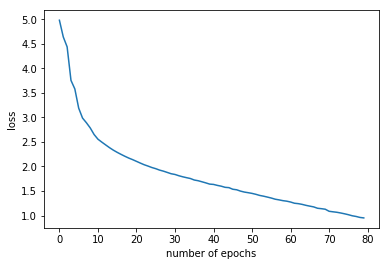

In [30]:
######################################################

import matplotlib.pyplot as plt
y=history.history['loss']
x=range(0,80)
plt.plot(x,y)
#plt.title('top 5 accuracy')
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.show
plt.savefig('loss_normal.png',dpi=300,transparent=False)
plt.show

In [32]:
del a
del b


NameError: name 'a' is not defined

In [33]:
b_test = np.load('quesfet_test.npy')
a_test = np.load('imgfet_test.npy')
l_test = np.load('label_test.npy')

In [35]:
import keras
train_y = keras.utils.np_utils.to_categorical(l_test,num_classes=1000)
loss,test_acc,top5,top3 = model_vqa.evaluate([b_test,a_test], train_y)

print('Test accuracy:', top5)


17218/17218 [==============================] - 113s 7ms/step
Test accuracy: 0.7765129515623185


In [15]:
top3

0.6322995250402932

In [14]:
loss

3.8143251302622656

In [25]:

# serialize model to JSON
model_json = model_vqa.to_json()
with open("model_vqa_vgg19_5layers.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_vqa.save("model_vqa_vgg19_5layers.h5")
print("Saved model to disk")

Saved model to disk
